In [1]:
#######################################################################
#
# lvm-dap-conf: main script to run the LVM-DAP
#
# 
# Notebook version of the lvm-dap-conf script. It runs using the same required inputs and configuration files.
# 
# It requires as inpunts: (1) a YAML file, (2) an input LVM-frame and (3) a label to define the output files
#
# (1) yaml_path = "lvm-dap_SD_fast_SN20_ofelia_nosky_hack_cl_few.yaml"
# (2) lvm_file = 'data_v1.1.1/lvmSFrame-00006109.fits'
# (3) label = 'dap-nb-00006109_few'
#
#
# The content and the format both the YAML and LVM-file should be the same as the ones
# used for the command-line script
#
#

In [2]:
###########################################################################
#
# Defining the environment settings and loading the required models
#
###########################################################################
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# Core Python libraries
import numpy as np
import yaml
from astropy.table import Table
from copy import deepcopy as copy
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from astropy.io import fits

# pyFIT3D and LVM DAP imports (assuming they are installed in your environment)
from lvmdap.pyFIT3D.common.io import clean_preview_results_files, print_time
from lvmdap.pyFIT3D.common.io import trim_waves
from lvmdap.dap_tools import (
    load_LVM_rss, load_LVMSIM_rss, load_in_rss,
    read_PT, read_MaStar_PT, read_LVMSIM_PT,
    read_tab_EL, find_redshift_spec,
    plot_spec_art, plot_spec, fit_legendre_polynomial,
    read_rsp, read_coeffs_RSP, read_elines_RSP, Table_mean_rows,
    replace_nan_inf_with_adjacent_avg, find_continuum, find_closest_indices,
    find_closest_indices_different, read_RSS_PT
)
from lvmdap.flux_elines_tools import flux_elines_RSS_EW_cl
from lvmdap.dap_tools import sort_table_by_id
#from lvmdap.flux_elines_tools import flux_elines_RSS_EW_cl
#from lvmdap.modelling.auto_rsp_tools import auto_rsp_elines_rnd
from lvmdap._cmdline.dap import auto_rsp_elines_rnd
from lvmdap.dap_tools import nanaverage

from lvmdap.pyFIT3D.common.constants import __c__, __Ha_central_wl__, _MODELS_ELINE_PAR
from lvmdap.pyFIT3D.common.auto_ssp_tools import load_rss, dump_rss_output
from astropy.table import join as tab_join
from astropy.table import vstack as vstack_table
from lvmdap.pyFIT3D.common.gas_tools import kin_rss_elines_main
#from lvmdap.elines.kin_elines import kin_rss_elines_main, _MODELS_ELINE_PAR
#from lvmdap.dap_tools import trim_waves

In [3]:
###########################################################
#
#  Load config YAML file
#
###########################################################

# YAML for orion
#yaml_path = "lvm-dap_ORION_test_int.yaml"  # Update this if your file has a different name/path

# YAML for v1.1.1
yaml_path = "lvm-dap_SD_fast_SN20_ofelia_nosky_hack_cl.yaml"

# YAML for tests
#yaml_path = "lvm-dap_SD_fast_SN20_ofelia_nosky_hack_cl_few.yaml"


with open(yaml_path, 'r') as stream:
    config = yaml.safe_load(stream)

# Replace relative paths and pull all parameters into the namespace
lvmdap_dir = config.get("lvmdap_dir", ".")

keys = []
for key in config:
    keys.append(key)
keys = np.array(keys)

a_name=[]
a_value=[]




for key in keys:
    a_name.append(str(key))
    a_value.append(str(config[key]))
    if isinstance(config[key], str):
        config[key] = config[key].replace("..", lvmdap_dir)
    if (key.find("-")>-1):
        clean_key = key.replace("-", "_")
        value = config[key]
        config[clean_key] = value
#        del config[key]

tab_info=Table((a_name,a_value),names=('param','value'))
#hdu_info = fits.BinTableHDU(tab_info,name='INFO')

config["flux_scale"] = config["flux_scale_org"]    
    
config_items = [(k, v) for k, v in config.items()]
config_table = Table(rows=config_items, names=["param", "value"])
config_table.show_in_notebook()      



In [4]:
###########################################################
#                                                         #
#  Define input LVM-file and the output files' label      #
#                                                         #
###########################################################

#config["ny_range"] = (0,5)

# 1st data set
#lvm_file = "sel_1.1.0/sel-00020063.fits" #config["lvm_file"]

# 2nd data set
#lvm_file = "orion/sec-orion.fits"
#label = "junk_orion_nb" #config["label"]
#config["in_rss"] = True

# 3rd data set
lvm_file = 'data_v1.1.1/lvmSFrame-00006109.fits'
#label = 'dap-nb-00006109'
label = 'dap-nb-00006109_few'
config['label'] = label

# If you want to fit just a few spectra for testing

config["ny_range"] = (0,200)

#

# We restrict the fitting to a very narrow range of spectra
#config["ny_range"] = ()
#0
#  - 10

In [5]:
######################################################################
#
#  Load the LVM-file 
#
######################################################################


# Choose input file
config["lvm_file"] = lvm_file 
config["label"] = label  


plot = int(config.get("plot", 0))
ny_range = config.get("ny_range", None)
nx_range = config.get("nx_range", None)

# Load spectrum
if config.get("lvmsim", False):
    wl, rss_flux, rss_eflux, hdr_flux, hdr_0 = load_LVMSIM_rss(lvm_file, ny_range=ny_range, nx_range=nx_range)
    pt_table = read_LVMSIM_PT(lvm_file, 'none', ny_range=ny_range)
elif config.get("in_rss", False):
    wl, rss_flux, rss_eflux, hdr_flux, hdr_0 = load_in_rss(lvm_file, ny_range=ny_range, nx_range=nx_range)
    try:
        pt_table = read_MaStar_PT(lvm_file, 'none', ny_range=ny_range)
    except:
        # Create placeholder PT table
        try:
            pt_table = read_RSS_PT(lvm_file, ny_range = ny_range)
        except:
            NL = rss_flux.shape[0]
            pt_table = Table()
            pt_table['id'] = np.arange(NL)
            pt_table['mask'] = np.full(NL, True)
else:
    wl, rss_flux, rss_eflux, hdr_flux, hdr_0 = load_LVM_rss(lvm_file, ny_range=ny_range, nx_range=nx_range, m2a=1)
    pt_table = read_PT(lvm_file, 'none', ny_range=ny_range)

#
# This should be included in the load_LVM_rss ??
#
try:
    hdu_LSF = fits.open(lvm_file)
    LSF_mean = np.nanmedian(hdu_LSF['LSF'].data,axis=0)/2.354
except:
    LSF_mean =  config['sigma_gas'] * np.ones(rss_flux.shape[1])
    
    

# Replace bad values
rss_flux = replace_nan_inf_with_adjacent_avg(rss_flux)
rss_eflux = replace_nan_inf_with_adjacent_avg(rss_eflux)
rss_eflux[rss_eflux == 0] = np.nanmedian(rss_eflux)

print(f"Loaded {rss_flux.shape[0]} spaxels.")


# sky re-evaluated
# sky-hack did not work
# Y-axis trimmed: (0, 200)


/home/sanchez/.local/lib/python3.11/site-packages/lvmdap/dap_tools.py:179: RuntimeWarning: invalid value encountered in divide
  adjacent_avg = convolved_sum / convolved_mask


Loaded 200 spaxels.


In [6]:
##############################################################
#
# Apply mask to original data first
#
##############################################################

rss_flux_masked = rss_flux[pt_table['mask']]
rss_eflux_masked = rss_eflux[pt_table['mask']]
auto_z_min = config.get("auto_z_min", -0.003)
auto_z_max = config.get("auto_z_max", 0.005)

w0 = 6530 * (1 + auto_z_min)
w1 = 6650 * (1 + auto_z_max)
mask_line = (wl > w0) & (wl < w1)
# Recalculate SN_map using the masked data
SN_map_masked = np.array([
    np.nanmax(f[mask_line] / e[mask_line])
    for f, e in zip(rss_flux_masked, rss_eflux_masked)
])

# Apply S/N threshold
SN_threshold = 3
high_SN_mask = SN_map_masked > SN_threshold

# Compute the integrated flux based on S/N
if np.sum(high_SN_mask) < 3:
    int_flux = nanaverage(rss_flux_masked, 1 / rss_eflux_masked**2, axis=0)
else:
    int_flux = nanaverage(rss_flux_masked[high_SN_mask], 1 / rss_eflux_masked[high_SN_mask]**2, axis=0)

# Estimate the error in the integrated spectrum
int_eflux = np.sqrt(np.nanmedian(rss_eflux_masked**2, axis=0))


🔍 Estimating redshift from integrated spectrum...


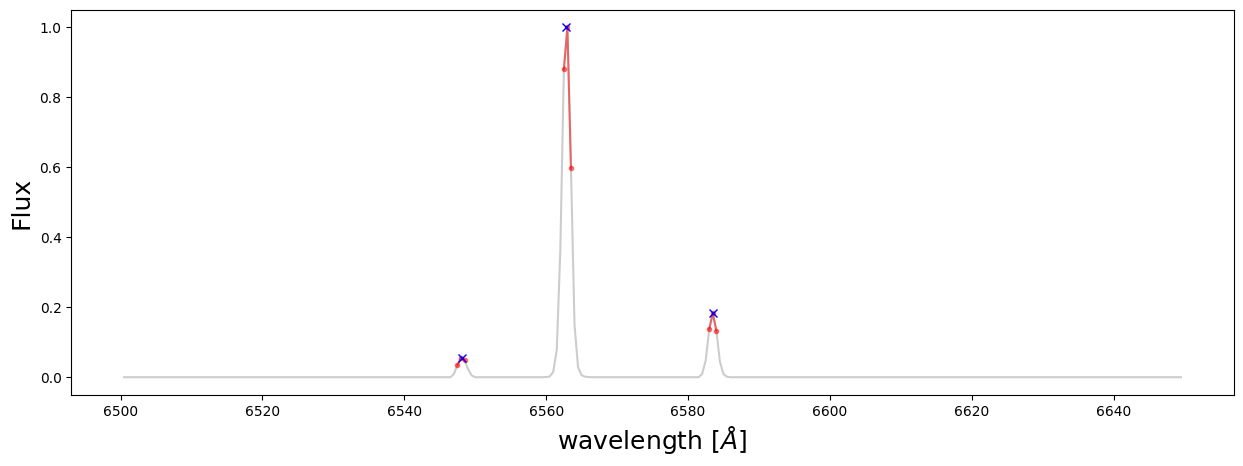

# f_peaks auto_redshift : [1.     0.1826] using threshold: 0.1
Estimated redshift: -2.0383000842727483e-16


In [7]:
###################################################
#
# Auto-detect the redshift of the spectra using Ha+[NII]
#
###################################################



auto_redshift = config.get("auto_redshift", False)
#
# force auto_redshift
#

#auto_redshift = True

#
# force plotting
#
plot = 1
%matplotlib inline

if auto_redshift:
    print("🔍 Estimating redshift from integrated spectrum...")
    int_flux_bg = find_continuum(int_flux, niter=15)
    int_flux_sub = int_flux - int_flux_bg
    z_auto = find_redshift_spec(
        wl, int_flux_sub, z_min=auto_z_min, z_max=auto_z_max,
        d_z=config.get("auto_z_d", 0.00001),
        w_min=6500, w_max=6650,
        w_ref=(6548.05, 6562.85, 6583.45),
        do_plot=plot
    )
    print(f"Estimated redshift: {z_auto}")
    config["redshift"][0] = z_auto


In [8]:
###########################################
#
# Prepare output file names
#
###########################################

output_dir = config["output_path"]
os.makedirs(output_dir, exist_ok=True)

prefix = f"{output_dir}/m_{config['label']}"

out_files = {
    "elines": f"{prefix}.elines.txt",
    "single": f"{prefix}.single.txt",
    "coeffs": f"{prefix}.coeffs.txt",
    "fit": f"{prefix}.output.fits",
    "rsp": f"{prefix}.rsp.txt",
    "fe": f"{prefix}.fe.ecsv",
    "pt": f"{prefix}.PT.ecsv"
}

# Optionally clear previous output
if config.get("clear_outputs", False):
    for f in out_files.values():
        try:
            os.remove(f)
            print(f"🗑️ Removed old file: {f}")
        except FileNotFoundError:
            pass


🗑️ Removed old file: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_dap-nb-00006109_few.elines.txt
🗑️ Removed old file: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_dap-nb-00006109_few.coeffs.txt
🗑️ Removed old file: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_dap-nb-00006109_few.output.fits
🗑️ Removed old file: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_dap-nb-00006109_few.rsp.txt
🗑️ Removed old file: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_dap-nb-00006109_few.fe.ecsv
🗑️ Removed old file: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_dap-nb-00006109_few.PT.ecsv


In [9]:
#########################################################
#
# Fitting the integrated spectra with a combination of RSPs
# and a set of emission lnes (Gaussian Functions)
#
#########################################################


print("🚀 Fitting integrated spectrum...")

# Force plotting 0/1
#plot = 1
plot = 0
%matplotlib inline


if ((config["flux_scale"][0]==-1) and (config["flux_scale"][1]==1)):
      config["flux_scale"][0]=-0.1*np.abs(np.median(int_flux))
      config["flux_scale"][1]=3*np.abs(np.median(int_flux))+10*np.std(int_flux)
      

cf, SPS = auto_rsp_elines_rnd(
    wl__w=wl, f__w=int_flux, ef__w=int_eflux,
    ssp_file=config["rsp_file"],
    ssp_nl_fit_file=config["rsp_nl_file"],
    sigma_inst=config["sigma_inst"],
    spaxel_id=label,
    config_file=config.get("config_file"),
    elines_mask_file=config.get("emission_lines_file"),
    mask_list=config.get("mask_file"),
    fit_gas=not config.get("ignore_gas", False),
    refine_gas=not config.get("single_gas_fit", False),
    sigma_gas=config.get("sigma_gas", 3.0),
    input_redshift=config["redshift"][0],
    delta_redshift=config["redshift"][1],
    min_redshift=config["redshift"][2],
    max_redshift=config["redshift"][3],
    input_sigma=config["sigma"][0],
    delta_sigma=config["sigma"][1],
    min_sigma=config["sigma"][2],
    max_sigma=config["sigma"][3],
    input_AV=config["AV"][0],
    delta_AV=config["AV"][1],
    min_AV=config["AV"][2],
    max_AV=config["AV"][3],
    w_min=config["w_range"][0],
    w_max=config["w_range"][1],
    nl_w_min=config["w_range_nl"][0],
    nl_w_max=config["w_range_nl"][1],
    min=config["flux_scale"][0],
    max=config["flux_scale"][1],
    out_path=config["output_path"],
    plot=plot
)


🚀 Fitting integrated spectrum...
# Using predefined configuration file for the emission lines
##############################
# START: fitting the continuum+emission lines, fit_gas:True ...
-> median error in flux = 27.2253
-> median error in flux = 27.2253
-> median raw flux = 59.0179 - Warning: no cut (CUT_MEDIAN_FLUX = 0)
Normalization window = [5454.999999999999, 5544.999999999999]
Signal-to-Noise inside normalization window = 22.753025214747815
-> MED_FLUX : 95.74503638873186 +- 25.586804319792517 SN:22.753025214747815
-> NL kin fitting
-> median error in flux = 84.6591
- Redshift: 0.00003872 +- 0.00000000
- fit_sigma_rnd
- Sigma:    3.02996799 +- 0.99519146
# Fitting Av
- AV:       0.00000000 +- 0.15000000
Normalization window = [5455.21293844011, 5545.21293844011]
Signal-to-Noise inside normalization window = 22.623050043574025
# Deriving SFH... attempt 1 of 1
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask lis

-> number of models = 2 | chi^2 = 3.55393091889707
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 6766.1601 +/- 129.0956 |    0.7694 +/-  0.0000 |   -0.6155 +/-  4.3683 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    7.2380 +/-  3.3659 |
----------------------------------
Gas fit... DONE!
# Deriving SFH... attempt 1 DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff 

In [10]:
#############################################################################
#  
# Saving the output files of the RSP+EL analysis for the integrated spectrum
#
#############################################################################


output_path = config["output_path"]
os.makedirs(output_path, exist_ok=True)

SPS.output_gas_emission(filename=f"{output_path}/m_{label}.elines.txt")
SPS.output_coeffs_MC(filename=f"{output_path}/m_{label}.coeffs.txt")
SPS.output_fits(filename=f"{output_path}/m_{label}.output.fits")
SPS.output(filename=f"{output_path}/m_{label}.rsp.txt")

print("✅ Integrated spectrum fitting complete and results saved.")



6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_dap-nb-00006109_few.elines.txt
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_dap-nb-00006109_few.elines.txt
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_dap-nb-00006109_few.elines.txt
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_dap-nb-00006109_few.elines.txt
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_dap-nb-00006109_few.elines.txt
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.

# S/N: 0.6855731252602387 91.58111193454661 133.58328755927104
# mean_val_ssp : 0.5983837007304404


/home/sanchez/.local/lib/python3.11/site-packages/lvmdap/dap_tools.py:108: RuntimeWarning: invalid value encountered in divide
  return (flux/np.abs(flux))*(np.abs(flux))**gamma
/home/sanchez/.local/lib/python3.11/site-packages/lvmdap/dap_tools.py:2408: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


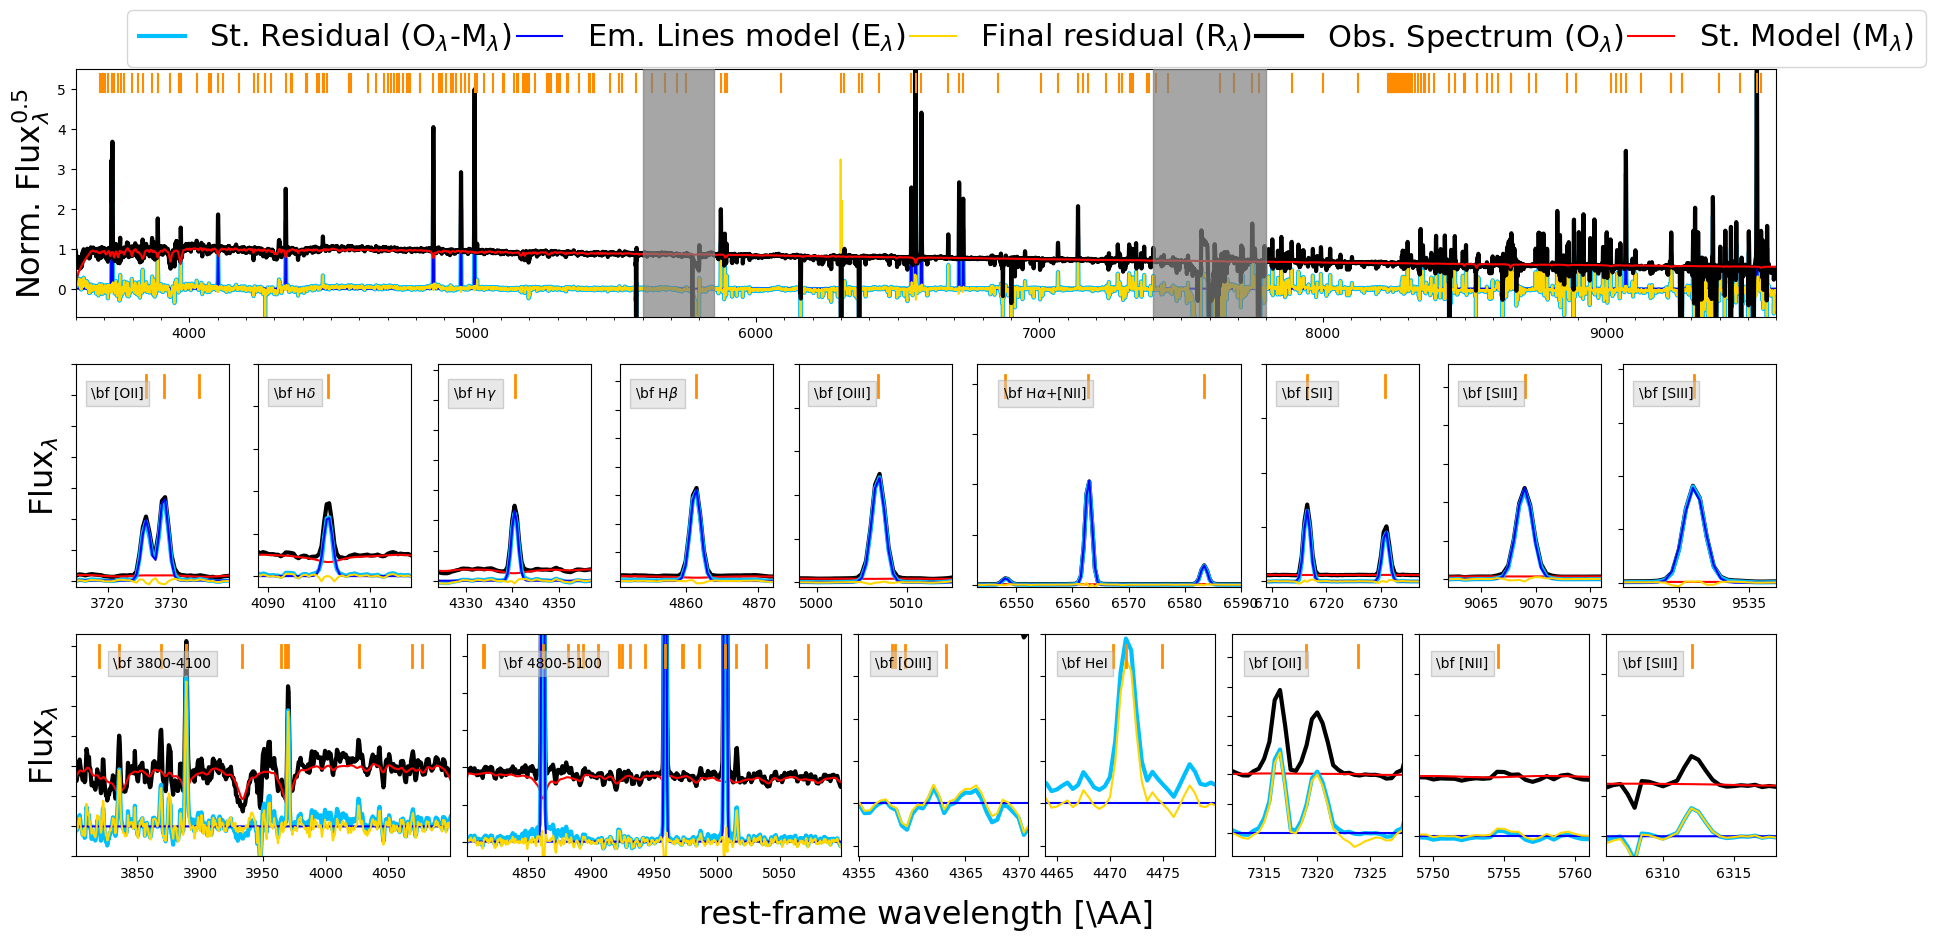

In [11]:
#############################################################################
#  
# Plotting the results of the fitting of the integarted spectrum RSP+EL
#
#############################################################################

if config.get("do_plots", 0) == 1:
    tab_el = read_tab_EL(config["emission_lines_file_long"])
    y_off = -1.09
    y_off2 = -2.18
    plot_spec_art(dir='',
                  file=out_files["fit"],
                  file_ssp=out_files["rsp"],
                  name=config["label"],
                  output=f"{output_dir}/plot_m_{config['label']}.pdf",
                  c_map='CMRmap',\
                  insets=((0.00, y_off, 0.09, 0.9,3715,3739,-1,35,'[OII]'),\
                          (0.107, y_off, 0.09, 0.9,4088,4118,-0.5,10,r'H$\delta$'),\
                          (0.213, y_off, 0.09, 0.9,4324,4357,-0.5,18,r'H$\gamma$'),\
                          (0.320, y_off, 0.09, 0.9,4851,4872,-1.0,38,r'H$\beta$'),\
                          (0.425, y_off, 0.09, 0.9,4998,5015,-1.0,50,'[OIII]'),\
                          (0.530, y_off, 0.155, 0.9,6543,6590,-2,220,r'H$\alpha$+[NII]'),\
                          (0.700, y_off, 0.09, 0.9,6709,6737,-0.5,20,'[SII]'),\
                          (0.807, y_off, 0.09, 0.9,9062,9076,-1.0,28,'[SIII]'),\
                          (0.910, y_off, 0.09, 0.9,9526,9537,-1.5,82,'[SIII]'),\
                          (0.00, y_off2, 0.22, 0.9,3801,4099,-0.5,3.2,'3800-4100'),\
                          (0.23, y_off2, 0.22, 0.9,4801,5099,-0.2,2.8,'4800-5100'),\
                          (0.46, y_off2, 0.10, 0.9,4363-8.1,4363+7.9,-0.25,0.8,'[OIII]'),\
                          (0.57, y_off2, 0.10, 0.9,4472-8.1,4472+7.9,-0.25,0.8,'HeI'),\
                          (0.68, y_off2, 0.10, 0.9,7320-8,7320+8,-0.2,1.7,'[OII]'),\
                          (0.79, y_off2, 0.10, 0.9,5755-6,5755+6,-0.25,2.5,'[NII]'),\
                          (0.90, y_off2, 0.10, 0.9,6312-6,6312+6,-0.25,2.5,'[SIII]')
                         ),
                      y_min=-0.5,y_max=30,y0_d=0.3,y1_d=2.9,\
                      x_min=3600,x_max=9600,plot_el=True, tab_el=tab_el,plot_res=True,\
                      show_scale=False,n_ord=2,gamma=0.5)#,x_min=3600,x_max=9600)



1 12401 1
215 emission lines
0 HI 3686.83
1 HI 3691.56
2 HI 3697.15
3 HI 3703.85
4 HI 3711.97
5 [OII] 3726.03
6 [OII] 3728.82
7 HI 3734.37
8 HI 3750.15
9 [FeVII] 3758.9
10 HI 3770.63
11 HI 3797.9
12 HeI 3819.61
13 HI 3835.38
14 [NeIII] 3868.75
15 HeI 3888.65
16 HI 3889.05
17 CaII 3933.66
18 HeI 3964.73
19 [NeIII] 3967.46
20 CaII 3968.47
21 Hepsilon 3970.07
22 HeI 4026.19
23 [SII] 4068.6
24 [SII] 4076.35
25 Hdelta 4101.77
26 HeI 4120.81
27 [FeII] 4177.21
28 [FeV] 4227.2
29 [FeII] 4243.98
30 CII 4267.0
31 [FeII] 4287.4
32 Hgamma 4340.49
33 [FeII] 4358.1
34 [FeII] 4358.37
35 [FeII] 4359.34
36 [OIII] 4363.21
37 [FeII] 4413.78
38 [FeII] 4414.45
39 [FeII] 4416.27
40 [FeII] 4452.11
41 [FeII] 4457.95
42 [FeII] 4470.29
43 HeI 4471.48
44 [FeII] 4474.91
45 [NiII] 4485.21
46 [MgI] 4562.48
47 MgI] 4571.1
48 [FeII] 4632.27
49 [FeIII] 4658.1
50 HeII 4685.68
51 [FeIII] 4701.62
52 [ArIV] 4711.33
53 HeI 4713.14
54 [NeIV] 4724.17
55 [FeIII] 4733.93
56 [ArIV] 4740.2
57 [FeIII] 4754.83
58 [FeIII] 4769.6
59

144/215, 7388.16,[FeII] blended: 0 DONE
145/215, 7411.61,[NiII] blended: 0 DONE
146/215, 7452.5,[FeII] blended: 0 DONE
147/215, 7637.52,[FeII] blended: 0 DONE
148/215, 7686.19,[FeII] blended: 1 DONE
149/215, 7686.9,[FeII] blended: 1 DONE
150/215, 7751.06,[ArIII] blended: 0 DONE
151/215, 7774.0,OI blended: 0 DONE
152/215, 7891.8,[FeXI] blended: 0 DONE
153/215, 7999.85,[CrII] blended: 0 DONE
154/215, 8125.22,[CrII] blended: 0 DONE
155/215, 8229.55,[CrII] blended: 0 DONE
156/215, 8236.77,HeII blended: 1 DONE
157/215, 8239.24,HI blended: 1 DONE
158/215, 8240.82,HI blended: 1 DONE
159/215, 8242.51,HI blended: 1 DONE
160/215, 8244.32,HI blended: 1 DONE
161/215, 8246.27,HI blended: 1 DONE
162/215, 8248.35,HI blended: 1 DONE
163/215, 8250.6,HI blended: 1 DONE
164/215, 8253.03,HI blended: 1 DONE
165/215, 8255.65,HI blended: 1 DONE
166/215, 8258.49,HI blended: 1 DONE
167/215, 8261.57,HI blended: 1 DONE
168/215, 8264.92,HI blended: 1 DONE
169/215, 8268.57,HI blended: 0 DONE
170/215, 8272.56,HI bl

<IPython.core.display.Javascript object>


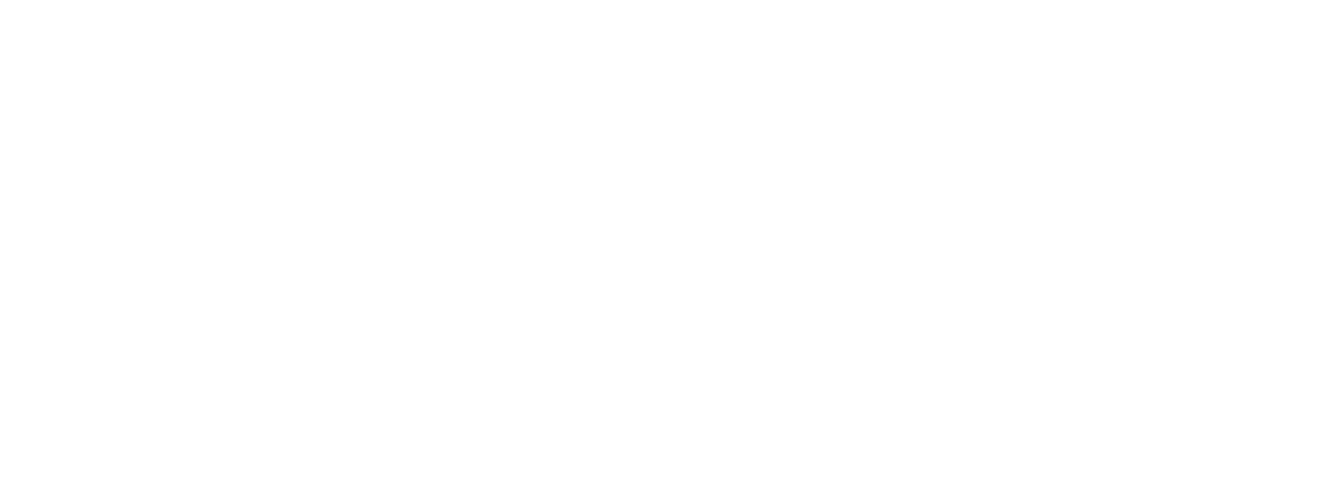

📊 Emission line table saved to: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/m_dap-nb-00006109_few.fe.ecsv


In [12]:
######################################################################
#
# Non-parametric analysis of the emission lines for the RSP-subtracted
# integrated spectrum (gas-pure spectrum)
#
######################################################################

# Prepare model outputs
%matplotlib notebook
#config["do_plots"]=1
config["do_plots"]=1
config["plot"]=1
plot = 1
do_plots = 1

#%matplotlib inline

out_model = np.array(SPS.output_spectra_list)
gas = out_model[0] - out_model[1]
smooth = median_filter(gas, size=config.get("smooth_size", 21))
l_smooth = fit_legendre_polynomial(wl, smooth, config.get("n_leg", 51))

out_model[2] += l_smooth
out_model[3] = out_model[0] - (out_model[1] + l_smooth)
out_model[4] = out_model[0] - out_model[2]

# Prepare single-RSS input for flux_elines
m_flux_rss = np.expand_dims(out_model[0] - out_model[1] - l_smooth, axis=0)
m_e_flux_rss = np.expand_dims(int_eflux, axis=0)
m_s_flux_rss = np.expand_dims(out_model[1] + l_smooth, axis=0)

vel__yx = np.zeros(1) + config["redshift"][0] * __c__
sigma__yx = config.get("sigma_gas", 0.8)
sigma__yx = 0.86
# Read emission lines again
tab_el = read_tab_EL(config["emission_lines_file_long"])

#
# We find the nearest emission line
#
lsf = []
blended = []
for wl_el in tab_el['wl']:
    i_wl_el = find_closest_indices(wl, wl_el)
    lsf_now = LSF_mean[i_wl_el[0]]
    lsf.append(lsf_now)
    i_wl_near = find_closest_indices_different(tab_el['wl'], wl_el)
    dist_abs = np.abs(wl_el-tab_el['wl'][i_wl_near[0]])
    if (dist_abs<4*sigma__yx):
        blended.append(1)
    else:
        blended.append(0)
blended = np.array(blended)    
tab_el['blended'] = blended
lsf = np.array(lsf)
tab_el['lsf'] = lsf
sigma_we = 1.0

#tab_el['lsf'] = 0.86
#print(np.sqrt(tab_el['lsf']**2+sigma__yx**2))

#tab_el['lsf'] = None
#sigma_we = 0.5

# Run flux_elines
fe_data, fe_hdr = flux_elines_RSS_EW_cl(
    m_flux_rss, hdr_flux, 5, tab_el, vel__yx, sigma__yx,
    eflux__wyx=m_e_flux_rss, flux_ssp__wyx=m_s_flux_rss,
    w_range=config.get("w_range_FE", 30),
    plot=config.get("do_plots", 0), sigma_we = sigma_we
)

# Convert to Astropy Table and save
colnames = [f"{fe_hdr[f'NAME{i}']}_{fe_hdr[f'WAVE{i}']}".replace(" ", "_") for i in range(fe_data.shape[0])]
tab_fe = Table(np.transpose(fe_data), names=colnames)
tab_fe.write(out_files["fe"], overwrite=True, delimiter=',')
print(f"📊 Emission line table saved to: {out_files['fe']}")



In [13]:
#######################################################
#
# We remove the option to plot all figures
#
#######################################################
config["do_plot"] = 0
config["plot"] = 0


In [14]:
###########################################################
#
# Starting full RSS fitting for all spaxels
#
###########################################################


print("🚀 Starting full RSS fitting for all spaxels...\n")

out_file_fe = os.path.join(config["output_path"], f"{label}.fe.txt")
out_file_elines = os.path.join(config["output_path"], f"{label}.elines.txt")
out_file_kel = os.path.join(config["output_path"], f"{label}.kel.txt")
out_file_single = os.path.join(config["output_path"], f"{label}.single.txt")
out_file_coeffs = os.path.join(config["output_path"], f"{label}.coeffs.txt")
out_file_fit = os.path.join(config["output_path"], f"{label}.output.fits.gz")
out_file_ps = os.path.join(config["output_path"], f"{label}.rsp.txt")
out_file_dap = os.path.join(config["output_path"], f"{label}.dap.fits.gz")

# remove previous outputs with the same label
if (config["clear_outputs"]):
    clean_preview_results_files(out_file_ps, out_file_elines, out_file_single, out_file_coeffs, out_file_fit)
    clean_preview_results_files(out_file_fe, out_file_elines, out_file_single, out_file_coeffs, out_file_fit)
    clean_preview_results_files(out_file_dap, out_file_elines, out_file_single, out_file_coeffs, out_file_fit)
    clean_preview_results_files(out_file_kel, out_file_elines, out_file_single, out_file_coeffs, out_file_fit)



rss_flux_masked = rss_flux[pt_table['mask']]
rss_eflux_masked = rss_eflux[pt_table['mask']]
tab_PT_masked = pt_table[pt_table['mask']]
tab_PT = tab_PT_masked 

model_spectra = []
y_ratio = None
nspec = rss_flux_masked.shape[0]

# Reuse the SPS from integrated spectrum as starting point
SPS_master = SPS

for i, (f__w, ef__w) in enumerate(zip(rss_flux_masked, rss_eflux_masked)):
    print(f"\n### Fitting spaxel {i+1}/{nspec} (ID: {tab_PT_masked['id'][i]})")

    #
    # printing some values
    #
    # print(SPS.best_redshift)
    # print(SPS.best_sigma)
    # print(SPS.best_AV)

    cf = SPS.config
    cf.redshift = SPS.best_redshift
    cf.sigma = SPS.best_sigma
    cf.AV = SPS.best_AV
    spaxel_label = f"{config['label']}_{i}"
    
    _, SPS = auto_rsp_elines_rnd(
        wl__w=wl, f__w=f__w, ef__w=ef__w,
        ssp_file=config["rsp_file"],
        ssp_nl_fit_file=config["rsp_nl_file"],
        config_file=config["config_file"],
        w_min=config["w_range"][0], w_max=config["w_range"][1],
        nl_w_min=config["w_range_nl"][0], nl_w_max=config["w_range_nl"][1],
        mask_list=config.get("mask_file"),
        min=config["flux_scale"][0], max=config["flux_scale"][1],
        elines_mask_file=config.get("emission_lines_file"),
        fit_gas=not config.get("ignore_gas", False),
        refine_gas=not config.get("single_gas_fit", False),
        sigma_gas=config.get("sigma_gas", 3.0),
        input_redshift=config["redshift"][0],
        delta_redshift=config["redshift"][1],
        min_redshift=config["redshift"][2],
        max_redshift=config["redshift"][3],
        input_sigma=config["sigma"][0],
        delta_sigma=config["sigma"][1],
        min_sigma=config["sigma"][2],
        max_sigma=config["sigma"][3],
        input_AV=config["AV"][0],
        delta_AV=config["AV"][1],
        min_AV=config["AV"][2],
        max_AV=config["AV"][3],
        sigma_inst=config["sigma_inst"],
        spaxel_id=spaxel_label,
        out_path=config["output_path"],
        plot=config.get("plot", 0),
        SPS_master=SPS_master,
        SN_CUT=config.get("SN_CUT", 3)
    )

    SPS.output_gas_emission(filename=f"{output_dir}/{config['label']}.elines.txt", spec_id=i)
    SPS.output_coeffs_MC(filename=f"{output_dir}/{config['label']}.coeffs.txt", write_header=(i == 0))

    try:
        SPS.output(filename=f"{output_dir}/{config['label']}.rsp.txt", write_header=(i == 0), block_plot=False)
    except Exception as e:
        print(f"⚠️ Warning: Failed to write spaxel {i} summary output. Filling with NaNs.")
        pass

    model_spectra.append(SPS.output_spectra_list)


🚀 Starting full RSS fitting for all spaxels...


### Fitting spaxel 1/174 (ID: 6109.3)
# Using predefined configuration file for the emission lines
##############################
# START: fitting the continuum+emission lines, fit_gas:True ...
-> median error in flux = 27.9784
-> median raw flux = 47.5810 - Warning: no cut (CUT_MEDIAN_FLUX = 0)
Normalization window = [5455.21293844011, 5545.21293844011]
Signal-to-Noise inside normalization window = 6.92828388750976
-> MED_FLUX : 83.91510772705078 +- 39.796711315070674 SN:6.92828388750976
-> Single SSP fit 
- Redshift: 0.00003872 +- 0.00000000
- Sigma:    3.02996799 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0080 |  3.8578 |  4.0286 | 0.1982 | 0.0135 |      0.0057 |        0.0058 |
--

-> number of models = 2 | chi^2 = 2.756791653441213
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 4488.6460 +/- 156.3815 |    0.7286 +/-  0.0208 |   -0.1774 +/-  5.4960 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   45.4637 +/-  3.8750 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.4468580835145999
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  336.7288 +/- 69.3231 |    1.0282 +/-  0.0450 |   -5.7640 +/-  5.1937 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -5.0513 +/-  2.1364 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 11.606788793329866 (-88.3932, 111.6068)
-> real number of loops = 200
-> number of models = 2

Normalization window = [5455.21293844011, 5545.21293844011]
Signal-to-Noise inside normalization window = 4.149750133540529
-> MED_FLUX : 77.71361541748047 +- 34.317253162847784 SN:4.149750133540529
-> Single SSP fit 
- Redshift: 0.00003872 +- 0.00000000
- Sigma:    3.02996799 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0015 |        0.0014 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 11.606788793329866 (-88.3932, 111.6068)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 0.5

-> real number of loops = 150
-> number of models = 2 | chi^2 = 3.466634090433174
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 5468.4357 +/- 160.1337 |    0.7069 +/-  0.0377 |    0.1538 +/-  0.5221 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   27.1047 +/-  2.2927 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.5201359493137118
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 |  954.9287 +/- 77.6439 |    0.8647 +/-  0.0254 |   17.4331 +/-  3.6975 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.1243 +/-  1.6579 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 11.606788793329866 (-88.3932, 111.6068)
-> real number of loops = 150
-> number of models = 

Normalization window = [5455.21293844011, 5545.21293844011]
Signal-to-Noise inside normalization window = 8.353692741037392
-> MED_FLUX : 124.59827423095703 +- 39.612119539857446 SN:8.353692741037392
-> Single SSP fit 
- Redshift: 0.00003872 +- 0.00000000
- Sigma:    3.02996799 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0096 |  3.6689 |  2.1473 | -1.4688 | 0.2188 |      0.0012 |        0.0012 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 11.606788793329866 (-88.3932, 111.6068)
-> real number of loops = 200
-> number of models = 3 | chi^2 = 1.

-> analyzing 2 models in 9500-9570 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
9531.1 - guided vel = 11.606788793329866 (-88.3932, 111.6068)
-> real number of loops = 200
-> number of models = 2 | chi^2 = 3.532222911738418
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 7201.2869 +/- 129.3333 |    0.7390 +/-  0.0000 |    0.5567 +/-  0.3977 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  112.4414 +/-  1.6692 |
----------------------------------
Gas fit... DONE!
--------------------------------

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.3807927785842941
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 1176.0618 +/- 48.1401 |    0.7383 +/-  0.0000 |    5.6264 +/-  4.2744 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -4.2696 +/-  1.8774 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 11.606788793329866 (-88.3932, 111.6068)
-> real number of loops = 125
-> number of models = 

Normalization window = [5455.21293844011, 5545.21293844011]
Signal-to-Noise inside normalization window = 4.78892790976716
-> MED_FLUX : 83.81868743896484 +- 43.02077816854683 SN:4.78892790976716
-> Single SSP fit 
- Redshift: 0.00003872 +- 0.00000000
- Sigma:    3.02996799 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0026 |        0.0026 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 11.606788793329866 (-88.3932, 111.6068)
-> real number of loops = 300
-> number of models = 3 | chi^2 = 1.4233

-> real number of loops = 225
-> number of models = 2 | chi^2 = 4.54547824882733
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 8833.8092 +/- 193.4295 |    0.7554 +/-  0.0253 |    1.1321 +/-  0.5860 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   11.8666 +/-  2.6933 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
--

-> real number of loops = 125
-> number of models = 2 | chi^2 = 0.434628931653971
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  707.3693 +/- 54.0886 |    0.7946 +/-  0.0657 |    2.9447 +/-  3.1978 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.8024 +/-  0.8120 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 11.606788793329866 (-88.3932, 111.6068)
-> real number of loops = 225
-> number of models = 2 

Normalization window = [5455.21293844011, 5545.21293844011]
Signal-to-Noise inside normalization window = 4.93029623793754
-> MED_FLUX : 84.8281478881836 +- 44.06539395470476 SN:4.93029623793754
-> Single SSP fit 
- Redshift: 0.00003872 +- 0.00000000
- Sigma:    3.02996799 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0038 |        0.0037 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 11.606788793329866 (-88.3932, 111.6068)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 2.72452

-> number of models = 2 | chi^2 = 4.7613444577627115
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 11290.8245 +/- 435.3118 |    0.6980 +/-  0.0407 |    2.3345 +/-  1.9163 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   19.2600 +/-  7.4115 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.47421269256856646
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  879.8935 +/- 66.7099 |    0.7466 +/-  0.0475 |   -0.0865 +/-  2.5956 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    2.8675 +/-  0.8529 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 11.606788793329866 (-88.3932, 111.6068)
-> real number of loops = 150
-> number of models = 

Normalization window = [5455.21293844011, 5545.21293844011]
Signal-to-Noise inside normalization window = 4.681364518932768
-> MED_FLUX : 83.25328063964844 +- 44.10799408462561 SN:4.681364518932768
-> Single SSP fit 
- Redshift: 0.00003872 +- 0.00000000
- Sigma:    3.02996799 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0034 |        0.0034 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 11.606788793329866 (-88.3932, 111.6068)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 1.86

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 |  0.3809 | 0.0000 |    0.0000 |  14.6380 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 175
-> number of models = 2 | chi^2 = 25.44514188564024
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5419.5617 +/- 522.7353 |    0.6932 +/-  0.3354 |   18.1531 +/- 22.3607 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    0.3997 +/-  5.1619 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = 11.606788793329866 (-88.3932, 111.6068)
-> real number of loops = 125
-> number of 

-> number of models = 3 | chi^2 = 1.6890210487623363
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 23437.3693 +/- 478.9184 |    0.5835 +/-  0.0226 |    0.7824 +/-  0.9100 |
| eline | 6583.4500 +/-  0.0000 | 3099.3527 +/- 112.8903 |    0.5835 +/-  0.0226 |    0.7824 +/-  0.9100 |
| eline | 6548.0500 +/-  0.0000 | 1032.0845 +/- 72.7993 |    0.5835 +/-  0.0226 |    0.7824 +/-  0.9100 |
---------------------------------------------------------------------------------------------------------
-> analyzing 2 models in 6700-6750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6730.82 - guided vel = 11.606788793329866 (-88.3932, 111.6068)
-> rea

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0079 |  3.8048 |  4.1086 | -0.1759 |  0.0881 | 0.0000 |    0.0000 |  13.0625 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 175
-> number of models = 2 | chi^2 = 27.986461203772013
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5984.7728 +/- 600.6507 |    0.8202 +/-  0.3354 |   16.1088 +/- 22.3607 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    8.5184 +/-  6.9473 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = 11.606788793329866 (-88.3932, 111.6068)
-> real number of loops = 150
-> number of

-> real number of loops = 350
-> number of models = 3 | chi^2 = 0.5244562266248342
        --------------------------------------------------------------------------------------------------
        |         wave          |          flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 15876.1554 +/- 47.5079 |    0.5963 +/-  0.0000 |    1.5768 +/-  0.2188 |
| eline | 6583.4500 +/-  0.0000 | 2182.9760 +/- 64.0490 |    0.5963 +/-  0.0000 |    1.5768 +/-  0.2188 |
| eline | 6548.0500 +/-  0.0000 |  726.9310 +/- 38.4210 |    0.5963 +/-  0.0000 |    1.5768 +/-  0.2188 |
---------------------------------------------------------------------------------------------------------
-> analyzing 2 models in 6700-6750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6730.82 - guided vel = 11.606788793329866 (-

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 |  0.0572 | 0.0000 |    0.0000 |  13.0617 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 125
-> number of models = 2 | chi^2 = 59.81685546159454
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5563.7384 +/- 827.1533 |    1.0000 +/-  0.3354 |  -30.5811 +/- 21.1648 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    3.3706 +/-  6.3475 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = 11.606788793329866 (-88.3932, 111.6068)
-> real number of loops = 125
-> number of 

-> number of models = 3 | chi^2 = 3.49743620355484
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 17712.9049 +/- 272.3344 |    0.5961 +/-  0.0178 |    0.9443 +/-  2.9489 |
| eline | 6583.4500 +/-  0.0000 | 2729.9376 +/- 85.0830 |    0.5961 +/-  0.0178 |    0.9443 +/-  2.9489 |
| eline | 6548.0500 +/-  0.0000 |  909.0692 +/- 68.6674 |    0.5961 +/-  0.0178 |    0.9443 +/-  2.9489 |
---------------------------------------------------------------------------------------------------------
-> analyzing 2 models in 6700-6750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6730.82 - guided vel = 11.606788793329866 (-88.3932, 111.6068)
-> real n

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 |  0.0572 | 0.0000 |    0.0000 |  13.0617 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 250
-> number of models = 2 | chi^2 = 0.37768851290972666
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  775.0856 +/- 47.9336 |    0.7414 +/-  0.0250 |    7.9604 +/-  3.1676 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    2.7211 +/-  1.3422 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 11.606788793329866 (-88.3932, 111.6068)
-> real number of loops = 150
-> number of models = 

Normalization window = [5455.21293844011, 5545.21293844011]
Signal-to-Noise inside normalization window = 4.543370212641735
-> MED_FLUX : 88.3668441772461 +- 46.212974962040555 SN:4.543370212641735
-> Single SSP fit 
- Redshift: 0.00003872 +- 0.00000000
- Sigma:    3.02996799 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 | 0.0572 |      0.0025 |        0.0025 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 11.606788793329866 (-88.3932, 111.6068)
-> real number of loops = 200
-> number of models = 3 | chi^2 = 1.19

-> real number of loops = 200
-> number of models = 2 | chi^2 = 3.4327398006699155
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 7306.3442 +/- 131.9011 |    0.7627 +/-  0.0000 |    2.2956 +/-  3.4785 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    3.9133 +/-  2.2866 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |


-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.36156591680719147
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 1332.2015 +/- 47.1327 |    0.7652 +/-  0.0175 |    6.3969 +/-  1.9399 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -6.0696 +/-  1.2454 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 11.606788793329866 (-88.3932, 111.6068)
-> real number of loops = 200
-> number of models =

Normalization window = [5455.21293844011, 5545.21293844011]
Signal-to-Noise inside normalization window = 16.217294729491726
-> MED_FLUX : 409.5059509277344 +- 84.07209973863684 SN:16.217294729491726
-> Single SSP fit 
- Redshift: 0.00003872 +- 0.00000000
- Sigma:    3.02996799 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0085 |  3.7860 |  3.7639 | -2.1937 | 0.3452 |      0.0001 |        0.0001 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 11.606788793329866 (-88.3932, 111.6068)
-> real number of loops = 225
-> number of models = 3 | chi^2 = 0.

-> real number of loops = 175
-> number of models = 2 | chi^2 = 2.426286977301471
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 5971.7628 +/- 136.6101 |    0.7458 +/-  0.0400 |    0.2140 +/-  5.9044 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -16.2041 +/-  2.4122 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.4156185431203654
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  522.8904 +/- 44.7705 |    0.6519 +/-  0.0000 |    5.8452 +/-  1.7409 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   13.1737 +/-  1.9555 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 11.606788793329866 (-88.3932, 111.6068)
-> real number of loops = 225
-> number of models = 2

Normalization window = [5455.21293844011, 5545.21293844011]
Signal-to-Noise inside normalization window = 7.434049107700582
-> MED_FLUX : 254.01785278320312 +- 53.98234678961222 SN:7.434049107700582
-> Single SSP fit 
- Redshift: 0.00003872 +- 0.00000000
- Sigma:    3.02996799 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0014 |  3.8369 |  4.0807 | -0.9060 | 0.1636 |      0.0006 |        0.0006 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 11.606788793329866 (-88.3932, 111.6068)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 0.4

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0014 |  3.8369 |  4.0807 | -0.9060 |  0.1636 | 0.0000 |    0.0000 |  13.7118 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.3991844966737949
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  796.1864 +/- 54.1652 |    0.8014 +/-  0.0442 |    2.5815 +/-  2.9479 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -18.3997 +/-  1.0302 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 11.606788793329866 (-88.3932, 111.6068)
-> real number of loops = 225
-> number of models = 2

Normalization window = [5455.21293844011, 5545.21293844011]
Signal-to-Noise inside normalization window = 8.242193260006621
-> MED_FLUX : 135.36370849609375 +- 44.97578522632592 SN:8.242193260006621
-> Single SSP fit 
- Redshift: 0.00003872 +- 0.00000000
- Sigma:    3.02996799 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0045 |  3.7507 |  3.4885 | -1.8030 | 0.2629 |      0.0007 |        0.0007 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 11.606788793329866 (-88.3932, 111.6068)
-> real number of loops = 200
-> number of models = 3 | chi^2 = 0.9

-> real number of loops = 125
-> number of models = 2 | chi^2 = 2.6827580228698618
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 6577.7255 +/- 119.0033 |    0.7556 +/-  0.0373 |    0.7461 +/-  3.2517 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    9.0313 +/-  3.1267 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |


-> real number of loops = 150
-> number of models = 2 | chi^2 = 6.186227331040105
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5247.6910 +/- 584.2273 |    0.6321 +/-  0.3354 |  -15.0547 +/- 22.3404 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   57.9705 +/-  9.9332 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of m

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.797829125399044
-> MED_FLUX : 90.85211181640625 +- 43.57592174254921 SN:4.797829125399044
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 | 0.0572 |      0.0016 |        0.0016 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 0.6

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 |  0.0572 | 0.0000 |    0.0000 |  13.0617 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 150
-> number of models = 2 | chi^2 = 29.02861562339762
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5854.9710 +/- 642.7858 |    0.9070 +/-  0.3354 |  -15.0406 +/- 21.9389 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    9.5526 +/-  7.2576 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 225
-> number of m

-> number of models = 3 | chi^2 = 0.5708706538119626
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 14576.2489 +/- 147.9837 |    0.5915 +/-  0.0071 |    1.5886 +/-  1.9535 |
| eline | 6583.4500 +/-  0.0000 | 2547.8401 +/- 82.7420 |    0.5915 +/-  0.0071 |    1.5886 +/-  1.9535 |
| eline | 6548.0500 +/-  0.0000 |  848.4308 +/- 44.6280 |    0.5915 +/-  0.0071 |    1.5886 +/-  1.9535 |
---------------------------------------------------------------------------------------------------------
-> analyzing 2 models in 6700-6750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6730.82 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real 

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 |  0.0572 | 0.0000 |    0.0000 |  13.0617 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 2 | chi^2 = 22.2597948992221
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5835.9701 +/- 537.5314 |    0.7867 +/-  0.3354 |  -15.5125 +/- 22.2373 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    8.2024 +/-  7.1258 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength 

Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 0.5830574649204889
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 15123.4837 +/- 415.3944 |    0.6142 +/-  0.0294 |    1.4798 +/-  1.2817 |
| eline | 6583.4500 +/-  0.0000 | 2706.2813 +/- 70.2121 |    0.6142 +/-  0.0294 |    1.4798 +/-  1.2817 |
| eline | 6548.0500 +/-  0.0000 |  901.1917 +/- 44.3492 |    0.6142 +/-  0.0294 |    1.4798 +/-  1.2817 |
-------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0096 |  3.6689 |  2.1473 | -1.4688 |  0.2188 | 0.0000 |    0.0000 |  13.4491 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> number of models = 2 | chi^2 = 0.4597205395654411
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  539.2241 +/- 47.8350 |    0.7219 +/-  0.0204 |   -1.7174 +/-  5.2682 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -3.4801 +/-  0.5728 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 2 | chi^2 = 43.732908810007224
 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.578296810392929
-> MED_FLUX : 77.1933364868164 +- 40.10214719052841 SN:4.578296810392929
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0017 |        0.0017 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 0.42

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 |  0.3809 | 0.0000 |    0.0000 |  14.6380 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 200
-> number of models = 2 | chi^2 = 23.6320361882451
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5945.5543 +/- 531.5109 |    0.7508 +/-  0.3354 |  -15.0406 +/- 22.3549 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    7.2231 +/-  6.0718 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of mo

-> number of models = 3 | chi^2 = 1.168356561156463
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 19444.6271 +/- 374.0624 |    0.5976 +/-  0.0413 |    2.5435 +/-  4.5822 |
| eline | 6583.4500 +/-  0.0000 | 2465.3018 +/- 81.1202 |    0.5976 +/-  0.0413 |    2.5435 +/-  4.5822 |
| eline | 6548.0500 +/-  0.0000 |  820.9455 +/- 58.5301 |    0.5976 +/-  0.0413 |    2.5435 +/-  4.5822 |
---------------------------------------------------------------------------------------------------------
-> analyzing 2 models in 6700-6750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6730.82 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real n

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 |  0.0572 | 0.0000 |    0.0000 |  13.0617 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 175
-> number of models = 2 | chi^2 = 27.715411730630585
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -6383.4570 +/- 623.4238 |    0.8897 +/-  0.3354 |  -15.0986 +/- 22.2622 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   14.3431 +/-  5.9877 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of 

-> number of models = 3 | chi^2 = 2.0231016552831256
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 29104.7147 +/- 1066.3699 |    0.5912 +/-  0.0574 |    1.4004 +/-  5.5738 |
| eline | 6583.4500 +/-  0.0000 | 4070.5528 +/- 146.1171 |    0.5912 +/-  0.0574 |    1.4004 +/-  5.5738 |
| eline | 6548.0500 +/-  0.0000 | 1355.4941 +/- 95.2789 |    0.5912 +/-  0.0574 |    1.4004 +/-  5.5738 |
---------------------------------------------------------------------------------------------------------
-> analyzing 2 models in 6700-6750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6730.82 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> 

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 |  0.3809 | 0.0000 |    0.0000 |  14.6380 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 150
-> number of models = 2 | chi^2 = 48.533838436029875
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5712.9700 +/- 723.1105 |    0.8803 +/-  0.3354 |   22.7903 +/- 22.3607 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.9087 +/-  6.8796 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of 

-> real number of loops = 125
-> number of models = 2 | chi^2 = 0.18260085948699403
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 1076.8839 +/- 23.9191 |    0.5958 +/-  0.0121 |    6.7426 +/-  3.8412 |
| eline | 6716.4400 +/-  0.0000 | 1473.7193 +/- 52.3665 |    0.5958 +/-  0.0121 |    6.7426 +/-  3.8412 |
---------------------------------------------------------------------------------------------------------
-> analyzing 3 models in 4800-5030 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
5006.84 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 250
-> number of models = 3 | chi^2 = 0.29810394714692423
       

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.432590915809057
-> MED_FLUX : 75.74322509765625 +- 43.03202528478563 SN:4.432590915809057
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0034 |        0.0035 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 200
-> number of models = 3 | chi^2 = 2.3

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 |  0.3809 | 0.0000 |    0.0000 |  14.6380 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 150
-> number of models = 2 | chi^2 = 41.4374862803124
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -6030.3809 +/- 697.7881 |    0.8995 +/-  0.3354 |   21.3686 +/- 22.3607 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    9.6529 +/-  8.4706 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of mo

-> number of models = 3 | chi^2 = 2.0748787304141283
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 19350.6571 +/- 132.3976 |    0.5821 +/-  0.0065 |    0.0226 +/-  1.1226 |
| eline | 6583.4500 +/-  0.0000 | 3912.8155 +/- 74.3509 |    0.5821 +/-  0.0065 |    0.0226 +/-  1.1226 |
| eline | 6548.0500 +/-  0.0000 | 1302.9676 +/- 55.0388 |    0.5821 +/-  0.0065 |    0.0226 +/-  1.1226 |
---------------------------------------------------------------------------------------------------------
-> analyzing 2 models in 6700-6750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6730.82 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real 

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 |  0.3809 | 0.0000 |    0.0000 |  14.6380 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.37831594808169133
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  758.5944 +/- 54.2042 |    0.9542 +/-  0.0269 |   -7.6254 +/-  2.2257 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.2944 +/-  1.3730 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 2

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.388812632442862
-> MED_FLUX : 84.19972229003906 +- 40.94183867572804 SN:4.388812632442862
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 | 0.0572 |      0.0022 |        0.0022 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 225
-> number of models = 3 | chi^2 = 0.7

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 |  0.0572 | 0.0000 |    0.0000 |  13.0617 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.2708194436367121
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  392.1531 +/- 48.3969 |    0.9456 +/-  0.0148 |   12.8111 +/-  5.6458 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.7267 +/-  0.8999 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 2 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.241571181718709
-> MED_FLUX : 78.86825561523438 +- 33.87629954668126 SN:4.241571181718709
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 | 0.0572 |      0.0011 |        0.0011 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 200
-> number of models = 3 | chi^2 = 0.5

-> real number of loops = 150
-> number of models = 2 | chi^2 = 3.4383598177626813
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 4773.2630 +/- 216.3396 |    0.7326 +/-  0.0000 |   -0.4903 +/-  6.1161 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -1.3656 +/-  4.3307 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |


-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.45912519880355307
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 |  663.1812 +/- 63.0705 |    0.9144 +/-  0.0383 |    6.9140 +/-  4.0979 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    3.4692 +/-  0.7171 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.233413732695458
-> MED_FLUX : 73.22596740722656 +- 36.276977711582155 SN:4.233413732695458
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 | 0.0572 |      0.0015 |        0.0015 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 0.

-> real number of loops = 200
-> number of models = 2 | chi^2 = 3.521360112829085
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 5217.8684 +/- 149.4165 |    0.6985 +/-  0.0228 |   -0.5599 +/-  0.5858 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -1.2757 +/-  1.6674 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.4072348549604292
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  631.2334 +/- 63.9020 |    0.8212 +/-  0.0276 |   -1.9999 +/-  2.5808 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    4.9155 +/-  1.6500 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 325
-> number of models = 2 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.935355094808572
-> MED_FLUX : 71.42739868164062 +- 38.69040528893673 SN:4.935355094808572
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0079 |  3.8048 |  4.1086 | -0.1759 | 0.0881 |      0.0028 |        0.0029 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 1.7

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0079 |  3.8048 |  4.1086 | -0.1759 |  0.0881 | 0.0000 |    0.0000 |  13.0625 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.32693881746249914
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  759.9592 +/- 48.9943 |    0.8267 +/-  0.0334 |    2.7589 +/-  7.6603 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -4.1599 +/-  2.4686 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 2

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.82520748328541
-> MED_FLUX : 77.9263916015625 +- 40.360073137921 SN:4.82520748328541
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0030 |        0.0031 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 1.230633

-> real number of loops = 150
-> number of models = 2 | chi^2 = 4.813828469897295
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 9239.9118 +/- 225.4485 |    0.6985 +/-  0.0245 |    1.0199 +/-  1.9696 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    6.2837 +/-  4.7210 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.450420190829192
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 1404.2752 +/- 47.0854 |    0.7104 +/-  0.0124 |    3.2212 +/-  1.1919 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    4.2248 +/-  2.3282 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 225
-> number of models = 2 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.5138448860497515
-> MED_FLUX : 71.82984161376953 +- 40.20172621160107 SN:4.5138448860497515
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0079 |  3.8048 |  4.1086 | -0.1759 | 0.0881 |      0.0035 |        0.0034 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 2

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0079 |  3.8048 |  4.1086 | -0.1759 |  0.0881 | 0.0000 |    0.0000 |  13.0625 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 175
-> number of models = 2 | chi^2 = 28.760540210531087
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5815.1549 +/- 612.4257 |    0.8145 +/-  0.3354 |  -15.0406 +/- 22.3343 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    7.6867 +/-  6.0688 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 200
-> number of 

-> number of models = 3 | chi^2 = 2.2893735082709576
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 30417.7314 +/- 198.3833 |    0.5851 +/-  0.0058 |    1.1240 +/-  0.2294 |
| eline | 6583.4500 +/-  0.0000 | 4654.5678 +/- 101.1794 |    0.5851 +/-  0.0058 |    1.1240 +/-  0.2294 |
| eline | 6548.0500 +/-  0.0000 | 1549.9711 +/- 87.7654 |    0.5851 +/-  0.0058 |    1.1240 +/-  0.2294 |
---------------------------------------------------------------------------------------------------------
-> analyzing 2 models in 6700-6750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6730.82 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 |  0.3809 | 0.0000 |    0.0000 |  14.6380 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 150
-> number of models = 2 | chi^2 = 26.29425004717578
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5892.0124 +/- 554.3008 |    0.7874 +/-  0.3354 |  -16.1064 +/- 22.1079 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    8.0450 +/-  6.6436 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of m

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.20224307006923117
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 |  606.9824 +/- 38.9835 |    0.6026 +/-  0.0417 |    5.4828 +/-  4.3758 |
| eline | 6716.4400 +/-  0.0000 |  829.5622 +/- 19.7152 |    0.6026 +/-  0.0417 |    5.4828 +/-  4.3758 |
---------------------------------------------------------------------------------------------------------
-> analyzing 3 models in 4800-5030 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
5006.84 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 225
-> number of models = 3 | chi^2 = 0.2721683524081406
        

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.683665195685116
-> MED_FLUX : 74.7764892578125 +- 38.122976078335675 SN:4.683665195685116
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0079 |  3.8048 |  4.1086 | -0.1759 | 0.0881 |      0.0018 |        0.0018 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 175
-> number of models = 3 | chi^2 = 0.7

-> real number of loops = 200
-> number of models = 2 | chi^2 = 3.676320959799195
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 6441.1244 +/- 229.7421 |    0.7441 +/-  0.0492 |    1.5005 +/-  1.6318 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -3.5638 +/-  4.2820 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-

-> number of models = 2 | chi^2 = 0.4342176200337687
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 |  638.2719 +/- 64.1139 |    0.6924 +/-  0.0915 |   11.9467 +/-  7.1522 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -5.4661 +/-  1.2506 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.3436997775346801


Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 3.991233836203994
-> MED_FLUX : 80.49773406982422 +- 40.622665765190206 SN:3.991233836203994
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 | 0.0572 |      0.0016 |        0.0016 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 0.

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 |  0.0572 | 0.0000 |    0.0000 |  13.0617 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 150
-> number of models = 2 | chi^2 = 41.44999635340575
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -6451.2370 +/- 763.6758 |    1.0000 +/-  0.3354 |   15.4720 +/- 22.3607 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   16.7531 +/-  8.0480 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 175
-> number of m

ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6730.82 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.20428926623184354
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 |  550.6313 +/- 28.6937 |    0.6086 +/-  0.0217 |    3.0109 +/-  2.2968 |
| eline | 6716.4400 +/-  0.0000 |  786.2719 +/- 42.1471 |    0.6086 +/-  0.0217 |    3.0109 +/-  2.2968 |
---------------------------------------------------------------------------------------------------------
-> analyzing 3 models in 4800-5030 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
5006.84 - guided

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.39938712765698
-> MED_FLUX : 84.27796173095703 +- 39.4852238985149 SN:4.39938712765698
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 | 0.0572 |      0.0015 |        0.0015 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 0.5301

-> number of models = 2 | chi^2 = 2.51288043274574
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 4946.1043 +/- 103.1017 |    0.7395 +/-  0.0000 |    0.4669 +/-  2.5412 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -1.6924 +/-  1.3152 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
--------------------------------

-> real number of loops = 225
-> number of models = 2 | chi^2 = 29.239035076142358
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -6091.1873 +/- 620.5031 |    0.8438 +/-  0.3354 |  -15.0406 +/- 22.3607 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    8.2410 +/-  9.9600 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of 

-> number of models = 3 | chi^2 = 0.48575633042406313
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 13713.8168 +/- 744.0553 |    0.5924 +/-  0.0615 |    0.4241 +/-  2.7746 |
| eline | 6583.4500 +/-  0.0000 | 2277.4667 +/- 159.8502 |    0.5924 +/-  0.0615 |    0.4241 +/-  2.7746 |
| eline | 6548.0500 +/-  0.0000 |  758.3964 +/- 62.2897 |    0.5924 +/-  0.0615 |    0.4241 +/-  2.7746 |
---------------------------------------------------------------------------------------------------------
-> analyzing 2 models in 6700-6750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6730.82 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> rea

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 |  0.0572 | 0.0000 |    0.0000 |  13.0617 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 225
-> number of models = 2 | chi^2 = 31.560833527222584
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5603.2728 +/- 638.7326 |    0.8304 +/-  0.3354 |   19.6476 +/- 22.3607 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    3.8786 +/-  8.7001 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 200
-> number of 

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.5948529166881418
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 |  512.7256 +/- 43.6274 |    0.6033 +/-  0.0260 |    1.9090 +/-  1.6290 |
| eline | 6716.4400 +/-  0.0000 |  708.5288 +/- 31.2086 |    0.6033 +/-  0.0260 |    1.9090 +/-  1.6290 |
---------------------------------------------------------------------------------------------------------
-> analyzing 3 models in 4800-5030 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
5006.84 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 0.6181948796078731
        -

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 6.352689564204346
-> MED_FLUX : 89.02989959716797 +- 39.4725241333771 SN:6.352689564204346
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0089 |  3.6071 |  4.6806 | -0.1604 | 0.0493 |      0.0016 |        0.0015 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 1.94

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0089 |  3.6071 |  4.6806 | -0.1604 |  0.0493 | 0.0000 |    0.0000 |  14.3849 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 175
-> number of models = 2 | chi^2 = 36.09867757818951
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5863.4463 +/- 784.6898 |    0.9140 +/-  0.3354 |   22.5524 +/- 22.3607 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    9.1418 +/-  8.6856 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of m

-> number of models = 3 | chi^2 = 0.6690335855229316
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 11760.9258 +/- 151.2655 |    0.6046 +/-  0.0124 |    1.0081 +/-  2.1006 |
| eline | 6583.4500 +/-  0.0000 | 1984.4385 +/- 54.6914 |    0.6046 +/-  0.0124 |    1.0081 +/-  2.1006 |
| eline | 6548.0500 +/-  0.0000 |  660.8180 +/- 42.5227 |    0.6046 +/-  0.0124 |    1.0081 +/-  2.1006 |
---------------------------------------------------------------------------------------------------------
-> analyzing 2 models in 6700-6750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6730.82 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real 

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0088 |  3.6289 |  1.4679 | -0.8040 |  0.1473 | 0.0000 |    0.0000 |  13.1026 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 150
-> number of models = 2 | chi^2 = 26.518271128930785
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -6250.0071 +/- 555.0205 |    0.8634 +/-  0.3354 |  -15.0406 +/- 21.7502 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    9.0860 +/-  4.0360 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of 

-> real number of loops = 250
-> number of models = 3 | chi^2 = 0.4871165764763394
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 12119.6654 +/- 261.9839 |    0.6085 +/-  0.0243 |    0.1061 +/-  0.4094 |
| eline | 6583.4500 +/-  0.0000 | 2121.1014 +/- 60.8632 |    0.6085 +/-  0.0243 |    0.1061 +/-  0.4094 |
| eline | 6548.0500 +/-  0.0000 |  706.3267 +/- 36.1193 |    0.6085 +/-  0.0243 |    0.1061 +/-  0.4094 |
---------------------------------------------------------------------------------------------------------
-> analyzing 2 models in 6700-6750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6730.82 - guided vel = 34.95940575875549

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 |  0.0572 | 0.0000 |    0.0000 |  13.0617 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.36521019322513
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  466.7756 +/- 47.1615 |    0.7174 +/-  0.0108 |   -9.0329 +/-  1.4904 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    5.4006 +/-  0.7572 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 2 | 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 5.25263064848449
-> MED_FLUX : 90.58716583251953 +- 39.39293613795355 SN:5.25263064848449
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0072 |  3.7595 |  4.0220 | -2.5724 | 0.2527 |      0.0016 |        0.0016 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 200
-> number of models = 3 | chi^2 = 0.504

-> number of models = 2 | chi^2 = 3.176804820026975
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 6121.9279 +/- 132.8614 |    0.7537 +/-  0.0418 |    0.3295 +/-  3.3018 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -1.1724 +/-  3.0805 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------

-> real number of loops = 125
-> number of models = 2 | chi^2 = 29.834828193122846
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5408.2660 +/- 486.7787 |    0.6775 +/-  0.3354 |  -16.7318 +/- 21.8356 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -15.0413 +/-  5.2625 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of 

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.22788047862559743
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 |  489.1571 +/- 30.2955 |    0.6315 +/-  0.0381 |    5.6518 +/-  4.3507 |
| eline | 6716.4400 +/-  0.0000 |  653.8468 +/- 20.4575 |    0.6315 +/-  0.0381 |    5.6518 +/-  4.3507 |
---------------------------------------------------------------------------------------------------------
-> analyzing 3 models in 4800-5030 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
5006.84 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 200
-> number of models = 3 | chi^2 = 0.2068523308844742
        

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.807995459032315
-> MED_FLUX : 77.8277587890625 +- 42.93747779750147 SN:4.807995459032315
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 | 0.0572 |      0.0025 |        0.0025 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 1.03

-> real number of loops = 225
-> number of models = 2 | chi^2 = 3.660321301852058
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 7111.1546 +/- 137.9995 |    0.7367 +/-  0.0141 |   -0.2231 +/-  1.7552 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    3.0340 +/-  2.1266 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.28286453938078454
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 1842.2430 +/- 52.4237 |    0.7329 +/-  0.0284 |   -3.3286 +/-  2.1180 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    6.7365 +/-  2.3319 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.03607538707993
-> MED_FLUX : 78.83949279785156 +- 49.81174141321056 SN:4.03607538707993
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0044 |        0.0044 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 6.674

-> real number of loops = 150
-> number of models = 2 | chi^2 = 5.403871227530619
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 12894.8410 +/- 172.2514 |    0.7148 +/-  0.0291 |    0.2947 +/-  3.3520 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    7.9925 +/-  1.6649 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coef

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.24890088548649483
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  795.3244 +/- 72.3152 |    0.7947 +/-  0.0859 |   -1.1782 +/-  3.6807 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   67.3021 +/-  2.4392 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 2

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.078976468732267
-> MED_FLUX : 76.83049774169922 +- 40.303048246608554 SN:4.078976468732267
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0029 |        0.0029 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 200
-> number of models = 3 | chi^2 = 1.

-> real number of loops = 175
-> number of models = 2 | chi^2 = 4.772773415868566
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 9300.0031 +/- 172.6341 |    0.7540 +/-  0.0217 |    0.2153 +/-  1.0758 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    6.5696 +/-  2.4376 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-

-> real number of loops = 125
-> number of models = 2 | chi^2 = 0.3771752903613498
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  635.1172 +/- 48.9700 |    0.6928 +/-  0.0159 |   -0.8253 +/-  4.8139 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -1.9694 +/-  2.7433 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 225
-> number of models = 2 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.2231357817935296
-> MED_FLUX : 81.13307189941406 +- 43.16870662048419 SN:4.2231357817935296
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0029 |        0.0029 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 225
-> number of models = 3 | chi^2 = 1

-> analyzing 2 models in 9500-9570 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
9531.1 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 2 | chi^2 = 4.942333904629855
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 8890.4099 +/- 361.7103 |    0.7293 +/-  0.0369 |   -1.4044 +/-  2.5920 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    6.5878 +/-  5.6687 |
----------------------------------
Gas fit... DONE!
---------------------------------

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.3351533628743628
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 1215.3004 +/- 66.4913 |    0.7770 +/-  0.0405 |   -2.0174 +/-  3.6722 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    2.3081 +/-  2.7034 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 2

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.119631668096605
-> MED_FLUX : 79.57299041748047 +- 39.449619498248104 SN:4.119631668096605
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0020 |        0.0020 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 0.

-> real number of loops = 175
-> number of models = 2 | chi^2 = 3.7029769392993765
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 6669.9826 +/- 140.6924 |    0.7555 +/-  0.0232 |   -0.3367 +/-  0.6502 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -2.1983 +/-  0.6898 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |


-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.37250130729227365
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 |  614.6592 +/- 51.8767 |    0.7794 +/-  0.0253 |    8.6951 +/-  5.4456 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   10.3789 +/-  2.1637 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.485172848473706
-> MED_FLUX : 78.08016967773438 +- 39.82139033901552 SN:4.485172848473706
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0079 |  3.8048 |  4.1086 | -0.1759 | 0.0881 |      0.0018 |        0.0019 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 0.8

-> real number of loops = 175
-> number of models = 2 | chi^2 = 3.764669204794104
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 6480.6172 +/- 230.7871 |    0.7262 +/-  0.0502 |   -0.0496 +/-  3.4241 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    2.0541 +/-  3.8773 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.44068661596549263
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 |  997.0350 +/- 81.8460 |    0.6800 +/-  0.0773 |    1.6256 +/-  5.7592 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -4.8844 +/-  1.7651 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 300
-> number of models = 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.996412575524231
-> MED_FLUX : 76.52494049072266 +- 37.947222842250596 SN:4.996412575524231
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0079 |  3.8048 |  4.1086 | -0.1759 | 0.0881 |      0.0024 |        0.0024 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 200
-> number of models = 3 | chi^2 = 3.

-> real number of loops = 200
-> number of models = 2 | chi^2 = 4.5195224867057044
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 7973.9575 +/- 139.1656 |    0.7146 +/-  0.0153 |   -0.7590 +/-  1.2284 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    3.3841 +/-  3.4402 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |


-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.4030880990814136
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 1297.8510 +/- 69.3963 |    0.8083 +/-  0.0467 |   11.5492 +/-  2.2048 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    4.6630 +/-  2.5388 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 175
-> number of models = 2

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 5.203560421628577
-> MED_FLUX : 78.1434555053711 +- 40.606237820585775 SN:5.203560421628577
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 | 0.0572 |      0.0023 |        0.0023 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 175
-> number of models = 3 | chi^2 = 1.3

-> real number of loops = 150
-> number of models = 2 | chi^2 = 4.898345571776934
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 8283.9747 +/- 216.8515 |    0.7518 +/-  0.0055 |   -1.5054 +/-  4.4926 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    5.5481 +/-  2.3623 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.48134233448312147
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 1818.5161 +/- 56.0712 |    0.6835 +/-  0.0000 |    8.0766 +/-  2.4054 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -0.3326 +/-  2.7670 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.51506489260649
-> MED_FLUX : 81.8699722290039 +- 43.69431148242827 SN:4.51506489260649
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0030 |        0.0029 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 200
-> number of models = 3 | chi^2 = 0.8230

-> real number of loops = 225
-> number of models = 2 | chi^2 = 4.1223555477337275
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 7853.1157 +/- 183.6501 |    0.7288 +/-  0.0180 |   -1.7253 +/-  0.5616 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -0.4627 +/-  2.1127 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |


-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.4809966195710925
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 |  895.7910 +/- 50.6771 |    0.6906 +/-  0.0000 |   -0.2408 +/-  2.0239 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    8.7818 +/-  2.0035 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 2

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 15.221219844049655
-> MED_FLUX : 306.5833740234375 +- 81.67546630488803 SN:15.221219844049655
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0034 |  3.7591 |  3.7680 | -2.1524 | 0.2833 |      0.0001 |        0.0001 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 175
-> number of models = 3 | chi^2 = 0

-> real number of loops = 175
-> number of models = 2 | chi^2 = 2.7852118925720446
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 5981.6012 +/- 131.1655 |    0.7964 +/-  0.0089 |   -2.3507 +/-  1.3404 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -10.3199 +/-  3.9649 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |


-> real number of loops = 125
-> number of models = 2 | chi^2 = 0.416953103923325
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 |  809.5148 +/- 68.2696 |    0.7736 +/-  0.0817 |    5.7552 +/-  2.2271 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    2.2592 +/-  2.5524 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 2 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.791495314115198
-> MED_FLUX : 91.54508209228516 +- 38.21564363966307 SN:4.791495314115198
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0018 |        0.0017 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 0.6

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 |  0.3809 | 0.0000 |    0.0000 |  14.6380 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 175
-> number of models = 2 | chi^2 = 38.964900050665996
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -6690.0964 +/- 734.7989 |    1.0000 +/-  0.3354 |  -15.0793 +/- 22.3393 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   21.0661 +/-  8.0634 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of 

-> real number of loops = 200
-> number of models = 3 | chi^2 = 0.9099062678785029
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 11313.8617 +/- 115.5127 |    0.6318 +/-  0.0104 |   -1.4589 +/-  1.4950 |
| eline | 6583.4500 +/-  0.0000 | 2043.8650 +/- 57.5787 |    0.6318 +/-  0.0104 |   -1.4589 +/-  1.4950 |
| eline | 6548.0500 +/-  0.0000 |  680.6070 +/- 43.1952 |    0.6318 +/-  0.0104 |   -1.4589 +/-  1.4950 |
---------------------------------------------------------------------------------------------------------
-> analyzing 2 models in 6700-6750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6730.82 - guided vel = 34.95940575875549

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 |  0.3809 | 0.0000 |    0.0000 |  14.6380 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.4842735386323007
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  436.9776 +/- 79.4455 |    1.1333 +/-  0.0476 |   -4.5960 +/-  7.4050 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    5.9217 +/-  1.1360 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 200
-> number of models = 2 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.4730160599864925
-> MED_FLUX : 83.58253479003906 +- 40.168734068867806 SN:4.4730160599864925
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0016 |        0.0015 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 175
-> number of models = 3 | chi^2 = 

-> real number of loops = 125
-> number of models = 2 | chi^2 = 3.716079334822541
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 4573.3700 +/- 130.9829 |    0.8003 +/-  0.0246 |   -0.4184 +/-  2.0035 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -1.7723 +/-  3.3263 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-

-> number of models = 2 | chi^2 = 0.5237131187360852
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 |  969.8734 +/- 59.9773 |    0.6871 +/-  0.0410 |    8.1110 +/-  4.8079 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   13.3585 +/-  3.1811 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 225
-> number of models = 2 | chi^2 = 0.3943817168234289


Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.5554438333900755
-> MED_FLUX : 86.12815856933594 +- 40.83421688312296 SN:4.5554438333900755
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0022 |        0.0021 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 175
-> number of models = 3 | chi^2 = 0

-> real number of loops = 150
-> number of models = 2 | chi^2 = 4.04586806404771
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 5875.3958 +/- 149.9342 |    0.7526 +/-  0.0104 |    1.3149 +/-  1.3975 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.2011 +/-  2.3774 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
--

-> real number of loops = 225
-> number of models = 2 | chi^2 = 0.4690739941880105
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 1766.8380 +/- 53.5994 |    0.7627 +/-  0.0115 |    0.7020 +/-  1.4423 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    8.9818 +/-  1.2932 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 2

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.458440371919646
-> MED_FLUX : 81.44995880126953 +- 38.67548429002005 SN:4.458440371919646
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 | 0.0572 |      0.0015 |        0.0015 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 175
-> number of models = 3 | chi^2 = 0.5

-> real number of loops = 175
-> number of models = 2 | chi^2 = 3.35859350424986
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 4912.0536 +/- 147.0360 |    0.7815 +/-  0.0257 |   -2.2185 +/-  1.0226 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -1.0860 +/-  3.7541 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
--

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.40934598128335037
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 |  772.0634 +/- 48.1705 |    0.7111 +/-  0.0000 |    2.0229 +/-  2.3374 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   10.6412 +/-  2.8674 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.81829999174827
-> MED_FLUX : 81.50086212158203 +- 39.565861046236435 SN:4.81829999174827
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0018 |        0.0018 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 1.00

-> real number of loops = 125
-> number of models = 2 | chi^2 = 3.710687837388658
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 4874.6866 +/- 130.2247 |    0.7405 +/-  0.0000 |   -1.6680 +/-  3.8670 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -1.1451 +/-  1.5556 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-

-> real number of loops = 225
-> number of models = 2 | chi^2 = 0.41643605648502396
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  528.6487 +/- 62.5986 |    0.9828 +/-  0.0163 |   -9.7659 +/-  5.7050 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    0.7837 +/-  1.8450 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 200
-> number of models = 2

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.528907078893973
-> MED_FLUX : 84.90312957763672 +- 39.15373475224833 SN:4.528907078893973
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0018 |        0.0018 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 175
-> number of models = 3 | chi^2 = 0.7

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 |  0.3809 | 0.0000 |    0.0000 |  14.6380 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 150
-> number of models = 2 | chi^2 = 30.514163093099977
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -6205.3569 +/- 591.0778 |    0.8410 +/-  0.3354 |  -15.0406 +/- 22.1306 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    9.4977 +/-  6.3986 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of 

-> number of models = 3 | chi^2 = 0.6691255380482521
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 13726.9814 +/- 197.5926 |    0.6062 +/-  0.0138 |    1.2443 +/-  1.1382 |
| eline | 6583.4500 +/-  0.0000 | 2104.1877 +/- 78.9703 |    0.6062 +/-  0.0138 |    1.2443 +/-  1.1382 |
| eline | 6548.0500 +/-  0.0000 |  700.6945 +/- 53.8655 |    0.6062 +/-  0.0138 |    1.2443 +/-  1.1382 |
---------------------------------------------------------------------------------------------------------
-> analyzing 2 models in 6700-6750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6730.82 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real 

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0079 |  3.8048 |  4.1086 | -0.1759 |  0.0881 | 0.0000 |    0.0000 |  13.0625 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.5105036137939348
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  497.5118 +/- 70.1121 |    1.0000 +/-  0.0000 |  -12.8787 +/-  4.7063 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    3.6070 +/-  1.6417 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 2 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 5.421951845327905
-> MED_FLUX : 77.97737884521484 +- 41.20035799940763 SN:5.421951845327905
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0082 |  3.6940 |  2.4990 | -2.4839 | 0.2710 |      0.0020 |        0.0020 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 225
-> number of models = 3 | chi^2 = 1.0

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0082 |  3.6940 |  2.4990 | -2.4839 |  0.2710 | 0.0000 |    0.0000 |  13.7420 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 175
-> number of models = 2 | chi^2 = 25.21397190101746
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5963.6977 +/- 586.5671 |    0.7638 +/-  0.3354 |  -15.0592 +/- 22.3289 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    2.3393 +/-  8.8744 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength

Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 2.4290250430441094
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 21778.0392 +/- 884.2588 |    0.5639 +/-  0.0492 |   -1.2912 +/-  1.3568 |
| eline | 6583.4500 +/-  0.0000 | 3578.0999 +/- 177.6664 |    0.5639 +/-  0.0492 |   -1.2912 +/-  1.3568 |
| eline | 6548.0500 +/-  0.0000 | 1191.5073 +/- 94.1505 |    0.5639 +/-  0.0492 |   -1.2912 +/-  1.3568 |
------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 |  0.0572 | 0.0000 |    0.0000 |  13.0617 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 125
-> number of models = 2 | chi^2 = 0.3447125139213616
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  792.2464 +/- 60.5513 |    0.7760 +/-  0.0389 |    1.5460 +/-  4.2752 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    3.7833 +/-  4.1172 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 200
-> number of models = 2 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.669725969762551
-> MED_FLUX : 82.57921600341797 +- 39.40421994752128 SN:4.669725969762551
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0023 |        0.0022 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 3.6

-> real number of loops = 250
-> number of models = 2 | chi^2 = 3.8475840405627033
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 7080.1166 +/- 118.5327 |    0.7287 +/-  0.0111 |   -1.1286 +/-  1.1020 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    3.5093 +/-  1.4679 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |


-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.45054872661317613
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  605.1739 +/- 56.4635 |    0.7709 +/-  0.0000 |   -5.4238 +/-  2.3947 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -0.4157 +/-  3.3600 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 2

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.137635306733273
-> MED_FLUX : 70.59664154052734 +- 38.21498205572669 SN:4.137635306733273
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0022 |        0.0023 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 1.0

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 |  0.3809 | 0.0000 |    0.0000 |  14.6380 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.3334277538514422
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  654.3205 +/- 53.2948 |    0.9342 +/-  0.0294 |    9.8358 +/-  3.2825 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    0.1823 +/-  1.4668 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 200
-> number of models = 2 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 12.521315627757527
-> MED_FLUX : 428.3600769042969 +- 105.15689935510699 SN:12.521315627757527
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0025 |  3.7833 |  4.0264 | -2.2924 | 0.3834 |      0.0001 |        0.0001 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 

-> real number of loops = 200
-> number of models = 2 | chi^2 = 2.9491882492768826
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 8055.8639 +/- 141.5150 |    0.7345 +/-  0.0277 |   -0.5969 +/-  3.0075 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -8.6834 +/-  3.0040 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |


-> real number of loops = 125
-> number of models = 2 | chi^2 = 0.36440396819934323
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 |  934.3561 +/- 90.7001 |    0.8100 +/-  0.0788 |    8.6207 +/-  4.6535 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    4.8354 +/-  2.3254 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.490669903494273
-> MED_FLUX : 82.48851013183594 +- 38.177597769768454 SN:4.490669903494273
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0020 |        0.0021 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 1.

-> number of models = 2 | chi^2 = 4.443348010798993
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 7251.6827 +/- 164.4677 |    0.7162 +/-  0.0398 |   -1.7806 +/-  2.6459 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    3.4657 +/-  1.6538 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------

-> number of models = 2 | chi^2 = 0.41489685062204923
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  547.1980 +/- 62.4977 |    0.8552 +/-  0.0000 |   10.3905 +/-  3.3838 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    2.4827 +/-  2.2727 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 225
-> number of models = 2 | chi^2 = 20.28031877876412
 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.305431716900665
-> MED_FLUX : 75.62755584716797 +- 37.75972436791644 SN:4.305431716900665
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0024 |        0.0024 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 200
-> number of models = 3 | chi^2 = 0.7

-> real number of loops = 200
-> number of models = 2 | chi^2 = 3.5199149450017053
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 7182.4777 +/- 156.6150 |    0.7213 +/-  0.0163 |   -1.6292 +/-  0.8590 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    0.1415 +/-  2.0632 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |


-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.30769068306113917
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  381.0672 +/- 40.1704 |    0.6628 +/-  0.0000 |    6.0451 +/-  2.7027 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   43.8179 +/-  2.3084 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 2

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.7215024577702955
-> MED_FLUX : 73.2562255859375 +- 38.742886454303274 SN:4.7215024577702955
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0021 |        0.0021 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 175
-> number of models = 3 | chi^2 = 0

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 |  0.3809 | 0.0000 |    0.0000 |  14.6380 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.468747365021089
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  425.5965 +/- 54.4896 |    0.7056 +/-  0.0240 |    0.3144 +/-  2.9479 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    7.1893 +/-  3.2662 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 225
-> number of models = 2 |

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.5232851484458925
-> MED_FLUX : 69.36731719970703 +- 38.2557081284794 SN:4.5232851484458925
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0024 |        0.0025 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 0.

-> real number of loops = 250
-> number of models = 2 | chi^2 = 3.9017447302796495
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 7194.5396 +/- 115.4365 |    0.7134 +/-  0.0064 |   -1.5076 +/-  0.2236 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    4.6849 +/-  2.4699 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |


-> real number of loops = 250
-> number of models = 2 | chi^2 = 0.48807675725033095
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 1236.0488 +/- 51.5567 |    0.7125 +/-  0.0253 |   10.1163 +/-  0.6144 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -4.6996 +/-  1.6692 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 250
-> number of models = 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.891867527509805
-> MED_FLUX : 69.60972595214844 +- 39.57284970259726 SN:4.891867527509805
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0072 |  3.7595 |  4.0220 | -2.5724 | 0.2527 |      0.0025 |        0.0026 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 200
-> number of models = 3 | chi^2 = 1.2

-> real number of loops = 175
-> number of models = 2 | chi^2 = 3.581891223909572
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 7149.4312 +/- 123.9629 |    0.7647 +/-  0.0000 |   -3.2350 +/-  2.1937 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    3.2158 +/-  1.4120 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.3327742550211844
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  536.5779 +/- 70.6236 |    1.2095 +/-  0.0614 |   -5.7469 +/-  3.5951 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    2.7192 +/-  1.0416 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 175
-> number of models = 2 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.623327238551683
-> MED_FLUX : 74.1588363647461 +- 38.15019873679274 SN:4.623327238551683
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0015 |        0.0015 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 0.73

-> number of models = 2 | chi^2 = 3.5866334510784097
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 5328.8416 +/- 166.4488 |    0.7502 +/-  0.0211 |    0.3596 +/-  2.2890 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    0.0970 +/-  3.4542 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
------------------------------

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.4461473600819193
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  486.8690 +/- 49.0177 |    0.7446 +/-  0.0032 |   -6.3619 +/-  4.4948 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    8.7078 +/-  1.3790 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 2 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.254554448447407
-> MED_FLUX : 76.11366271972656 +- 39.55349518661202 SN:4.254554448447407
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 | 0.0572 |      0.0019 |        0.0018 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 175
-> number of models = 3 | chi^2 = 0.8

-> real number of loops = 175
-> number of models = 2 | chi^2 = 3.4671584438432843
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 6340.9140 +/- 125.0349 |    0.8371 +/-  0.0000 |   -3.2160 +/-  1.3704 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    2.6587 +/-  3.2680 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |


-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.2992680436419326
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 1106.2815 +/- 60.7659 |    0.8608 +/-  0.0297 |  -13.2506 +/-  4.5245 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -1.5424 +/-  1.8772 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 225
-> number of models = 2

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.686030795867761
-> MED_FLUX : 75.1020736694336 +- 41.41049443646205 SN:4.686030795867761
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0018 |        0.0018 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 200
-> number of models = 3 | chi^2 = 0.47

-> real number of loops = 150
-> number of models = 2 | chi^2 = 2.7187945384752075
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 5355.2026 +/- 108.9595 |    0.7781 +/-  0.0000 |   -0.9338 +/-  2.7268 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -0.0759 +/-  1.4790 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |


-> real number of loops = 225
-> number of models = 2 | chi^2 = 0.3300953240461738
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  459.2882 +/- 57.7526 |    0.9536 +/-  0.0531 |   17.5251 +/-  2.4523 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    3.9790 +/-  0.9762 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 200
-> number of models = 2 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.202622753960959
-> MED_FLUX : 73.39486694335938 +- 42.8798615793921 SN:4.202622753960959
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0079 |  3.8048 |  4.1086 | -0.1759 | 0.0881 |      0.0021 |        0.0021 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 0.96

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0079 |  3.8048 |  4.1086 | -0.1759 |  0.0881 | 0.0000 |    0.0000 |  13.0625 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 125
-> number of models = 2 | chi^2 = 0.32036034205723757
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 1270.5851 +/- 48.2591 |    0.8278 +/-  0.0575 |   -0.3238 +/-  3.2432 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -5.7230 +/-  2.5872 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 225
-> number of models = 2

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.056395841903038
-> MED_FLUX : 78.60322570800781 +- 42.74956759916832 SN:4.056395841903038
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0024 |        0.0023 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 1.1

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 |  0.3809 | 0.0000 |    0.0000 |  14.6380 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.28400314530118975
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  639.8349 +/- 50.1933 |    0.9634 +/-  0.0356 |    0.2449 +/-  2.6586 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    7.9867 +/-  1.9239 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 2

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 5.014521066914093
-> MED_FLUX : 86.53872680664062 +- 38.24643156359799 SN:5.014521066914093
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0019 |        0.0020 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 200
-> number of models = 3 | chi^2 = 1.0

-> real number of loops = 150
-> number of models = 2 | chi^2 = 3.437074291571155
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 6859.4833 +/- 180.7467 |    0.8431 +/-  0.0271 |   -4.0450 +/-  0.9726 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    8.7483 +/-  2.6431 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-

-> real number of loops = 250
-> number of models = 2 | chi^2 = 0.3959015374957891
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 1047.0191 +/- 61.2139 |    0.7632 +/-  0.0325 |    4.1782 +/-  3.1206 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -1.2643 +/-  1.9769 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 225
-> number of models = 2

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 6.887149597469085
-> MED_FLUX : 133.205078125 +- 40.25925186032812 SN:6.887149597469085
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0085 |  3.7860 |  3.7639 | -2.1937 | 0.3452 |      0.0009 |        0.0009 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 0.48456

-> number of models = 2 | chi^2 = 4.026645348260936
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 7222.4184 +/- 244.6844 |    0.7613 +/-  0.0590 |   -4.0586 +/-  4.4558 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    7.3426 +/-  4.2441 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.42177027547217066
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  405.4746 +/- 51.8222 |    0.7282 +/-  0.0000 |   11.7605 +/- 10.8004 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.1402 +/-  1.9432 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 2

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 5.1073152555095644
-> MED_FLUX : 83.85517883300781 +- 41.24225635403017 SN:5.1073152555095644
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0000 |  3.8065 |  4.0113 | -2.0998 | 0.3273 |         nan |           nan |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 0

-> real number of loops = 175
-> number of models = 2 | chi^2 = 2.0941765145205493
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 5717.9361 +/- 192.1158 |    0.7922 +/-  0.0297 |    0.6742 +/-  0.8648 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    7.7967 +/-  1.3712 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |


-> number of models = 2 | chi^2 = 0.5562551757428544
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 1018.6705 +/- 57.3017 |    0.7582 +/-  0.0024 |   17.2952 +/-  2.4517 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -2.7846 +/-  1.1082 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.30277464274735616

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 3.735918235298582
-> MED_FLUX : 74.49156188964844 +- 39.57988848947625 SN:3.735918235298582
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0023 |        0.0024 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 225
-> number of models = 3 | chi^2 = 0.8

-> real number of loops = 175
-> number of models = 2 | chi^2 = 4.207661981004745
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 6154.7076 +/- 169.9129 |    0.6886 +/-  0.0205 |   -2.5622 +/-  1.0315 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    5.3590 +/-  1.7937 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.49015813208789255
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  569.5836 +/- 67.2185 |    0.9164 +/-  0.0438 |   -2.9616 +/-  3.9834 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    8.4619 +/-  0.7407 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 250
-> number of models = 2

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 6.236864989149697
-> MED_FLUX : 126.64545440673828 +- 47.59982228427963 SN:6.236864989149697
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0072 |  3.7595 |  4.0220 | -2.5724 | 0.2527 |      0.0007 |        0.0007 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 225
-> number of models = 3 | chi^2 = 0.

-> real number of loops = 175
-> number of models = 2 | chi^2 = 3.2179266965085485
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 6170.9144 +/- 169.4663 |    0.7236 +/-  0.0272 |   -1.3680 +/-  2.7026 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   11.4602 +/-  2.0321 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |


-> real number of loops = 225
-> number of models = 2 | chi^2 = 0.9227836685403654
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 |  674.0282 +/- 131.7934 |    0.6583 +/-  0.1554 |   -0.2830 +/-  3.6762 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   68.0927 +/-  2.0304 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 250
-> number of model

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.763180396452012
-> MED_FLUX : 78.55878448486328 +- 41.394279276921644 SN:4.763180396452012
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0072 |  3.7595 |  4.0220 | -2.5724 | 0.2527 |      0.0023 |        0.0022 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 225
-> number of models = 3 | chi^2 = 0.

-> real number of loops = 150
-> number of models = 2 | chi^2 = 3.6323848905015446
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 7601.5465 +/- 156.0167 |    0.7331 +/-  0.0036 |   -1.2960 +/-  4.1187 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   37.7613 +/-  1.0642 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |


-> real number of loops = 250
-> number of models = 2 | chi^2 = 0.44551016526296494
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 |  982.3468 +/- 50.8117 |    0.7407 +/-  0.0452 |    8.3409 +/-  4.9267 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    4.5255 +/-  1.5880 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.437321503522043
-> MED_FLUX : 80.89954376220703 +- 40.32238584714081 SN:4.437321503522043
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0025 |        0.0026 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 175
-> number of models = 3 | chi^2 = 2.1

-> real number of loops = 200
-> number of models = 2 | chi^2 = 3.7027789905771558
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 8283.2350 +/- 293.2008 |    0.7198 +/-  0.0529 |   -1.5973 +/-  1.1368 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    8.8519 +/-  5.3368 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |


-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.4860776117888987
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 1034.8082 +/- 58.6795 |    0.7747 +/-  0.0076 |    7.8363 +/-  2.0568 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -4.4412 +/-  3.5593 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 2

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.0936932768611305
-> MED_FLUX : 72.1329574584961 +- 41.049552031377345 SN:4.0936932768611305
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0072 |  3.7595 |  4.0220 | -2.5724 | 0.2527 |      0.0019 |        0.0020 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 200
-> number of models = 3 | chi^2 = 0

-> real number of loops = 150
-> number of models = 2 | chi^2 = 3.160927004641465
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 6570.9541 +/- 126.5815 |    0.7111 +/-  0.0158 |   -1.8696 +/-  2.9033 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    7.7926 +/-  2.7029 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.4838623492588705
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  546.7763 +/- 73.4301 |    1.0586 +/-  0.0603 |    8.7535 +/-  3.5957 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -3.9144 +/-  1.0044 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 2 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 3.9861345899641116
-> MED_FLUX : 67.14627838134766 +- 41.14805308562271 SN:3.9861345899641116
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0017 |        0.0017 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 1

-> real number of loops = 200
-> number of models = 2 | chi^2 = 3.5684323003065432
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 5979.0940 +/- 135.5106 |    0.7267 +/-  0.0204 |   -2.6519 +/-  0.8444 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -1.2468 +/-  1.0772 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |


-> real number of loops = 225
-> number of models = 2 | chi^2 = 0.3810485327148856
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  648.1911 +/- 57.2982 |    0.8727 +/-  0.0401 |   -8.6188 +/-  2.6993 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -10.1340 +/-  1.1928 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 2 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.874181491397635
-> MED_FLUX : 82.53022003173828 +- 47.43104234081821 SN:4.874181491397635
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0024 |        0.0024 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 1.6

-> real number of loops = 150
-> number of models = 2 | chi^2 = 4.03293248042516
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 7538.1993 +/- 146.5512 |    0.7629 +/-  0.0306 |   -1.7591 +/-  4.8897 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    4.9617 +/-  1.8606 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
--

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.34262744124969835
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 |  747.5175 +/- 46.9975 |    0.7347 +/-  0.0252 |   10.1508 +/-  2.7991 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    4.5085 +/-  1.3464 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 7.059517126744518
-> MED_FLUX : 113.37468719482422 +- 40.620668450342016 SN:7.059517126744518
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0072 |  3.7595 |  4.0220 | -2.5724 | 0.2527 |      0.0005 |        0.0005 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 0

-> number of models = 2 | chi^2 = 2.774334579637887
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 4227.5802 +/- 228.7057 |    0.7691 +/-  0.0699 |   -1.7757 +/-  1.8897 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.2528 +/-  3.7750 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.3615194818993517
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  249.7778 +/- 50.4908 |    0.7223 +/-  0.1242 |   -7.5467 +/-  6.4539 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   17.4200 +/-  1.5430 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 175
-> number of models = 2 

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.373467665674464
-> MED_FLUX : 82.037109375 +- 38.516152526158976 SN:4.373467665674464
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0013 |        0.0013 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 200
-> number of models = 3 | chi^2 = 0.55520

-> real number of loops = 225
-> number of models = 2 | chi^2 = 3.8944303082342437
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 5393.9216 +/- 129.3585 |    0.7715 +/-  0.0087 |   -2.3468 +/-  0.5403 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    4.9997 +/-  2.0155 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |


-> real number of loops = 200
-> number of models = 2 | chi^2 = 1.085600719429273
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 1280.0425 +/- 114.9075 |    0.8684 +/-  0.0256 |   11.6676 +/-  1.2627 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -10.9689 +/-  1.7890 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 200
-> number of models

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.482423864359978
-> MED_FLUX : 89.83871459960938 +- 41.86060245804756 SN:4.482423864359978
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0025 |        0.0025 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 225
-> number of models = 3 | chi^2 = 0.9

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 |  0.3809 | 0.0000 |    0.0000 |  14.6380 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /

-> real number of loops = 275
-> number of models = 2 | chi^2 = 58.98916261566033
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5860.1373 +/- 851.0186 |    1.0000 +/-  0.3354 |   24.5543 +/- 22.3607 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    8.5573 +/-  6.2173 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of m

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.1893541916365797
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 1012.5149 +/- 23.8863 |    0.6042 +/-  0.0422 |    3.9957 +/-  0.9952 |
| eline | 6716.4400 +/-  0.0000 | 1380.9975 +/- 79.0863 |    0.6042 +/-  0.0422 |    3.9957 +/-  0.9952 |
---------------------------------------------------------------------------------------------------------
-> analyzing 3 models in 4800-5030 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
5006.84 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 175
-> number of models = 3 | chi^2 = 0.47835916082681984
        

Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 4.698701064486051
-> MED_FLUX : 90.32357788085938 +- 47.254464382976295 SN:4.698701064486051
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0034 |        0.0035 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 1.

-> real number of loops = 225
-> number of models = 2 | chi^2 = 5.604403280090183
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 11237.5838 +/- 151.6667 |    0.7348 +/-  0.0110 |   -2.5556 +/-  0.6621 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    9.5925 +/-  3.3775 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coef

-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.26988885069349905
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  633.2208 +/- 37.7434 |    0.7464 +/-  0.0054 |    0.4365 +/-  3.4360 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.1526 +/-  2.9730 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range


Normalization window = [5455.641366140282, 5545.641366140282]
Signal-to-Noise inside normalization window = 17.810419639845158
-> MED_FLUX : 354.1778869628906 +- 87.3118399531419 SN:17.810419639845158
-> Single SSP fit 
- Redshift: 0.00011661 +- 0.00000000
- Sigma:    4.11152033 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0082 |  3.6940 |  2.4990 | -2.4839 | 0.2710 |      0.0001 |        0.0001 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 225
-> number of models = 3 | chi^2 = 1.

-> real number of loops = 150
-> number of models = 2 | chi^2 = 3.2808388277710643
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 5352.6253 +/- 232.4388 |    0.7742 +/-  0.0525 |   -1.8012 +/-  1.7648 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   45.7343 +/-  3.9599 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |


-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.29174923590482293
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  386.2180 +/- 52.3916 |    1.0102 +/-  0.0267 |  -31.7955 +/-  5.1487 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -1.3791 +/-  1.3388 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = 34.95940575875549 (-65.0406, 134.9594)
-> real number of loops = 150
-> number of models = 2

In [15]:
############################################################
#
# Re-arrage the output models for storing them into a file
#
############################################################


# Convert list of model_spectra into a single array
model_spectra = np.array(model_spectra).transpose(1, 0, 2)  # shape: [components, spaxels, wavelength]

# Decompose into useful pieces (gas model, smooth continuum, residuals, etc.)
gas_spectra = model_spectra[0] - model_spectra[1]
l_smooth_spectra = np.zeros_like(gas_spectra)

for idx, gas in enumerate(gas_spectra):
    smooth = median_filter(gas, size=config.get("smooth_size", 21))
    l_smooth = fit_legendre_polynomial(wl, smooth, config.get("n_leg", 51))
    l_smooth_spectra[idx] = l_smooth

# Update model_spectra with refined components
model_spectra[2] += l_smooth_spectra
model_spectra[3] = model_spectra[0] - (model_spectra[1] + l_smooth_spectra)
model_spectra[4] = model_spectra[0] - model_spectra[2]


In [16]:
######################################
#
# model_spectra.shape
#

In [17]:
######################################################
#
# Writting the final model!
#
######################################################

# Final output cube (.fits.gz)
final_fit_filename = f"{output_dir}/{config['label']}.output.fits.gz"

dump_rss_output(
    out_file_fit=final_fit_filename,
    wavelength=wl,
    model_spectra=model_spectra
)

print(f"📦 Full data cube saved to: {final_fit_filename}")


📦 Full data cube saved to: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.output.fits.gz


In [18]:
#####################################################
#
# Read the products of the analysis into astropy Tables
#
#####################################################

tab_rsp = read_rsp(file_ssp = out_file_ps)
tab_coeffs = read_coeffs_RSP(coeffs_file= out_file_coeffs)
tab_elines = read_elines_RSP(elines_file= out_file_elines)
tab_elines["id"] = [tab_PT_masked["id"][fib] for fib in tab_elines["id_fib"]]

# Compute and save mean PT table


tab_PT_mean = Table_mean_rows(tab_PT_masked)
tab_PT_mean["fiberid"] = [config["label"]]
tab_PT_mean.write(out_files["pt"], overwrite=True)

print("✅ All spaxels fitted and outputs generated.")

✅ All spaxels fitted and outputs generated.


In [19]:
#####################################################
#
# Re-orde the Parametric Emission line dataproducts
# into a table in which each row corresponds to a
# fiber
#
#####################################################


# Filter only "eline" entries
mask_elines = tab_elines["model"] == "eline"
tab_elines = tab_elines[mask_elines]
#tab_elines["id"] = tab_elines["id_fib"]
# Extract all unique emission line wavelengths
a_wl = np.unique(tab_elines["wl"])

# Organize the emission line measurements into a wide table
tab_PE_ord = Table()
tab_PE_ord["id"] = tab_PT["id"]  # <-- Fixed here
#print(tab_PE_ord["id"])
for wl_now in a_wl:
    if wl_now > 0.0:
        tab_PE_now = tab_elines[tab_elines["wl"] == wl_now]
        tab_PE_tmp = tab_PE_now["id", "flux", "e_flux", "disp", "e_disp", "vel", "e_vel"]
        tab_PE_tmp
        for col in tab_PE_tmp.colnames:
            if col != "id":
                tab_PE_tmp.rename_column(col, f"{col}_{wl_now}")
#        print(tab_PE_tmp['id'])
        tab_PE_ord = tab_join(tab_PE_ord, tab_PE_tmp, keys=["id"], join_type="left")
        #print(tab_PE_ord["id"])
tab_PE_ord = sort_table_by_id(tab_PE_ord,tab_PT)


In [20]:
########################################################
#
# Extracting the velocity from the emission lines closest
# to Halpha
#
########################################################

# Identify closest match to H-alpha central wavelength
w_Ha = a_wl.flat[np.abs(a_wl - 6562.68).argmin()]

vel_mean = np.nanmean(tab_PE_ord[f"vel_{w_Ha}"])
disp_mean = np.nanmean(tab_PE_ord[f"disp_{w_Ha}"])

# Initialize kinematic maps (for guided eline fitting)
vel__yx_val = np.full(hdr_flux["NAXIS2"], vel_mean)
sigma__yx_val = disp_mean


print(f"# ELINES Ha kinematics parameters:")
print(f"# vel_mean: {vel_mean:.2f} km/s")
print(f"# disp_mean: {disp_mean:.2f} km/s")


# ELINES Ha kinematics parameters:
# vel_mean: 0.35 km/s
# disp_mean: 0.60 km/s


In [21]:
#####################################################
#
# Perform the Non-Parametric analysis of the emission lines
#
#####################################################

# Prepare clean gas spectrum = (obs - stellar model - smooth residual)
gas_clean = model_spectra[0] - model_spectra[1] - l_smooth_spectra

# Emission line analysis input parameters
# tab_el = read_tab_EL(config["emission_lines_file_long"])
vel__yx = np.ones(gas_clean.shape[0]) * vel_mean
sigma__yx = np.ones(gas_clean.shape[0]) * disp_mean



#
# This is the velocity guess in the Command-Line tool:
#
for I,val in enumerate(tab_PE_ord[f'vel_{w_Ha}'].value):
    if (np.isfinite(val)==True):
        try:
            vel__yx[I]=val
        except:
            vel__yx[I]=vel_mean
    else:
        vel__yx[I] = vel_mean


        
        
print(f"🔬 Running emission line flux measurement on all spaxels...")

config["do_plots"] = 0

# Run emission line fitting on full RSS
fe_data, fe_hdr = flux_elines_RSS_EW_cl(
    gas_clean,
    hdr_flux,
    5,
    tab_el,
    vel__yx,
    sigma__yx,
    eflux__wyx=rss_eflux_masked,
    flux_ssp__wyx=model_spectra[1],
    w_range=config.get("w_range_FE", 30),
    verbose=False,
    sigma_we = 0.9,
    plot=config.get("do_plots", 0)
)



🔬 Running emission line flux measurement on all spaxels...
174 12401 0
215 emission lines
0 HI 3686.83
1 HI 3691.56
2 HI 3697.15
3 HI 3703.85
4 HI 3711.97
5 [OII] 3726.03
6 [OII] 3728.82
7 HI 3734.37
8 HI 3750.15
9 [FeVII] 3758.9
10 HI 3770.63
11 HI 3797.9
12 HeI 3819.61
13 HI 3835.38
14 [NeIII] 3868.75
15 HeI 3888.65
16 HI 3889.05
17 CaII 3933.66
18 HeI 3964.73
19 [NeIII] 3967.46
20 CaII 3968.47
21 Hepsilon 3970.07
22 HeI 4026.19
23 [SII] 4068.6
24 [SII] 4076.35
25 Hdelta 4101.77
26 HeI 4120.81
27 [FeII] 4177.21
28 [FeV] 4227.2
29 [FeII] 4243.98
30 CII 4267.0
31 [FeII] 4287.4
32 Hgamma 4340.49
33 [FeII] 4358.1
34 [FeII] 4358.37
35 [FeII] 4359.34
36 [OIII] 4363.21
37 [FeII] 4413.78
38 [FeII] 4414.45
39 [FeII] 4416.27
40 [FeII] 4452.11
41 [FeII] 4457.95
42 [FeII] 4470.29
43 HeI 4471.48
44 [FeII] 4474.91
45 [NiII] 4485.21
46 [MgI] 4562.48
47 MgI] 4571.1
48 [FeII] 4632.27
49 [FeIII] 4658.1
50 HeII 4685.68
51 [FeIII] 4701.62
52 [ArIV] 4711.33
53 HeI 4713.14
54 [NeIV] 4724.17
55 [FeIII] 473

119/215, 6300.3,[OI] blended: 0 DONE
120/215, 6312.06,[SIII] blended: 0 DONE
121/215, 6363.78,[OI] blended: 0 DONE
122/215, 6374.51,[FeX] blended: 0 DONE
123/215, 6435.1,[ArV] blended: 0 DONE
124/215, 6548.05,[NII] blended: 0 DONE
125/215, 6562.85,Halpha blended: 0 DONE
126/215, 6583.45,[NII] blended: 0 DONE
127/215, 6678.15,HeI blended: 0 DONE
128/215, 6716.44,[SII] blended: 0 DONE
129/215, 6730.82,[SII] blended: 0 DONE
130/215, 6855.18,FeI blended: 0 DONE
131/215, 7005.67,[ArV] blended: 0 DONE
132/215, 7065.19,HeI blended: 0 DONE
133/215, 7135.8,[ArIII] blended: 0 DONE
134/215, 7155.14,[FeII] blended: 0 DONE
135/215, 7171.98,[FeII] blended: 0 DONE
136/215, 7236.0,CII blended: 0 DONE
137/215, 7281.35,HeI blended: 0 DONE
138/215, 7290.42,[FeI] blended: 1 DONE
139/215, 7291.46,[CaII] blended: 1 DONE
140/215, 7318.92,[OII] blended: 0 DONE
141/215, 7323.88,[CaII] blended: 0 DONE
142/215, 7329.66,[OII] blended: 0 DONE
143/215, 7377.83,[NiII] blended: 0 DONE
144/215, 7388.16,[FeII] blended:

In [22]:
#####################################################
#
# Convert NP emission line data into an astropy Table
#
#####################################################

# Convert emission line data into an astropy Table
colnames = [
    f"{fe_hdr[f'NAME{i}']}_{fe_hdr[f'WAVE{i}']}".replace(" ", "_")
    for i in range(fe_data.shape[0])
]
tab_fe = Table(np.transpose(fe_data), names=colnames)

# Save to file
fe_output_path = f"{output_dir}/{config['label']}.fe.ecsv"
tab_fe.write(fe_output_path, overwrite=True, delimiter=',')

print(f"📊 Emission line table saved to: {fe_output_path}")

📊 Emission line table saved to: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.fe.ecsv


In [23]:
#####################################################
#
# START: KIN_ELINES analysis on full RSS spectra ###
# 2nd parametric analysis of the emission lines 
# stored in the KEL  extension
#
#####################################################


print("#####################################################")
print("# START: KIN_ELINES analysis on full RSS spectra ###")
print("#####################################################")

cf = SPS.config  # Extract RSP config (contains systems_config)

# Use non-parametric emission line maps as guide
vel_map = np.array(tab_fe[f'vel_Halpha_{w_Ha}'])
sigma_map = np.array(tab_fe[f'disp_Halpha_{w_Ha}'])

# Kinematic parameter ranges
vel_mean = np.nanmean(vel_map)
vel_hr = 3 * np.nanstd(vel_map)
vel_min = vel_mean - vel_hr
vel_max = vel_mean + vel_hr

disp_mean = np.nanmean(sigma_map)
disp_sigma = np.nanstd(sigma_map)

# Optional fixed parameters (usually left None)
vel_fixed = None
sigma_fixed = None
vel_mask_map = None

# Output file for kinematic eline results
#out_file_kel = f"{output_dir}/{config['label']}.kel.txt"

# Guided emission-line fitting for each kinematic system
for i_s in range(cf.n_systems):
    syst = cf.systems[i_s]
    elcf = cf.systems_config[i_s]

    z_fact = 1 + vel_mean / __c__
    w_min, w_max = syst["start_w"], syst["end_w"]
    w_min_corr = int(w_min * z_fact)
    w_max_corr = int(w_max * z_fact)

    sel_wl_range = trim_waves(wl, [w_min_corr, w_max_corr])

    # Configure fit limits for v0 and sigma
    elcf.guess[0][_MODELS_ELINE_PAR['v0']] = vel_mean
    elcf.to_fit[0][_MODELS_ELINE_PAR['v0']] = 1
    elcf.pars_0[0][_MODELS_ELINE_PAR['v0']] = vel_min
    elcf.pars_1[0][_MODELS_ELINE_PAR['v0']] = vel_max
    elcf.links[0][_MODELS_ELINE_PAR['v0']] = -1

    elcf.guess[0][_MODELS_ELINE_PAR['sigma']] = disp_mean
    elcf.to_fit[0][_MODELS_ELINE_PAR['sigma']] = 1
    elcf.pars_0[0][_MODELS_ELINE_PAR['sigma']] = disp_mean - 1.5 * disp_sigma - 0.2 * disp_mean
    elcf.pars_1[0][_MODELS_ELINE_PAR['sigma']] = disp_mean + 1.5 * disp_sigma + 0.2 * disp_mean
    elcf.links[0][_MODELS_ELINE_PAR['sigma']] = -1

    # Slice flux and error arrays for this wavelength range
    gas_spectra = model_spectra[0] - model_spectra[1] - l_smooth_spectra
    sec_flux = gas_spectra.T[sel_wl_range].T
    sec_eflux = rss_eflux.T[sel_wl_range].T

    print(f"# Analyzing {elcf.n_models} model(s) in {w_min}-{w_max} Å window")

    # Run guided Gaussian fitting
    kin_rss_elines_main(
        wl[sel_wl_range],
        sec_flux,
        elcf,
        out_file=out_file_kel,
        rss_eflux=sec_eflux,
        run_mode='BOTH',
        guided=True,
        memo=False,
        vel_map=vel_map,
        vel_mask_map=vel_mask_map,
        vel_fixed=vel_fixed,
        sigma_map=sigma_map,
        sigma_fixed=sigma_fixed,
        n_MC=config.get("N_MC", 50),
        n_loops=config.get("n_loops", 3),
        scale_ini=0.15,
        fine_search=None,
        redefine_max=False,
        max_factor=2,
        redefine_min=False,
        min_factor=0.012,
        plot=config.get("plot", 0)
    )
# Load kinematic elines results
tab_kel = read_elines_RSP(elines_file=out_file_kel)

# Attach fiber ID using pt_table

id_kel = [tab_PT["id"].value[id_fib] for id_fib in tab_kel["id_fib"]]
tab_kel.add_column(np.array(id_kel), name="id", index=0)

print("#####################################################")
print("# END: KIN_ELINES analysis on full RSS spectra ###")
print("#####################################################")


#####################################################
# START: KIN_ELINES analysis on full RSS spectra ###
#####################################################
# Analyzing 3 model(s) in 6510-6620 Å window
# ID 0/173
guided...
guided disp...
-> real number of loops = 260
-> number of models = 3 | chi^2 = 0.46377187505476375
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 8589.0624 +/- 25.2160 |    0.5791 +/-  0.0000 |    0.9333 +/-  0.2500 |
| eline | 6583.4500 +/-  0.0000 | 1984.6537 +/- 30.3118 |    0.5791 +/-  0.0000 |    0.9333 +/-  0.2500 |
| eline | 6548.0500 +/-  0.0000 |  660.8897 +/- 24.4738 |    0.5791 +/-  0.0000 |    0.9333 +/-  0.2500 |
--------------------------------------

-> number of models = 3 | chi^2 = 0.8934175277599192
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 25297.8025 +/- 402.0161 |    0.5788 +/-  0.0118 |    3.7879 +/-  0.0962 |
| eline | 6583.4500 +/-  0.0000 | 4954.0123 +/- 122.7129 |    0.5788 +/-  0.0118 |    3.7879 +/-  0.0962 |
| eline | 6548.0500 +/-  0.0000 | 1649.6861 +/- 96.6652 |    0.5788 +/-  0.0118 |    3.7879 +/-  0.0962 |
---------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 9/173
guided...
guided disp...
-> real number o

-> real number of loops = 156
-> number of models = 3 | chi^2 = 0.5210386459572968
        --------------------------------------------------------------------------------------------------
        |         wave          |          flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 19394.3032 +/- 85.4189 |    0.5942 +/-  0.0049 |    3.2169 +/-  0.3313 |
| eline | 6583.4500 +/-  0.0000 | 3106.5564 +/- 49.6001 |    0.5942 +/-  0.0049 |    3.2169 +/-  0.3313 |
| eline | 6548.0500 +/-  0.0000 | 1034.4833 +/- 45.5331 |    0.5942 +/-  0.0049 |    3.2169 +/-  0.3313 |
---------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 18/173
guided...
guide

-> real number of loops = 130
-> number of models = 3 | chi^2 = 0.30320139059248424
        --------------------------------------------------------------------------------------------------
        |         wave          |          flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 14531.2684 +/- 91.4808 |    0.5962 +/-  0.0035 |    1.4998 +/-  0.4293 |
| eline | 6583.4500 +/-  0.0000 | 2446.7277 +/- 50.5117 |    0.5962 +/-  0.0035 |    1.4998 +/-  0.4293 |
| eline | 6548.0500 +/-  0.0000 |  814.7603 +/- 42.2938 |    0.5962 +/-  0.0035 |    1.4998 +/-  0.4293 |
---------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 27/173
guided...
guid

-> real number of loops = 315
-> number of models = 3 | chi^2 = 11.573572961835284
        --------------------------------------------------------------------------------------------------
        |         wave          |          flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 25644.4720 +/- 77.3748 |    0.5758 +/-  0.0010 |    2.7651 +/-  0.1789 |
| eline | 6583.4500 +/-  0.0000 | 3272.2475 +/- 74.8055 |    0.5758 +/-  0.0010 |    2.7651 +/-  0.1789 |
| eline | 6548.0500 +/-  0.0000 | 1089.6584 +/- 74.3276 |    0.5758 +/-  0.0010 |    2.7651 +/-  0.1789 |
---------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 36/173
guided...
guide

-> number of models = 3 | chi^2 = 0.3678300326710914
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 11559.8176 +/- 214.8343 |    0.5892 +/-  0.0131 |    1.1753 +/-  0.3610 |
| eline | 6583.4500 +/-  0.0000 | 2823.1262 +/- 52.2720 |    0.5892 +/-  0.0131 |    1.1753 +/-  0.3610 |
| eline | 6548.0500 +/-  0.0000 |  940.1010 +/- 36.4188 |    0.5892 +/-  0.0131 |    1.1753 +/-  0.3610 |
---------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 45/173
guided...
guided disp...
-> real number o

-> real number of loops = 245
-> number of models = 3 | chi^2 = 1.4667312942226536
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 24325.1778 +/- 113.6104 |    0.5775 +/-  0.0000 |    2.1958 +/-  0.3041 |
| eline | 6583.4500 +/-  0.0000 | 4208.7597 +/- 90.5524 |    0.5775 +/-  0.0000 |    2.1958 +/-  0.3041 |
| eline | 6548.0500 +/-  0.0000 | 1401.5170 +/- 86.0414 |    0.5775 +/-  0.0000 |    2.1958 +/-  0.3041 |
---------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 54/173
guided...
g

-> real number of loops = 130
-> number of models = 3 | chi^2 = 0.43896672130317405
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 12371.7271 +/- 141.0546 |    0.6060 +/-  0.0000 |    1.1871 +/-  0.1174 |
| eline | 6583.4500 +/-  0.0000 | 2222.4532 +/- 71.5055 |    0.6060 +/-  0.0000 |    1.1871 +/-  0.1174 |
| eline | 6548.0500 +/-  0.0000 |  740.0769 +/- 40.1136 |    0.6060 +/-  0.0000 |    1.1871 +/-  0.1174 |
---------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 63/173
guided...


-> number of models = 3 | chi^2 = 2.5221451678372513
        --------------------------------------------------------------------------------------------------
        |         wave          |          flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 11777.5189 +/- 72.6358 |    0.5987 +/-  0.0058 |    1.0029 +/-  0.1756 |
| eline | 6583.4500 +/-  0.0000 | 2024.4329 +/- 37.1183 |    0.5987 +/-  0.0058 |    1.0029 +/-  0.1756 |
| eline | 6548.0500 +/-  0.0000 |  674.1361 +/- 33.4716 |    0.5987 +/-  0.0058 |    1.0029 +/-  0.1756 |
---------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 72/173
guided...
guided disp...
-> real number of lo

-> real number of loops = 210
-> number of models = 3 | chi^2 = 1.1227023671630687
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 22150.1726 +/- 107.8816 |    0.5976 +/-  0.0061 |    2.5398 +/-  0.2441 |
| eline | 6583.4500 +/-  0.0000 | 4247.5373 +/- 59.8086 |    0.5976 +/-  0.0061 |    2.5398 +/-  0.2441 |
| eline | 6548.0500 +/-  0.0000 | 1414.4299 +/- 58.4399 |    0.5976 +/-  0.0061 |    2.5398 +/-  0.2441 |
---------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 81/173
guided...
g

-> number of models = 3 | chi^2 = 0.15620859217587119
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 17478.5902 +/- 236.1265 |    0.5911 +/-  0.0108 |    0.6651 +/-  0.2727 |
| eline | 6583.4500 +/-  0.0000 | 3669.9215 +/- 87.2390 |    0.5911 +/-  0.0108 |    0.6651 +/-  0.2727 |
| eline | 6548.0500 +/-  0.0000 | 1222.0839 +/- 52.2605 |    0.5911 +/-  0.0108 |    0.6651 +/-  0.2727 |
---------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 90/173
guided...
guided disp...
-> real number 

-> real number of loops = 208
-> number of models = 3 | chi^2 = 0.33776363781816343
        --------------------------------------------------------------------------------------------------
        |         wave          |          flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 13059.2132 +/- 52.5945 |    0.6244 +/-  0.0000 |    1.0616 +/-  0.1819 |
| eline | 6583.4500 +/-  0.0000 | 2276.7124 +/- 42.2886 |    0.6244 +/-  0.0000 |    1.0616 +/-  0.1819 |
| eline | 6548.0500 +/-  0.0000 |  758.1452 +/- 32.0759 |    0.6244 +/-  0.0000 |    1.0616 +/-  0.1819 |
---------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 99/173
guided...
guid

-> real number of loops = 156
-> number of models = 3 | chi^2 = 0.8052483397933208
        --------------------------------------------------------------------------------------------------
        |         wave          |          flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 12796.7451 +/- 44.5089 |    0.6296 +/-  0.0005 |    0.3690 +/-  0.1517 |
| eline | 6583.4500 +/-  0.0000 | 2319.9577 +/- 41.3561 |    0.6296 +/-  0.0005 |    0.3690 +/-  0.1517 |
| eline | 6548.0500 +/-  0.0000 |  772.5459 +/- 37.2182 |    0.6296 +/-  0.0005 |    0.3690 +/-  0.1517 |
---------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 109/173
guided...
guid

-> real number of loops = 130
-> number of models = 3 | chi^2 = 0.5600027188021506
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 16407.8842 +/- 121.7189 |    0.5952 +/-  0.0013 |    0.1335 +/-  0.1668 |
| eline | 6583.4500 +/-  0.0000 | 3032.6386 +/- 39.7855 |    0.5952 +/-  0.0013 |    0.1335 +/-  0.1668 |
| eline | 6548.0500 +/-  0.0000 | 1009.8687 +/- 37.7720 |    0.5952 +/-  0.0013 |    0.1335 +/-  0.1668 |
---------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 119/173
guided...


-> real number of loops = 130
-> number of models = 3 | chi^2 = 0.4683702175838206
        --------------------------------------------------------------------------------------------------
        |         wave          |          flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 15626.4468 +/- 77.0605 |    0.5951 +/-  0.0061 |   -0.0712 +/-  0.1394 |
| eline | 6583.4500 +/-  0.0000 | 2736.6018 +/- 45.7726 |    0.5951 +/-  0.0061 |   -0.0712 +/-  0.1394 |
| eline | 6548.0500 +/-  0.0000 |  911.2884 +/- 35.6735 |    0.5951 +/-  0.0061 |   -0.0712 +/-  0.1394 |
---------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 129/173
guided...
guid

-> number of models = 3 | chi^2 = 0.4394499136786132
        --------------------------------------------------------------------------------------------------
        |         wave          |          flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 14063.4709 +/- 66.5127 |    0.6233 +/-  0.0000 |    0.8014 +/-  0.1308 |
| eline | 6583.4500 +/-  0.0000 | 2468.1164 +/- 43.9527 |    0.6233 +/-  0.0000 |    0.8014 +/-  0.1308 |
| eline | 6548.0500 +/-  0.0000 |  821.8828 +/- 32.8304 |    0.6233 +/-  0.0000 |    0.8014 +/-  0.1308 |
---------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 138/173
guided...
guided disp...
-> real number of l

-> real number of loops = 208
-> number of models = 3 | chi^2 = 0.4836299111661429
        --------------------------------------------------------------------------------------------------
        |         wave          |          flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 11567.9583 +/- 43.6903 |    0.6215 +/-  0.0000 |   -0.3714 +/-  0.1890 |
| eline | 6583.4500 +/-  0.0000 | 2147.1429 +/- 40.8530 |    0.6215 +/-  0.0000 |   -0.3714 +/-  0.1890 |
| eline | 6548.0500 +/-  0.0000 |  714.9986 +/- 38.2867 |    0.6215 +/-  0.0000 |   -0.3714 +/-  0.1890 |
---------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 147/173
guided...
guid

-> number of models = 3 | chi^2 = 0.5712508459068567
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 18703.7477 +/- 113.0689 |    0.5881 +/-  0.0058 |   -0.6326 +/-  0.1081 |
| eline | 6583.4500 +/-  0.0000 | 3919.7931 +/- 85.2041 |    0.5881 +/-  0.0058 |   -0.6326 +/-  0.1081 |
| eline | 6548.0500 +/-  0.0000 | 1305.2911 +/- 50.8669 |    0.5881 +/-  0.0058 |   -0.6326 +/-  0.1081 |
---------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 156/173
guided...
guided disp...
-> real number 

-> real number of loops = 156
-> number of models = 3 | chi^2 = 0.480514352021905
        --------------------------------------------------------------------------------------------------
        |         wave          |          flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 10085.6721 +/- 74.1474 |    0.6059 +/-  0.0057 |   -0.9210 +/-  0.0571 |
| eline | 6583.4500 +/-  0.0000 | 2009.6783 +/- 55.1255 |    0.6059 +/-  0.0057 |   -0.9210 +/-  0.0571 |
| eline | 6548.0500 +/-  0.0000 |  669.2229 +/- 37.1280 |    0.6059 +/-  0.0057 |   -0.9210 +/-  0.0571 |
---------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 165/173
guided...
guide

-> number of models = 3 | chi^2 = 0.1910324941786076
        --------------------------------------------------------------------------------------------------
        |         wave          |          flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 10010.7155 +/- 91.9232 |    0.6041 +/-  0.0054 |    0.2868 +/-  0.2125 |
| eline | 6583.4500 +/-  0.0000 | 1995.1707 +/- 47.0869 |    0.6041 +/-  0.0054 |    0.2868 +/-  0.2125 |
| eline | 6548.0500 +/-  0.0000 |  664.3918 +/- 31.5510 |    0.6041 +/-  0.0054 |    0.2868 +/-  0.2125 |
---------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# Analyzing 2 model(s) in 6700-6750 Å window
# ID 0/173
g

guided...
guided disp...
-> real number of loops = 182
-> number of models = 2 | chi^2 = 0.3903084314962842
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 1138.2933 +/- 39.4668 |    0.5993 +/-  0.0017 |    4.9079 +/-  0.0091 |
| eline | 6716.4400 +/-  0.0000 | 1668.5255 +/- 36.8694 |    0.5993 +/-  0.0017 |    4.9079 +/-  0.0091 |
---------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 10/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 | chi^2 = 0.182132152

-> real number of loops = 208
-> number of models = 2 | chi^2 = 0.12437669514933063
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 |  669.7926 +/- 18.4199 |    0.5946 +/-  0.0023 |    3.8109 +/-  0.3272 |
| eline | 6716.4400 +/-  0.0000 | 1004.2395 +/- 15.2340 |    0.5946 +/-  0.0023 |    3.8109 +/-  0.3272 |
---------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 20/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 | chi^2 = 0.2489746498856189
        --------

-> number of models = 2 | chi^2 = 0.21557346482486958
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 |  684.9232 +/- 18.5728 |    0.6143 +/-  0.0041 |    2.4073 +/-  0.8099 |
| eline | 6716.4400 +/-  0.0000 |  913.4755 +/- 16.3535 |    0.6143 +/-  0.0041 |    2.4073 +/-  0.8099 |
---------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 30/173
guided...
guided disp...
-> real number of loops = 182
-> number of models = 2 | chi^2 = 0.2162794803043665
        --------------------------------------

-> real number of loops = 182
-> number of models = 2 | chi^2 = 0.24436721277369614
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 1016.8738 +/- 29.0272 |    0.6083 +/-  0.0048 |    4.8744 +/-  0.0256 |
| eline | 6716.4400 +/-  0.0000 | 1472.0869 +/- 33.2214 |    0.6083 +/-  0.0048 |    4.8744 +/-  0.0256 |
---------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 40/173
guided...
guided disp...
-> real number of loops = 130
-> number of models = 2 | chi^2 = 0.16170948916010644
        -------

-> number of models = 2 | chi^2 = 0.1691480793336391
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 |  939.6703 +/- 23.5241 |    0.6081 +/-  0.0028 |    0.5035 +/-  0.5024 |
| eline | 6716.4400 +/-  0.0000 | 1296.8070 +/- 18.7948 |    0.6081 +/-  0.0028 |    0.5035 +/-  0.5024 |
---------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 50/173
guided...
guided disp...
-> real number of loops = 234
-> number of models = 2 | chi^2 = 0.23852408801262404
        --------------------------------------

-> number of models = 2 | chi^2 = 0.20811581301640894
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 |  480.1441 +/- 17.8329 |    0.5919 +/-  0.0000 |    4.6959 +/-  0.5274 |
| eline | 6716.4400 +/-  0.0000 |  613.7654 +/- 24.9214 |    0.5919 +/-  0.0000 |    4.6959 +/-  0.5274 |
---------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 60/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 | chi^2 = 0.15504108894506793
        -------------------------------------

-> number of models = 2 | chi^2 = 0.3089118010580339
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 |  468.0806 +/- 18.9756 |    0.6115 +/-  0.0000 |    0.4616 +/-  0.6798 |
| eline | 6716.4400 +/-  0.0000 |  813.1642 +/- 18.8346 |    0.6115 +/-  0.0000 |    0.4616 +/-  0.6798 |
---------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 70/173
guided...
guided disp...
-> real number of loops = 208
-> number of models = 2 | chi^2 = 0.19105211070764475
        --------------------------------------

-> number of models = 2 | chi^2 = 0.1602788211452158
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 1058.7779 +/- 17.1548 |    0.5985 +/-  0.0034 |    4.1371 +/-  0.3279 |
| eline | 6716.4400 +/-  0.0000 | 1528.0074 +/- 17.9003 |    0.5985 +/-  0.0034 |    4.1371 +/-  0.3279 |
---------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 80/173
guided...
guided disp...
-> real number of loops = 182
-> number of models = 2 | chi^2 = 0.5152939202679573
        ---------------------------------------

-> number of models = 2 | chi^2 = 0.06878646685132576
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 |  835.9649 +/- 24.5228 |    0.6141 +/-  0.0000 |    2.6623 +/-  0.2901 |
| eline | 6716.4400 +/-  0.0000 | 1225.7228 +/- 27.4846 |    0.6141 +/-  0.0000 |    2.6623 +/-  0.2901 |
---------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 90/173
guided...
guided disp...
-> real number of loops = 182
-> number of models = 2 | chi^2 = 0.13601277542394694
        -------------------------------------

-> real number of loops = 208
-> number of models = 2 | chi^2 = 0.1794452265834324
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 |  442.2825 +/- 14.7787 |    0.5836 +/-  0.0000 |    0.6120 +/-  0.5122 |
| eline | 6716.4400 +/-  0.0000 |  704.5092 +/- 19.1193 |    0.5836 +/-  0.0000 |    0.6120 +/-  0.5122 |
---------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 100/173
guided...
guided disp...
-> real number of loops = 234
-> number of models = 2 | chi^2 = 0.14571250239638853
        -------

-> number of models = 2 | chi^2 = 0.25855775361163996
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 |  654.1912 +/- 16.6009 |    0.6660 +/-  0.0083 |    0.1215 +/-  0.3989 |
| eline | 6716.4400 +/-  0.0000 |  910.4500 +/- 17.5056 |    0.6660 +/-  0.0083 |    0.1215 +/-  0.3989 |
---------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 110/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 | chi^2 = 0.14283857226437424
        ------------------------------------

-> number of models = 2 | chi^2 = 0.2230436058472336
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 |  623.6668 +/- 18.6055 |    0.6115 +/-  0.0110 |    1.0917 +/-  0.3675 |
| eline | 6716.4400 +/-  0.0000 |  909.3842 +/- 23.8998 |    0.6115 +/-  0.0110 |    1.0917 +/-  0.3675 |
---------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 120/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 | chi^2 = 0.18697175846300337
        -------------------------------------

-> real number of loops = 156
-> number of models = 2 | chi^2 = 0.193798526260805
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 |  757.6765 +/- 16.3349 |    0.6133 +/-  0.0005 |    3.5901 +/-  0.4695 |
| eline | 6716.4400 +/-  0.0000 | 1118.1905 +/- 25.4725 |    0.6133 +/-  0.0005 |    3.5901 +/-  0.4695 |
---------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 130/173
guided...
guided disp...
-> real number of loops = 182
-> number of models = 2 | chi^2 = 0.15755166400500567
        --------

-> number of models = 2 | chi^2 = 0.18495694354684278
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 |  650.0232 +/- 18.1973 |    0.6133 +/-  0.0017 |    1.3669 +/-  0.2780 |
| eline | 6716.4400 +/-  0.0000 |  949.8653 +/- 18.7119 |    0.6133 +/-  0.0017 |    1.3669 +/-  0.2780 |
---------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 140/173
guided...
guided disp...
-> real number of loops = 130
-> number of models = 2 | chi^2 = 0.21708126545059633
        ------------------------------------

-> real number of loops = 286
-> number of models = 2 | chi^2 = 0.15642613965824767
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 |  752.6748 +/- 15.7819 |    0.5973 +/-  0.0135 |    3.2565 +/-  0.2612 |
| eline | 6716.4400 +/-  0.0000 | 1029.8056 +/- 17.5758 |    0.5973 +/-  0.0135 |    3.2565 +/-  0.2612 |
---------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 150/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 | chi^2 = 0.24004450163825322
        ------

-> real number of loops = 182
-> number of models = 2 | chi^2 = 0.14344935097870373
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 |  546.3780 +/- 15.8805 |    0.6057 +/-  0.0063 |    2.6575 +/-  0.0946 |
| eline | 6716.4400 +/-  0.0000 |  832.5019 +/- 14.1469 |    0.6057 +/-  0.0063 |    2.6575 +/-  0.0946 |
---------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 160/173
guided...
guided disp...
-> real number of loops = 182
-> number of models = 2 | chi^2 = 0.08908609551285324
        ------

-> real number of loops = 260
-> number of models = 2 | chi^2 = 0.1938056571963124
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 1029.5881 +/- 19.4177 |    0.5962 +/-  0.0000 |    3.0721 +/-  0.2406 |
| eline | 6716.4400 +/-  0.0000 | 1399.0381 +/- 17.4094 |    0.5962 +/-  0.0000 |    3.0721 +/-  0.2406 |
---------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 170/173
guided...
guided disp...
-> real number of loops = 208
-> number of models = 2 | chi^2 = 0.13878063885017214
        -------

-> real number of loops = 175
-> number of models = 3 | chi^2 = 0.20212413961749934
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 3856.0825 +/- 48.4276 |    0.6995 +/-  0.0041 |    4.8722 +/-  0.0834 |
| eline | 4958.9100 +/-  0.0000 | 1284.0755 +/- 36.6149 |    0.6995 +/-  0.0041 |    4.8722 +/-  0.0834 |
| eline | 4861.3600 +/-  0.0000 | 2903.8066 +/- 62.6577 |    0.6995 +/-  0.0041 |    4.8722 +/-  0.0834 |
---------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 5/173
guided...
guided di

-> real number of loops = 175
-> number of models = 3 | chi^2 = 0.3168515250622572
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 6457.1148 +/- 55.4979 |    0.6950 +/-  0.0064 |    4.5939 +/-  0.3531 |
| eline | 4958.9100 +/-  0.0000 | 2150.2192 +/- 46.1111 |    0.6950 +/-  0.0064 |    4.5939 +/-  0.3531 |
| eline | 4861.3600 +/-  0.0000 | 3828.4555 +/- 81.5949 |    0.6950 +/-  0.0064 |    4.5939 +/-  0.3531 |
---------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 14/173
guided...
guided di

-> real number of loops = 245
-> number of models = 3 | chi^2 = 0.13057523618797073
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 4872.3256 +/- 86.4106 |    0.6974 +/-  0.0114 |    4.0773 +/-  0.2492 |
| eline | 4958.9100 +/-  0.0000 | 1622.4844 +/- 43.3031 |    0.6974 +/-  0.0114 |    4.0773 +/-  0.2492 |
| eline | 4861.3600 +/-  0.0000 | 3139.8138 +/- 54.6820 |    0.6974 +/-  0.0114 |    4.0773 +/-  0.2492 |
---------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 23/173
guided...
guided d

-> real number of loops = 210
-> number of models = 3 | chi^2 = 0.18095943384058827
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 4229.1283 +/- 54.9227 |    0.7105 +/-  0.0000 |    4.1078 +/-  0.6438 |
| eline | 4958.9100 +/-  0.0000 | 1408.2997 +/- 35.7031 |    0.7105 +/-  0.0000 |    4.1078 +/-  0.6438 |
| eline | 4861.3600 +/-  0.0000 | 2885.6335 +/- 47.6395 |    0.7105 +/-  0.0000 |    4.1078 +/-  0.6438 |
---------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 32/173
guided...
guided d

-> real number of loops = 245
-> number of models = 3 | chi^2 = 0.16434601606336113
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 5248.0388 +/- 78.5052 |    0.7032 +/-  0.0050 |    3.5600 +/-  0.2458 |
| eline | 4958.9100 +/-  0.0000 | 1747.5969 +/- 39.5107 |    0.7032 +/-  0.0050 |    3.5600 +/-  0.2458 |
| eline | 4861.3600 +/-  0.0000 | 3672.7886 +/- 113.4299 |    0.7032 +/-  0.0050 |    3.5600 +/-  0.2458 |
----------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 41/173
guided...
guided

-> real number of loops = 280
-> number of models = 3 | chi^2 = 0.17261662686321844
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 5135.7249 +/- 63.2393 |    0.6925 +/-  0.0000 |    4.8394 +/-  0.0473 |
| eline | 4958.9100 +/-  0.0000 | 1710.1964 +/- 39.9265 |    0.6925 +/-  0.0000 |    4.8394 +/-  0.0473 |
| eline | 4861.3600 +/-  0.0000 | 3659.0344 +/- 44.5928 |    0.6925 +/-  0.0000 |    4.8394 +/-  0.0473 |
---------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 50/173
guided...
guided d

-> real number of loops = 245
-> number of models = 3 | chi^2 = 0.16592051570602603
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 4000.4153 +/- 70.3999 |    0.7026 +/-  0.0010 |    4.5251 +/-  0.1478 |
| eline | 4958.9100 +/-  0.0000 | 1332.1383 +/- 38.8994 |    0.7026 +/-  0.0010 |    4.5251 +/-  0.1478 |
| eline | 4861.3600 +/-  0.0000 | 2547.2947 +/- 93.3075 |    0.7026 +/-  0.0010 |    4.5251 +/-  0.1478 |
---------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 59/173
guided...
guided d

-> real number of loops = 210
-> number of models = 3 | chi^2 = 0.20817489149331286
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 4325.4850 +/- 55.7836 |    0.7398 +/-  0.0000 |    3.1220 +/-  0.3266 |
| eline | 4958.9100 +/-  0.0000 | 1440.3865 +/- 38.6197 |    0.7398 +/-  0.0000 |    3.1220 +/-  0.3266 |
| eline | 4861.3600 +/-  0.0000 | 2729.9812 +/- 42.3344 |    0.7398 +/-  0.0000 |    3.1220 +/-  0.3266 |
---------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 68/173
guided...
guided d

-> real number of loops = 175
-> number of models = 3 | chi^2 = 0.12113319599067948
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 3698.9967 +/- 70.5634 |    0.7051 +/-  0.0137 |    2.3577 +/-  0.2837 |
| eline | 4958.9100 +/-  0.0000 | 1231.7659 +/- 36.0733 |    0.7051 +/-  0.0137 |    2.3577 +/-  0.2837 |
| eline | 4861.3600 +/-  0.0000 | 2256.1738 +/- 55.0845 |    0.7051 +/-  0.0137 |    2.3577 +/-  0.2837 |
---------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 77/173
guided...
guided d

-> real number of loops = 210
-> number of models = 3 | chi^2 = 0.16324551977299032
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 3122.2283 +/- 46.2684 |    0.6997 +/-  0.0000 |    0.1882 +/-  0.0515 |
| eline | 4958.9100 +/-  0.0000 | 1039.7020 +/- 34.1953 |    0.6997 +/-  0.0000 |    0.1882 +/-  0.0515 |
| eline | 4861.3600 +/-  0.0000 | 2427.6598 +/- 40.4862 |    0.6997 +/-  0.0000 |    0.1882 +/-  0.0515 |
---------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 86/173
guided...
guided d

-> real number of loops = 245
-> number of models = 3 | chi^2 = 0.18581865299794426
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 4058.4961 +/- 45.4898 |    0.7266 +/-  0.0000 |   -0.3194 +/-  0.3333 |
| eline | 4958.9100 +/-  0.0000 | 1351.4792 +/- 34.3937 |    0.7266 +/-  0.0000 |   -0.3194 +/-  0.3333 |
| eline | 4861.3600 +/-  0.0000 | 2488.5752 +/- 74.8031 |    0.7266 +/-  0.0000 |   -0.3194 +/-  0.3333 |
---------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 95/173
guided...
guided d

-> number of models = 3 | chi^2 = 0.16641627344295368
        --------------------------------------------------------------------------------------------------
        |         wave          |          flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 5322.8753 +/- 109.5078 |    0.7294 +/-  0.0149 |    0.2556 +/-  0.3402 |
| eline | 4958.9100 +/-  0.0000 | 1772.5175 +/- 48.0676 |    0.7294 +/-  0.0149 |    0.2556 +/-  0.3402 |
| eline | 4861.3600 +/-  0.0000 | 3313.2216 +/- 87.4007 |    0.7294 +/-  0.0149 |    0.2556 +/-  0.3402 |
---------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 104/173
guided...
guided disp...
-> real number of 

-> real number of loops = 245
-> number of models = 3 | chi^2 = 0.15490328698836497
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 4598.1680 +/- 49.4955 |    0.7342 +/-  0.0000 |   -1.1374 +/-  0.3911 |
| eline | 4958.9100 +/-  0.0000 | 1531.1900 +/- 34.2008 |    0.7342 +/-  0.0000 |   -1.1374 +/-  0.3911 |
| eline | 4861.3600 +/-  0.0000 | 2918.5129 +/- 59.7844 |    0.7342 +/-  0.0000 |   -1.1374 +/-  0.3911 |
---------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 114/173
guided...
guided 

guided...
guided disp...
-> real number of loops = 420
-> number of models = 3 | chi^2 = 0.1855036334682355
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 3171.1097 +/- 36.8570 |    0.7083 +/-  0.0023 |   -0.1411 +/-  0.0222 |
| eline | 4958.9100 +/-  0.0000 | 1055.9795 +/- 33.6364 |    0.7083 +/-  0.0023 |   -0.1411 +/-  0.0222 |
| eline | 4861.3600 +/-  0.0000 | 2410.0436 +/- 37.1394 |    0.7083 +/-  0.0023 |   -0.1411 +/-  0.0222 |
---------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 1

-> real number of loops = 210
-> number of models = 3 | chi^2 = 0.15562794756456222
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 3985.9638 +/- 92.0656 |    0.7521 +/-  0.0000 |   -1.7816 +/-  0.2712 |
| eline | 4958.9100 +/-  0.0000 | 1327.3260 +/- 43.5055 |    0.7521 +/-  0.0000 |   -1.7816 +/-  0.2712 |
| eline | 4861.3600 +/-  0.0000 | 2387.7922 +/- 41.6679 |    0.7521 +/-  0.0000 |   -1.7816 +/-  0.2712 |
---------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 133/173
guided...
guided 

-> real number of loops = 210
-> number of models = 3 | chi^2 = 0.19714439556041594
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 5210.8405 +/- 44.5726 |    0.7421 +/-  0.0095 |   -2.5829 +/-  0.3833 |
| eline | 4958.9100 +/-  0.0000 | 1735.2099 +/- 36.4409 |    0.7421 +/-  0.0095 |   -2.5829 +/-  0.3833 |
| eline | 4861.3600 +/-  0.0000 | 3172.9334 +/- 63.0060 |    0.7421 +/-  0.0095 |   -2.5829 +/-  0.3833 |
---------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 143/173
guided...
guided 

-> real number of loops = 315
-> number of models = 3 | chi^2 = 0.1585880124932011
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 3591.7252 +/- 83.9974 |    0.7758 +/-  0.0116 |   -1.7664 +/-  0.1925 |
| eline | 4958.9100 +/-  0.0000 | 1196.0445 +/- 42.2623 |    0.7758 +/-  0.0116 |   -1.7664 +/-  0.1925 |
| eline | 4861.3600 +/-  0.0000 | 2533.2153 +/- 57.3248 |    0.7758 +/-  0.0116 |   -1.7664 +/-  0.1925 |
---------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 152/173
guided...
guided d

-> real number of loops = 175
-> number of models = 3 | chi^2 = 0.15452227357674203
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 5108.6082 +/- 59.4653 |    0.7024 +/-  0.0024 |   -1.2131 +/-  0.5317 |
| eline | 4958.9100 +/-  0.0000 | 1701.1665 +/- 35.4186 |    0.7024 +/-  0.0024 |   -1.2131 +/-  0.5317 |
| eline | 4861.3600 +/-  0.0000 | 3168.1535 +/- 42.7433 |    0.7024 +/-  0.0024 |   -1.2131 +/-  0.5317 |
---------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 162/173
guided...
guided 

-> real number of loops = 245
-> number of models = 3 | chi^2 = 0.1189974066700597
        -------------------------------------------------------------------------------------------------
        |         wave          |         flux          |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 5755.7167 +/- 84.6791 |    0.7142 +/-  0.0006 |   -1.4786 +/-  0.2494 |
| eline | 4958.9100 +/-  0.0000 | 1916.6537 +/- 39.2938 |    0.7142 +/-  0.0006 |   -1.4786 +/-  0.2494 |
| eline | 4861.3600 +/-  0.0000 | 3425.0852 +/- 44.2004 |    0.7142 +/-  0.0006 |   -1.4786 +/-  0.2494 |
---------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 172/173
guided...
guided d

-> real number of loops = 208
-> number of models = 2 | chi^2 = 0.1872433643640565
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 1314.8006 +/- 79.4299 |    0.7083 +/-  0.0478 |    4.1194 +/-  0.0928 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    3.6104 +/-  1.7181 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 8/173
guided...
guided disp...
-> real number of loops = 234
-> number of models = 2 | chi^2 

-> number of models = 2 | chi^2 = 0.36461207553495784
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 1566.3982 +/- 62.5571 |    0.7289 +/-  0.0235 |    4.2929 +/-  0.1532 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    4.5533 +/-  2.4585 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 18/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 | chi^2 = 0.2227299931200498
       

-> number of models = 2 | chi^2 = 0.16722296510588813
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 1054.0665 +/- 49.5303 |    0.7285 +/-  0.0180 |    3.2071 +/-  0.5445 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    6.8532 +/-  1.3757 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 27/173
guided...
guided disp...
-> real number of loops = 208
-> number of models = 2 | chi^2 = 0.05546972437188777
      

-> real number of loops = 208
-> number of models = 2 | chi^2 = 0.2070603224644797
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 1686.3541 +/- 42.9310 |    0.7018 +/-  0.0012 |    3.3964 +/-  0.7127 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    6.4015 +/-  0.8370 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 38/173
guided...
guided disp...
-> real number of loops = 208
-> number of models = 2 | chi^2

-> real number of loops = 260
-> number of models = 2 | chi^2 = 0.22511557322876474
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 |  591.0034 +/- 43.9062 |    0.6621 +/-  0.0235 |    2.8985 +/-  0.5812 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    6.0649 +/-  1.1236 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 48/173
guided...
guided disp...
-> real number of loops = 208
-> number of models = 2 | chi^

-> number of models = 2 | chi^2 = 0.21109852529959117
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 1742.1518 +/- 46.4734 |    0.7314 +/-  0.0133 |    2.4987 +/-  0.8507 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    9.8566 +/-  1.5290 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 57/173
guided...
guided disp...
-> real number of loops = 234
-> number of models = 2 | chi^2 = 0.19058789450650507
      

-> number of models = 2 | chi^2 = 0.27584557609181387
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 |  963.6202 +/- 61.1768 |    0.7246 +/-  0.0312 |   -3.0819 +/-  0.8323 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    7.2773 +/-  0.6507 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 66/173
guided...
guided disp...
-> real number of loops = 130
-> number of models = 2 | chi^2 = 0.2887292592344212
       

-> real number of loops = 208
-> number of models = 2 | chi^2 = 0.2130963857984755
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 |  643.3547 +/- 46.2271 |    0.6747 +/-  0.0108 |    4.1378 +/-  0.1562 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    0.6815 +/-  1.1623 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 76/173
guided...
guided disp...
-> real number of loops = 130
-> number of models = 2 | chi^2

-> number of models = 2 | chi^2 = 0.1980967110160851
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 |  774.6475 +/- 49.0266 |    0.6761 +/-  0.0000 |    4.1982 +/-  0.3711 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    4.6764 +/-  2.1732 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 86/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 | chi^2 = 0.23097536565114435
       

-> real number of loops = 260
-> number of models = 2 | chi^2 = 0.2547821226166472
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 |  850.7109 +/- 43.6266 |    0.6215 +/-  0.0139 |    0.2392 +/-  0.8705 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    9.8716 +/-  0.7757 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 95/173
guided...
guided disp...
-> real number of loops = 234
-> number of models = 2 | chi^2

-> real number of loops = 234
-> number of models = 2 | chi^2 = 0.24245959147233867
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 1249.5288 +/- 47.1877 |    0.7223 +/-  0.0136 |    0.9512 +/-  0.2933 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    5.9469 +/-  1.4107 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 104/173
guided...
guided disp...
-> real number of loops = 182
-> number of models = 2 | chi

-> real number of loops = 208
-> number of models = 2 | chi^2 = 0.1229280708245328
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 |  927.7959 +/- 51.4324 |    0.7463 +/-  0.0052 |   -1.6043 +/-  0.6893 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    4.7309 +/-  1.4824 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 113/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 | chi^

guided...
guided disp...
-> real number of loops = 182
-> number of models = 2 | chi^2 = 0.19479031575885272
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 |  919.7417 +/- 50.3632 |    0.7758 +/-  0.0000 |    2.2714 +/-  0.4038 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.5187 +/-  1.7464 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 123/173
guided...
guided disp...
-> real number of loops = 156
-> n

-> real number of loops = 234
-> number of models = 2 | chi^2 = 0.24553524821835299
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 1085.0551 +/- 54.9774 |    0.7312 +/-  0.0222 |   -2.6365 +/-  0.7800 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    2.1784 +/-  0.7423 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 132/173
guided...
guided disp...
-> real number of loops = 208
-> number of models = 2 | chi

-> real number of loops = 130
-> number of models = 2 | chi^2 = 0.23533444308842888
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 1153.9695 +/- 53.3174 |    0.7714 +/-  0.0052 |    1.7246 +/-  0.5483 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.4084 +/-  1.6348 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 142/173
guided...
guided disp...
-> real number of loops = 182
-> number of models = 2 | chi

-> real number of loops = 234
-> number of models = 2 | chi^2 = 0.24718790758778655
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 |  784.5743 +/- 81.2705 |    0.7758 +/-  0.0420 |    2.5929 +/-  0.8286 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    5.8231 +/-  2.6899 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 152/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 | chi

-> real number of loops = 286
-> number of models = 2 | chi^2 = 0.19316842964562095
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 |  754.4640 +/- 43.3518 |    0.7086 +/-  0.0068 |    4.3626 +/-  0.0149 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    6.6142 +/-  1.7723 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 163/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 | chi

-> real number of loops = 130
-> number of models = 2 | chi^2 = 0.22206755154397545
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 1218.8838 +/- 47.7897 |    0.6554 +/-  0.0170 |    3.8363 +/-  0.3247 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.2901 +/-  1.1870 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 172/173
guided...
guided disp...
-> real number of loops = 234
-> number of models = 2 | chi

-> real number of loops = 182
-> number of models = 2 | chi^2 = 0.14575532860412665
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  558.4487 +/- 49.0073 |    0.7524 +/-  0.0211 |   -2.5481 +/-  0.4126 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -7.8300 +/-  1.9841 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 7/173
guided...
guided disp...
-> real number of loops = 234
-> number of models = 2 | chi^2

-> real number of loops = 182
-> number of models = 2 | chi^2 = 0.12474335765678046
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  660.7674 +/- 43.6502 |    0.7218 +/-  0.0105 |    2.2262 +/-  0.5121 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -2.9779 +/-  1.6718 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 17/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 | chi^

-> real number of loops = 234
-> number of models = 2 | chi^2 = 0.1165665612085052
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  581.7024 +/- 47.5970 |    0.7252 +/-  0.0000 |    2.8293 +/-  0.1857 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -6.1211 +/-  0.9657 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 27/173
guided...
guided disp...
-> real number of loops = 130
-> number of models = 2 | chi^2

-> real number of loops = 182
-> number of models = 2 | chi^2 = 0.2417220934124521
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  915.1199 +/- 39.0815 |    0.7524 +/-  0.0081 |   -3.6488 +/-  0.0701 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -1.4182 +/-  1.7353 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 36/173
guided...
guided disp...
-> real number of loops = 182
-> number of models = 2 | chi^2

-> real number of loops = 182
-> number of models = 2 | chi^2 = 0.1592975962441288
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  297.7227 +/- 46.7191 |    0.7359 +/-  0.0529 |    0.2198 +/-  0.8123 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -2.7304 +/-  2.1868 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 46/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 | chi^2

-> real number of loops = 208
-> number of models = 2 | chi^2 = 0.19646785414722395
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 1159.3050 +/- 54.8424 |    0.7168 +/-  0.0264 |    0.6865 +/-  0.6743 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -5.1665 +/-  1.3640 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 56/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 | chi^

-> real number of loops = 156
-> number of models = 2 | chi^2 = 0.1725175717317893
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  427.4660 +/- 63.3221 |    0.6989 +/-  0.0300 |   -2.7027 +/-  0.3138 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -0.7985 +/-  0.8943 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 67/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 | chi^2

-> real number of loops = 156
-> number of models = 2 | chi^2 = 0.150131999207613
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  731.7037 +/- 46.3162 |    0.7609 +/-  0.0293 |    0.8625 +/-  0.6945 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    2.1865 +/-  2.1699 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 78/173
guided...
guided disp...
-> real number of loops = 208
-> number of models = 2 | chi^2 

-> number of models = 2 | chi^2 = 0.12945386859576416
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  417.2531 +/- 44.2503 |    0.7177 +/-  0.0318 |    1.2458 +/-  0.4571 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -4.2512 +/-  1.4940 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 88/173
guided...
guided disp...
-> real number of loops = 208
-> number of models = 2 | chi^2 = 0.13510403939380145
      

-> real number of loops = 156
-> number of models = 2 | chi^2 = 0.1531827250782067
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  369.1768 +/- 51.6991 |    0.7758 +/-  0.0045 |    1.5601 +/-  0.4560 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    3.4442 +/-  2.8648 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 97/173
guided...
guided disp...
-> real number of loops = 182
-> number of models = 2 | chi^2

# ID 105/173
guided...
guided disp...
-> real number of loops = 130
-> number of models = 2 | chi^2 = 0.11327333661946716
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  522.3873 +/- 69.5310 |    0.7212 +/-  0.0446 |    1.0147 +/-  0.8918 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    4.9010 +/-  0.7365 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 106/173
guided...
guided disp...
-> real number of loo

-> real number of loops = 182
-> number of models = 2 | chi^2 = 0.1633444086937989
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  803.8090 +/- 49.8211 |    0.7352 +/-  0.0177 |   -1.1671 +/-  0.4334 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.3189 +/-  2.8965 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 116/173
guided...
guided disp...
-> real number of loops = 130
-> number of models = 2 | chi^

-> real number of loops = 156
-> number of models = 2 | chi^2 = 0.15524576342767463
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  409.1215 +/- 42.8962 |    0.6782 +/-  0.0358 |    2.2880 +/-  0.3117 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    0.1987 +/-  1.2804 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 126/173
guided...
guided disp...
-> real number of loops = 182
-> number of models = 2 | chi

-> real number of loops = 234
-> number of models = 2 | chi^2 = 0.17095941243429374
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  476.5019 +/- 56.6165 |    0.7081 +/-  0.0647 |   -3.3604 +/-  0.3408 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.2727 +/-  0.8033 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 135/173
guided...
guided disp...
-> real number of loops = 182
-> number of models = 2 | chi

-> real number of loops = 208
-> number of models = 2 | chi^2 = 0.24835457354898602
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  587.3029 +/- 42.6914 |    0.7754 +/-  0.0209 |   -3.7691 +/-  0.1608 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -3.6470 +/-  1.7674 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 144/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 | chi

-> real number of loops = 208
-> number of models = 2 | chi^2 = 0.14868624358027877
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  484.5296 +/- 57.9625 |    0.7353 +/-  0.0486 |    0.9680 +/-  0.4017 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -5.2037 +/-  2.2163 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 154/173
guided...
guided disp...
-> real number of loops = 208
-> number of models = 2 | chi

-> real number of loops = 208
-> number of models = 2 | chi^2 = 0.1656071735463293
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  460.8163 +/- 53.1251 |    0.7498 +/-  0.0069 |   -3.5254 +/-  0.1478 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.6524 +/-  1.5283 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 163/173
guided...
guided disp...
-> real number of loops = 182
-> number of models = 2 | chi^

-> real number of loops = 182
-> number of models = 2 | chi^2 = 0.07961067146240915
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 |  627.7904 +/- 37.9679 |    0.7096 +/-  0.0000 |    2.9967 +/-  0.2980 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -4.1557 +/-  2.4249 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 172/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 | chi

-> real number of loops = 130
-> number of models = 2 | chi^2 = 0.28977060106596647
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5115.6024 +/- 34.9999 |    0.5196 +/-  0.0079 |   -2.1578 +/-  0.5973 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.8884 +/-  1.6842 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 7/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 | 

-> real number of loops = 182
-> number of models = 2 | chi^2 = 0.35940002390857584
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5113.1295 +/- 39.8792 |    0.4998 +/-  0.0000 |    0.6143 +/-  0.1982 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    3.0291 +/-  0.5578 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 16/173
guided...
guided disp...
-> real number of loops = 130
-> number of models = 2 |

-> number of models = 2 | chi^2 = 1.0576969703123722
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -4796.1151 +/- 63.6332 |    0.4671 +/-  0.0000 |   -0.6837 +/-  0.8682 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -2.7334 +/-  1.7785 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 26/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 | chi^2 = 0.2495619925807193
   

-> number of models = 2 | chi^2 = 0.8157015789386759
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5481.1984 +/- 71.8257 |    0.5280 +/-  0.0043 |    0.5101 +/-  0.9369 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    6.6941 +/-  0.9126 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 36/173
guided...
guided disp...
-> real number of loops = 191
-> number of models = 2 | chi^2 = 0.6721353020731949
   

-> real number of loops = 130
-> number of models = 2 | chi^2 = 0.3901083693675582
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5380.4085 +/- 77.2229 |    0.5265 +/-  0.0030 |    2.0507 +/-  0.9392 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    2.9683 +/-  0.7032 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 47/173
guided...
guided disp...
-> real number of loops = 208
-> number of models = 2 | 

-> real number of loops = 208
-> number of models = 2 | chi^2 = 0.3169986893540356
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5439.0791 +/- 108.2468 |    0.5154 +/-  0.0109 |    0.4769 +/-  0.7802 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.6208 +/-  2.0274 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 58/173
guided...
guided disp...
-> real number of loops = 208
-> number of models =

-> real number of loops = 182
-> number of models = 2 | chi^2 = 0.3324718561159377
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5338.7251 +/- 118.9620 |    0.5118 +/-  0.0098 |   -0.6039 +/-  0.9108 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -4.0182 +/-  1.2999 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 68/173
guided...
guided disp...
-> real number of loops = 208
-> number of models =

-> real number of loops = 208
-> number of models = 2 | chi^2 = 0.27012191220924453
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5411.6274 +/- 40.1654 |    0.5309 +/-  0.0042 |   -0.7922 +/-  0.9257 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    3.7419 +/-  1.2096 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 77/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 |

-> real number of loops = 182
-> number of models = 2 | chi^2 = 0.373976487510901
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5065.6213 +/- 134.6358 |    0.5300 +/-  0.0110 |   -2.0232 +/-  0.9055 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    6.2479 +/-  2.8241 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 87/173
guided...
guided disp...
-> real number of loops = 130
-> number of models = 

-> real number of loops = 260
-> number of models = 2 | chi^2 = 0.3116181109123085
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5380.6000 +/- 139.4304 |    0.5369 +/-  0.0088 |   -1.0269 +/-  0.7067 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    3.3422 +/-  2.2815 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 97/173
guided...
guided disp...
-> real number of loops = 208
-> number of models =

-> real number of loops = 234
-> number of models = 2 | chi^2 = 0.7142772229144356
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5306.8490 +/- 54.3619 |    0.5280 +/-  0.0060 |    1.3196 +/-  0.9402 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    2.2682 +/-  0.6514 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 107/173
guided...
guided disp...
-> real number of loops = 130
-> number of models = 2 |

-> number of models = 2 | chi^2 = 0.3804249848802223
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5454.2532 +/- 64.5199 |    0.5309 +/-  0.0035 |   -1.1528 +/-  0.8212 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.7583 +/-  0.9102 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 116/173
guided...
guided disp...
-> real number of loops = 182
-> number of models = 2 | chi^2 = 0.4360415528755449
  

-> real number of loops = 156
-> number of models = 2 | chi^2 = 0.5453533235445147
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5442.1208 +/- 112.1125 |    0.5258 +/-  0.0080 |   -1.5669 +/-  0.9013 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    6.8452 +/-  0.7612 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 127/173
guided...
guided disp...
-> real number of loops = 234
-> number of models 

-> real number of loops = 234
-> number of models = 2 | chi^2 = 0.4321183373215168
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5485.5152 +/- 99.1989 |    0.5264 +/-  0.0123 |   -1.9626 +/-  0.9356 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    4.4238 +/-  0.7555 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 138/173
guided...
guided disp...
-> real number of loops = 286
-> number of models = 2 |

-> real number of loops = 165
-> number of models = 2 | chi^2 = 0.8440166053233156
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5178.5310 +/- 103.5117 |    0.5160 +/-  0.0054 |    2.2595 +/-  0.9403 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    0.5025 +/-  1.5431 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 147/173
guided...
guided disp...
-> real number of loops = 182
-> number of models 

-> real number of loops = 182
-> number of models = 2 | chi^2 = 0.5204104232003225
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5179.4493 +/- 149.6691 |    0.5396 +/-  0.0046 |    1.4736 +/-  0.9380 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    4.6329 +/-  1.8859 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 156/173
guided...
guided disp...
-> real number of loops = 130
-> number of models 

-> real number of loops = 234
-> number of models = 2 | chi^2 = 0.4006135301628427
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -5356.3419 +/- 50.8406 |    0.5155 +/-  0.0022 |    0.6451 +/-  0.8257 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    2.1537 +/-  1.6525 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 166/173
guided...
guided disp...
-> real number of loops = 130
-> number of models = 2 |

-> number of models = 3 | chi^2 = 0.16399923888781606
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 |  725.1515 +/- 109.6831 |    0.6801 +/-  0.0321 |    1.4491 +/-  0.5442 |
|  eline | 3728.8200 +/-  0.0000 | 1141.4254 +/- 110.8597 |    0.6801 +/-  0.0321 |    1.4491 +/-  0.5442 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -24.6664 +/-  5.1847 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 1/173
gui

-> real number of loops = 182
-> number of models = 3 | chi^2 = 0.16457261854159166
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 2648.0034 +/- 97.3609 |    0.7506 +/-  0.0073 |    3.3133 +/-  0.2349 |
|  eline | 3728.8200 +/-  0.0000 | 3746.4937 +/- 123.2387 |    0.7506 +/-  0.0073 |    3.3133 +/-  0.2349 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -50.4454 +/-  4.2426 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_

-> number of models = 3 | chi^2 = 0.23162159971630103
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 2235.2421 +/- 124.5018 |    0.7202 +/-  0.0000 |   -2.5717 +/-  0.5744 |
|  eline | 3728.8200 +/-  0.0000 | 3252.5752 +/- 143.5997 |    0.7202 +/-  0.0000 |   -2.5717 +/-  0.5744 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -51.7369 +/-  4.5545 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 18/173
gu

-> real number of loops = 208
-> number of models = 3 | chi^2 = 0.7745170132887267
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 2326.0811 +/- 211.0499 |    0.7627 +/-  0.0037 |   -3.8979 +/-  0.1545 |
|  eline | 3728.8200 +/-  0.0000 | 2212.4632 +/- 206.2608 |    0.7627 +/-  0.0037 |   -3.8979 +/-  0.1545 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -45.4388 +/-  6.6939 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-000061

-> real number of loops = 312
-> number of models = 3 | chi^2 = 0.1293421484873542
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 1193.5390 +/- 93.9661 |    0.7417 +/-  0.0145 |   -2.9068 +/-  0.5482 |
|  eline | 3728.8200 +/-  0.0000 | 1347.5445 +/- 97.5616 |    0.7417 +/-  0.0145 |   -2.9068 +/-  0.5482 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -20.4029 +/-  3.5959 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few

-> real number of loops = 208
-> number of models = 3 | chi^2 = 0.1440767495083681
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 2078.8176 +/- 90.7072 |    0.7087 +/-  0.0183 |    2.5264 +/-  0.2951 |
|  eline | 3728.8200 +/-  0.0000 | 2700.8391 +/- 123.1699 |    0.7087 +/-  0.0183 |    2.5264 +/-  0.2951 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -38.5096 +/-  1.5160 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_f

-> real number of loops = 208
-> number of models = 3 | chi^2 = 0.12569101145052272
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 2508.4030 +/- 134.2615 |    0.7007 +/-  0.0203 |    1.8764 +/-  0.6322 |
|  eline | 3728.8200 +/-  0.0000 | 3645.7294 +/- 117.4099 |    0.7007 +/-  0.0203 |    1.8764 +/-  0.6322 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -40.6135 +/-  6.2394 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006

-> real number of loops = 208
-> number of models = 3 | chi^2 = 0.12102686406287037
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 1315.3460 +/- 81.2941 |    0.6215 +/-  0.0047 |   -1.5236 +/-  0.4496 |
|  eline | 3728.8200 +/-  0.0000 | 2150.7947 +/- 63.9713 |    0.6215 +/-  0.0047 |   -1.5236 +/-  0.4496 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -16.8438 +/-  5.3448 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_fe

-> real number of loops = 260
-> number of models = 3 | chi^2 = 0.1724998387223964
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 1308.0959 +/- 102.4890 |    0.6880 +/-  0.0171 |    2.3145 +/-  0.7207 |
|  eline | 3728.8200 +/-  0.0000 | 1926.1648 +/- 99.7945 |    0.6880 +/-  0.0171 |    2.3145 +/-  0.7207 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -30.0089 +/-  3.5687 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109

-> real number of loops = 260
-> number of models = 3 | chi^2 = 0.1721750626330158
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 1420.2593 +/- 101.5624 |    0.6875 +/-  0.0259 |   -0.2831 +/-  0.3861 |
|  eline | 3728.8200 +/-  0.0000 | 1757.5152 +/- 100.1023 |    0.6875 +/-  0.0259 |   -0.2831 +/-  0.3861 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -19.4523 +/-  4.5492 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-000061

-> real number of loops = 286
-> number of models = 3 | chi^2 = 0.146069120065103
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 1893.4010 +/- 119.7953 |    0.7056 +/-  0.0190 |    0.5664 +/-  0.4216 |
|  eline | 3728.8200 +/-  0.0000 | 2922.6952 +/- 106.9700 |    0.7056 +/-  0.0190 |    0.5664 +/-  0.4216 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -42.3523 +/-  1.4881 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-0000610

-> real number of loops = 208
-> number of models = 3 | chi^2 = 0.1946717873295924
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 1693.7070 +/- 105.3220 |    0.6730 +/-  0.0112 |   -2.1092 +/-  0.5555 |
|  eline | 3728.8200 +/-  0.0000 | 2392.6987 +/- 95.0593 |    0.6730 +/-  0.0112 |   -2.1092 +/-  0.5555 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -30.5575 +/-  6.4998 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109

-> real number of loops = 156
-> number of models = 3 | chi^2 = 0.1057575774743968
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 1004.0921 +/- 125.4786 |    0.6446 +/-  0.0000 |   -3.7993 +/-  0.5067 |
|  eline | 3728.8200 +/-  0.0000 | 1449.2788 +/- 114.8495 |    0.6446 +/-  0.0000 |   -3.7993 +/-  0.5067 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -5.0628 +/-  8.6690 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-000061

-> real number of loops = 156
-> number of models = 3 | chi^2 = 0.20023815085265376
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 1205.4241 +/- 98.5705 |    0.6873 +/-  0.0295 |    3.4335 +/-  0.4888 |
|  eline | 3728.8200 +/-  0.0000 | 1904.6467 +/- 117.4914 |    0.6873 +/-  0.0295 |    3.4335 +/-  0.4888 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -32.1596 +/-  7.2088 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_

-> real number of loops = 156
-> number of models = 3 | chi^2 = 0.1604024444544021
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 1727.0320 +/- 100.2720 |    0.7191 +/-  0.0006 |    1.7342 +/-  0.4443 |
|  eline | 3728.8200 +/-  0.0000 | 2810.9239 +/- 134.5100 |    0.7191 +/-  0.0006 |    1.7342 +/-  0.4443 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -37.9057 +/-  5.4185 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-000061

-> real number of loops = 130
-> number of models = 3 | chi^2 = 0.161913941194035
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 1745.2748 +/- 97.5912 |    0.6729 +/-  0.0145 |   -1.9674 +/-  0.7643 |
|  eline | 3728.8200 +/-  0.0000 | 1911.6077 +/- 126.8304 |    0.6729 +/-  0.0145 |   -1.9674 +/-  0.7643 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -29.6471 +/-  0.8284 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_fe

-> real number of loops = 182
-> number of models = 3 | chi^2 = 0.20124138262257854
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 1229.1488 +/- 106.8442 |    0.7155 +/-  0.0439 |    3.0072 +/-  0.3593 |
|  eline | 3728.8200 +/-  0.0000 | 1728.6250 +/- 130.0003 |    0.7155 +/-  0.0439 |    3.0072 +/-  0.3593 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -23.0851 +/-  3.6472 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006

-> real number of loops = 156
-> number of models = 3 | chi^2 = 0.15505862461985656
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 1904.8460 +/- 99.2271 |    0.7175 +/-  0.0302 |   -2.0495 +/-  0.3444 |
|  eline | 3728.8200 +/-  0.0000 | 2797.7415 +/- 119.2053 |    0.7175 +/-  0.0302 |   -2.0495 +/-  0.3444 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -38.6306 +/-  5.1510 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_

-> real number of loops = 312
-> number of models = 3 | chi^2 = 0.13460903324686999
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 1514.0963 +/- 101.1357 |    0.6970 +/-  0.0195 |    1.2091 +/-  0.2636 |
|  eline | 3728.8200 +/-  0.0000 | 2233.9490 +/- 108.5302 |    0.6970 +/-  0.0195 |    1.2091 +/-  0.2636 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -37.7729 +/-  2.7934 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006

-> real number of loops = 260
-> number of models = 3 | chi^2 = 0.22923215361761404
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 1597.1973 +/- 151.5761 |    0.7210 +/-  0.0023 |   -3.0581 +/-  0.3600 |
|  eline | 3728.8200 +/-  0.0000 | 2147.0993 +/- 144.5630 |    0.7210 +/-  0.0023 |   -3.0581 +/-  0.3600 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -48.4813 +/-  2.8387 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006

-> real number of loops = 156
-> number of models = 3 | chi^2 = 0.11115926714792695
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 1527.4022 +/- 146.5789 |    0.6877 +/-  0.0112 |   -3.7760 +/-  0.4096 |
|  eline | 3728.8200 +/-  0.0000 | 2116.8695 +/- 101.7935 |    0.6877 +/-  0.0112 |   -3.7760 +/-  0.4096 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -40.8130 +/-  8.9881 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006

-> real number of loops = 156
-> number of models = 2 | chi^2 = 0.6675976305008495
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 1151.0732 +/- 43.3902 |    0.7109 +/-  0.0149 |   -0.3556 +/-  0.4607 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    3.5735 +/-  0.9534 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 1/173
guided...
guided disp...
-> real number of loops = 208
-> number of models = 2 | chi^2 

-> real number of loops = 156
-> number of models = 2 | chi^2 = 0.35690305378822273
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 3538.1299 +/- 32.4423 |    0.7231 +/-  0.0169 |    2.7927 +/-  0.3636 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    0.6286 +/-  0.7560 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 10/173
guided...
guided disp...
-> real number of loops = 208
-> number of models = 2 | chi^

-> real number of loops = 182
-> number of models = 2 | chi^2 = 0.461296356851737
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 2284.1922 +/- 41.6439 |    0.7489 +/-  0.0025 |    3.8044 +/-  0.8840 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    0.6213 +/-  1.6543 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 20/173
guided...
guided disp...
-> real number of loops = 182
-> number of models = 2 | chi^2 

-> real number of loops = 210
-> number of models = 2 | chi^2 = 4.18999565085226
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 2030.8056 +/- 70.6048 |    0.7743 +/-  0.0062 |    1.7198 +/-  0.7980 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    5.8781 +/-  0.6305 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 30/173
guided...
guided disp...
-> real number of loops = 217
-> number of models = 2 | chi^2 =

-> real number of loops = 182
-> number of models = 2 | chi^2 = 0.35850557194403065
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 2865.5703 +/- 45.4612 |    0.7156 +/-  0.0075 |    2.8424 +/-  0.3597 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    0.4805 +/-  0.8120 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 40/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 | chi^

-> number of models = 2 | chi^2 = 0.3388782184699574
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 1786.1531 +/- 48.6490 |    0.7192 +/-  0.0045 |   -0.4885 +/-  0.4249 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    0.8655 +/-  0.6894 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 49/173
guided...
guided disp...
-> real number of loops = 182
-> number of models = 2 | chi^2 = 0.32983507988823746
       

-> number of models = 2 | chi^2 = 0.3287360229901509
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 2193.0398 +/- 47.1735 |    0.7608 +/-  0.0024 |    2.5104 +/-  0.7855 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.7459 +/-  0.5643 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 59/173
guided...
guided disp...
-> real number of loops = 130
-> number of models = 2 | chi^2 = 0.4248796498210079
        

-> real number of loops = 245
-> number of models = 2 | chi^2 = 2.3731767452740478
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 2036.5161 +/- 60.2797 |    0.7728 +/-  0.0065 |   -0.3852 +/-  0.5426 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   35.2865 +/-  1.4091 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 68/173
guided...
guided disp...
-> real number of loops = 260
-> number of models = 2 | chi^2

-> real number of loops = 260
-> number of models = 2 | chi^2 = 0.29398020739004
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 2353.4720 +/- 33.6991 |    0.7217 +/-  0.0108 |    0.8841 +/-  0.2656 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    0.3763 +/-  0.5285 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 78/173
guided...
guided disp...
-> real number of loops = 208
-> number of models = 2 | chi^2 =

-> real number of loops = 234
-> number of models = 2 | chi^2 = 0.44217954679714794
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 1360.6908 +/- 46.0994 |    0.7350 +/-  0.0126 |    0.3675 +/-  0.1827 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    0.5709 +/-  0.4728 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 87/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 | chi^

-> real number of loops = 130
-> number of models = 2 | chi^2 = 0.2925047723385408
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 2100.7734 +/- 43.8412 |    0.7493 +/-  0.0269 |    1.0677 +/-  0.1465 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    2.0017 +/-  1.0780 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 97/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 | chi^2

-> real number of loops = 130
-> number of models = 2 | chi^2 = 0.7668088107959476
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 1653.7606 +/- 28.5869 |    0.7334 +/-  0.0080 |   -0.8719 +/-  0.2024 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.2427 +/-  0.6292 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 107/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 | chi^

-> real number of loops = 130
-> number of models = 2 | chi^2 = 0.4020966598736138
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 2594.5203 +/- 46.4025 |    0.7477 +/-  0.0117 |    0.2540 +/-  0.3626 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -0.4227 +/-  1.1276 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 117/173
guided...
guided disp...
-> real number of loops = 130
-> number of models = 2 | chi^

-> real number of loops = 156
-> number of models = 2 | chi^2 = 0.47199028736497084
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 2082.6659 +/- 43.5792 |    0.7359 +/-  0.0146 |   -1.2284 +/-  0.2387 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -2.6187 +/-  0.6535 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 127/173
guided...
guided disp...
-> real number of loops = 208
-> number of models = 2 | chi

guided...
guided disp...
-> real number of loops = 130
-> number of models = 2 | chi^2 = 0.3971440040943528
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 1875.0478 +/- 46.2276 |    0.7448 +/-  0.0125 |    0.3396 +/-  0.6209 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -0.0325 +/-  1.0772 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 138/173
guided...
guided disp...
-> real number of loops = 182
-> nu

-> real number of loops = 182
-> number of models = 2 | chi^2 = 0.4584834538818465
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 1658.8349 +/- 43.7165 |    0.7758 +/-  0.0000 |   -1.7918 +/-  0.1805 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    0.2354 +/-  0.8008 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 147/173
guided...
guided disp...
-> real number of loops = 208
-> number of models = 2 | chi^

-> real number of loops = 156
-> number of models = 2 | chi^2 = 0.3404352886862802
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 2296.9844 +/- 62.9924 |    0.7494 +/-  0.0188 |   -1.3148 +/-  0.4280 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.5334 +/-  1.3074 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 157/173
guided...
guided disp...
-> real number of loops = 156
-> number of models = 2 | chi^

-> real number of loops = 156
-> number of models = 2 | chi^2 = 0.6642200437233264
         -------------------------------------------------------------------------------------------------
         |         wave          |         flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 3085.6563 +/- 40.8477 |    0.7758 +/-  0.0030 |   -3.7571 +/-  0.1512 |
----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -0.9641 +/-  3.2255 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 167/173
guided...
guided disp...
-> real number of loops = 182
-> number of models = 2 | chi^

-> real number of loops = 280
-> number of models = 2 | chi^2 = 2.0575752243077274
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 5377.2167 +/- 109.6015 |    0.7083 +/-  0.0039 |   -0.0921 +/-  0.3862 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    2.2695 +/-  1.0210 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 3/173
guided...
guided disp...
-> real number of loops = 175
-> number of models = 2 | c

-> number of models = 2 | chi^2 = 2.7637396488191195
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 10104.7100 +/- 136.7331 |    0.7313 +/-  0.0101 |    1.6335 +/-  0.1660 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -0.4683 +/-  1.6560 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 12/173
guided...
guided disp...
-> real number of loops = 175
-> number of models = 2 | chi^2 = 3.387267566717836

-> real number of loops = 175
-> number of models = 2 | chi^2 = 3.44570931649721
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 7588.5028 +/- 164.1820 |    0.7730 +/-  0.0032 |    2.2865 +/-  0.4688 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -2.6648 +/-  2.1926 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 21/173
guided...
guided disp...
-> real number of loops = 350
-> number of models = 2 | ch

-> real number of loops = 245
-> number of models = 2 | chi^2 = 1.8697565190769572
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 5649.3740 +/- 124.0607 |    0.7469 +/-  0.0209 |    1.0820 +/-  0.3943 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.3671 +/-  1.2817 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 30/173
guided...
guided disp...
-> real number of loops = 175
-> number of models = 2 | 

-> real number of loops = 245
-> number of models = 2 | chi^2 = 3.9900127187460384
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 10345.7856 +/- 128.0673 |    0.7194 +/-  0.0037 |    2.7079 +/-  0.0841 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    0.2359 +/-  2.5069 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 40/173
guided...
guided disp...
-> real number of loops = 210
-> number of models =

-> real number of loops = 245
-> number of models = 2 | chi^2 = 25.241147694660505
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 8032.6254 +/- 222.3379 |    0.7068 +/-  0.0162 |    0.2507 +/-  0.1945 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   18.3388 +/-  0.9854 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 50/173
guided...
guided disp...
-> real number of loops = 175
-> number of models = 2 | 

-> number of models = 2 | chi^2 = 2.0146271278690637
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 6493.1851 +/- 120.7243 |    0.7597 +/-  0.0072 |    1.6903 +/-  0.0576 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -2.0524 +/-  0.7424 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 59/173
guided...
guided disp...
-> real number of loops = 280
-> number of models = 2 | chi^2 = 1.7637301395056333
   

-> real number of loops = 175
-> number of models = 2 | chi^2 = 5.0407251648599285
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 5671.9694 +/- 147.1717 |    0.7405 +/-  0.0203 |   -0.5964 +/-  0.7478 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -4.4413 +/-  2.1953 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 68/173
guided...
guided disp...
-> real number of loops = 210
-> number of models = 2 | 

-> real number of loops = 175
-> number of models = 2 | chi^2 = 2.15722433173442
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 7046.2511 +/- 115.0122 |    0.7334 +/-  0.0112 |    0.1932 +/-  0.2336 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.7807 +/-  2.0068 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 78/173
guided...
guided disp...
-> real number of loops = 315
-> number of models = 2 | ch

-> real number of loops = 350
-> number of models = 2 | chi^2 = 1.890804619009655
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 6390.9054 +/- 143.3335 |    0.7125 +/-  0.0149 |   -0.3397 +/-  0.1061 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -0.3211 +/-  0.6266 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 88/173
guided...
guided disp...
-> real number of loops = 175
-> number of models = 2 | c

-> real number of loops = 175
-> number of models = 2 | chi^2 = 4.227298413709732
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 6181.3462 +/- 172.9644 |    0.7746 +/-  0.0041 |    0.1691 +/-  0.3117 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -3.9824 +/-  0.7558 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 98/173
guided...
guided disp...
-> real number of loops = 175
-> number of models = 2 | c

-> real number of loops = 280
-> number of models = 2 | chi^2 = 4.588722877315805
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 4767.1388 +/- 106.7824 |    0.7391 +/-  0.0007 |   -2.1200 +/-  0.2409 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -0.5019 +/-  2.0683 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 107/173
guided...
guided disp...
-> real number of loops = 210
-> number of models = 2 | 

-> real number of loops = 210
-> number of models = 2 | chi^2 = 3.304771685879539
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 7978.1123 +/- 126.7292 |    0.7296 +/-  0.0006 |   -0.1374 +/-  0.1363 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.9634 +/-  0.7410 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 117/173
guided...
guided disp...
-> real number of loops = 175
-> number of models = 2 | 

-> real number of loops = 175
-> number of models = 2 | chi^2 = 2.31693992148773
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 6587.0740 +/- 119.4085 |    0.7344 +/-  0.0088 |   -1.3614 +/-  0.3866 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    1.1760 +/-  1.4914 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 127/173
guided...
guided disp...
-> real number of loops = 245
-> number of models = 2 | c

-> real number of loops = 245
-> number of models = 2 | chi^2 = 2.114135545289692
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 5984.5464 +/- 150.9904 |    0.7758 +/-  0.0000 |   -3.6877 +/-  0.1709 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -1.2636 +/-  0.8698 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 137/173
guided...
guided disp...
-> real number of loops = 280
-> number of models = 2 | 

-> real number of loops = 245
-> number of models = 2 | chi^2 = 2.1011084606155754
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 4699.2047 +/- 124.5872 |    0.7523 +/-  0.0152 |   -2.9135 +/-  0.1629 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -1.1119 +/-  2.0275 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 147/173
guided...
guided disp...
-> real number of loops = 210
-> number of models = 2 |

-> real number of loops = 245
-> number of models = 2 | chi^2 = 2.882302277147901
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 8298.8279 +/- 126.2178 |    0.7265 +/-  0.0096 |   -1.2462 +/-  0.4957 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    3.0570 +/-  1.6895 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 156/173
guided...
guided disp...
-> real number of loops = 210
-> number of models = 2 | 

-> real number of loops = 175
-> number of models = 2 | chi^2 = 1.8754603214552987
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 5359.4160 +/- 130.1970 |    0.7671 +/-  0.0137 |   -1.9156 +/-  0.5518 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -0.6251 +/-  1.0468 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.kel.txt
# ID 166/173
guided...
guided disp...
-> real number of loops = 245
-> number of models = 2 |

In [24]:
#####################################################################
# 
# Preparing the KEL table to be stored
#
#####################################################################

tab_kel = read_elines_RSP(elines_file=out_file_kel)
id_kel = [tab_PT["id"].value[id_fib] for id_fib in tab_kel["id_fib"]]
tab_kel.add_column(np.array(id_kel), name="id", index=0)
tab_kel

<Table length=3654>
   id    id_fib model     wl      flux     e_flux    disp   e_disp   vel    e_vel 
  str8   int64  str10  float64  float64   float64  float64 float64 float64 float64
-------- ------ ------ ------- ---------- -------- ------- ------- ------- -------
  6109.3      0  eline 6562.85  8589.0624   25.216  0.5791     0.0  0.9333    0.25
  6109.3      0  eline 6583.45  1984.6537  30.3118  0.5791     0.0  0.9333    0.25
  6109.3      0  eline 6548.05   660.8897  24.4738  0.5791     0.0  0.9333    0.25
  6109.4      1  eline 6562.85 10801.7749 255.8131  0.6123  0.0014  1.4726  0.6687
  6109.4      1  eline 6583.45  2066.4835 138.0638  0.6123  0.0014  1.4726  0.6687
     ...    ...    ...     ...        ...      ...     ...     ...     ...     ...
6109.198    171 poly1d  1.9837        0.0      0.0     0.0     0.0     0.0     0.0
6109.199    172  eline  9531.1  4221.9926 119.4054  0.7508  0.0211 -1.1663   0.294
6109.199    172 poly1d -6.9161        0.0      0.0     0.0     0.0     0.0     0.0
6109.200    173  eline  9531.1  4471.7116 116.9201   0.736  0.0071 -2.0178   0.235
6109.200    173 poly1d  -0.281        0.0      0.0     0.0     0.0     0.0     0.0

In [25]:
#####################################################################
#
# Separate the results from the non-paramectric emission line analysis
# into the different arms of the spectrograph to store them as
# fits-tables (fits-tables have a limit of 999 columns!)
#
#####################################################################


# Build column names and classify by wavelength region
colnames, colnames_B, colnames_R, colnames_I = [], [], [], []

for i in range(fe_data.shape[0]):
    wave = float(fe_hdr[f"WAVE{i}"])
    name = f"{fe_hdr[f'NAME{i}']}_{wave}".replace(" ", "_")
    colnames.append(name)
    if wave < 5755:
        colnames_B.append(name)
    elif wave < 7545:
        colnames_R.append(name)
    else:
        colnames_I.append(name)

tab_fe = Table(np.transpose(fe_data), names=colnames)
tab_fe_B = tab_fe[colnames_B]
tab_fe_R = tab_fe[colnames_R]
tab_fe_I = tab_fe[colnames_I]


In [26]:
######################################################
# 
# Just a patch of the id entry in the tables
# TBD: Not sure if it is needed actually
#
######################################################

try:
    tab_rsp.remove_column("id")
    tab_fe.remove_column("id")
    tab_fe_B.remove_column("id")
    tab_fe_R.remove_column("id")
    tab_fe_I.remove_column("id")
    tab_coeffs.remove_column("id")
except:
    print('No id in tables')


No id in tables


In [27]:
##########################################################
#
# Storing the results 
#
##########################################################

hdu_info = fits.BinTableHDU(tab_info,name='INFO')

# Add ID columns
try:
    tab_rsp.add_column(tab_PT["id"].value, name="id", index=0)
    tab_fe.add_column(tab_PT["id"].value, name="id", index=0)
    tab_fe_B.add_column(tab_PT["id"].value, name="id", index=0)
    tab_fe_R.add_column(tab_PT["id"].value, name="id", index=0)
    tab_fe_I.add_column(tab_PT["id"].value, name="id", index=0)
    id_coeffs = [tab_PT["id"].value[id_fib] for id_fib in tab_coeffs["id_fib"]]
    tab_coeffs.add_column(id_coeffs, name="id", index=0)
except:
    print('Not needed to introduced an ID')


# Update header
hdr_0["dap_ver"] = "1.1.0.250322"

# Create HDUs
hdu_hdr_0 = fits.PrimaryHDU(header=hdr_0)
hdu_PT = fits.BinTableHDU(tab_PT, name="PT")
hdu_ELINES = fits.BinTableHDU(tab_elines, name="PM_ELINES")
hdu_FE_B = fits.BinTableHDU(tab_fe_B, name="NP_ELINES_B")
hdu_FE_R = fits.BinTableHDU(tab_fe_R, name="NP_ELINES_R")
hdu_FE_I = fits.BinTableHDU(tab_fe_I, name="NP_ELINES_I")
hdu_RSP = fits.BinTableHDU(tab_rsp, name="RSP")
hdu_COEFFS = fits.BinTableHDU(tab_coeffs, name="COEFFS")
hdu_KEL = fits.BinTableHDU(tab_kel, name="PM_KEL")

# Output filename
#out_file_dap = f"{output_dir}/{config['label']}.dap.fits.gz"

# Write final output
fits.HDUList([
    hdu_hdr_0, hdu_PT, hdu_RSP, hdu_COEFFS, hdu_ELINES,
    hdu_FE_B, hdu_FE_R, hdu_FE_I, hdu_KEL, hdu_info
]).writeto(out_file_dap, overwrite=True)

print(f"# Final DAP file written: {out_file_dap}")


# Final DAP file written: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.1.0_tests/dap-nb-00006109_few.dap.fits.gz


In [28]:
#
# This is an itentionally erronous code to break the notebook
#
# STOP HERE
#
# The rest of the notebook is just for plotting and testing!
#


In [29]:
#
# PLOTTING THE RESULTS FROM THE FITTING
#

In [30]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits

from lvmdap.dap_tools import list_columns,read_DAP_file,map_plot_DAP
from matplotlib import use as mpl_use
#mpl_use('Agg')

%matplotlib inline
from matplotlib import rcParams as rc
rc.update({'font.size': 19,\
           'font.weight': 900,\
           'text.usetex': True,\
           'path.simplify'           :   True,\
           'xtick.labelsize' : 19,\
           'ytick.labelsize' : 19,\
#           'xtick.major.size' : 3.5,\
#           'ytick.major.size' : 3.5,\
           'axes.linewidth'  : 2.0,\
               # Increase the tick-mark lengths (defaults are 4 and 2)
           'xtick.major.size'        :   6,\
           'ytick.major.size'        :   6,\
           'xtick.minor.size'        :   3,\
           'ytick.minor.size'        :   3,\
           'xtick.major.width'       :   1,\
           'ytick.major.width'       :   1,\
           'lines.markeredgewidth'   :   1,\
           'legend.numpoints'        :   1,\
           'xtick.minor.width'       :   1,\
           'ytick.minor.width'       :   1,\
           'legend.frameon'          :   False,\
           'legend.handletextpad'    :   0.3,\
           'font.family'    :   'serif',\
           'mathtext.fontset'        :   'stix',\
           'axes.facecolor' : "w",\
           
          })


from my_utils import search_col

2.2.0


In [31]:
#
# Plottig the results
#
import matplotlib.colors as mpl_colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mpl_colors

class scatter():
    def __init__(self,x,y,ax,size=1,**kwargs):
        self.n = len(x)
        self.ax = ax
        self.ax.figure.canvas.draw()
        self.size_data=size
        self.size = size
        self.sc = ax.scatter(x,y,s=self.size,**kwargs)
        self._resize()
        self.cid = ax.figure.canvas.mpl_connect('draw_event', self._resize)

    def _resize(self,event=None):
        ppd=72./self.ax.figure.dpi
        trans = self.ax.transData.transform
        s =  ((trans((1,self.size_data))-trans((0,0)))*ppd)[1]
        if s != self.size:
            self.sc.set_sizes(s**2*np.ones(self.n))
            self.size = s
            self._redraw_later()

    def _redraw_later(self):
        self.timer = self.ax.figure.canvas.new_timer(interval=10)
        self.timer.single_shot = True
        self.timer.add_callback(lambda : self.ax.figure.canvas.draw_idle())
        self.timer.start()
        


def gamma_scale(flux,gamma):
    return (flux/np.abs(flux))*(np.abs(flux))**gamma

def gamma_scale_abs(flux,gamma):
    return (np.abs(flux))**gamma

def map_plot_DAP_ax(ax = None, tab_DAP = None ,line='flux_Halpha_6562.85', \
                 vmin=0, vmax=0, title=None, filename='junk',\
                 cmap='Spectral', fsize=5, figs_dir='.',fig_type=None,\
                 gamma=1.0, sf=1.0, tab_pt=None):

    rc.update({'font.size': 12,\
               'font.weight': 900,\
               'text.usetex': True,\
               'path.simplify'           :   True,\
               'xtick.labelsize' : 12,\
               'ytick.labelsize' : 12,\
               'axes.linewidth'  : 2.0,\
               'xtick.major.size'        :   6,\
               'ytick.major.size'        :   6,\
               'xtick.minor.size'        :   3,\
               'ytick.minor.size'        :   3,\
               'xtick.major.width'       :   1,\
               'ytick.major.width'       :   1,\
               'lines.markeredgewidth'   :   1,\
               'legend.numpoints'        :   1,\
               'xtick.minor.width'       :   1,\
               'ytick.minor.width'       :   1,\
               'legend.frameon'          :   False,\
               'legend.handletextpad'    :   0.3,\
               'font.family'    :   'serif',\
               'mathtext.fontset'        :   'stix',\
               'axes.facecolor' : "w",\
               })
    
    X=tab_DAP['ra']
    Y=tab_DAP['dec']
    C=tab_DAP[line]    
    if (title== None):
        title=line.replace("_"," ")
        title=line.replace("_"," ")
    if (vmin==vmax):
        vmin=np.nanmin(C)
        vmax=np.nanmax(C)
    print(line,vmin,vmax)
    if (ax == None):
        fig,ax = plt.subplots(1,1,figsize=(fsize,fsize))
    norm=mpl_colors.PowerNorm(vmin=vmin,vmax=vmax,gamma=gamma)
    scat=scatter(X, Y, ax, size=sf*35.6/3600, c=C, cmap=cmap, norm=norm)
    ax.set_xlabel('Ra [deg]')#,fontsize=21)
    ax.set_ylabel('Dec [deg]')#,fontsize=21)
    xx = ax.get_xlim()
    ax.set_xlim(xx[1],xx[0])
    if (fig_type != None):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(scat.sc, cax=cax,label=fr'{title}')
    if (tab_pt != None):
        for tap_pt_now in tab_pt:
            ax.text(tab_pt['ra'],tab_pt['dec'],tab_pt['id'])

    if (fig_type != None):
        fig.tight_layout()
        fig.savefig(f'{figs_dir}/{filename}.{fig_type}')
        plt.close()




In [32]:
#
# Reading the DAP file
#

tab_DAP = read_DAP_file(out_file_dap)

In [33]:
#
# Orion dataset
#

#tab_DAP_cm=read_DAP_file('output_dap/junk_orion_CM.dap.fits.gz',verbose=True)
#tab_DAP_nb=read_DAP_file('output_dap/junk_orion_nb.dap.fits.gz',verbose=True)


In [34]:
#tab_DAP_cm=read_DAP_file('output_dap_v1.1.0_tests/dap-cm-00006109.dap.fits.gz',verbose=True)
#tab_DAP_nb=read_DAP_file('output_dap_v1.1.0_tests/dap-nb-00006109.dap.fits.gz',verbose=True)

#tab_DAP_nb_test=read_DAP_file('output_dap_v1.1.0_tests/dap-nb-00006109.dap.fits.gz',verbose=True)
#tab_DAP_nb_test=read_DAP_file('output_dap_v1.1.0_tests/dap-nb-OK-00006109.dap.fits.gz',verbose=True)
#tab_DAP_nb_test=read_DAP_file('output_dap_v1.1.0_tests/dap-nb-00006109_few.dap.fits.gz',verbose=True)

#tab_DAP_cm_test=read_DAP_file('output_dap_v1.1.0_tests/test-10.dap.fits.gz',verbose=True)
#output_dap_v1.1.0_tests/test-10.dap.fits.gz

flux_Halpha_6562.85 -100 100000
disp_Halpha_6562.85 0.2 0.75
vel_Halpha_6562.85 -5 5
flux_pe_6562.85 -100 100000
disp_pe_6562.85 0.2 0.75
vel_pe_6562.85 -5 5
flux_pek_6562.85 -100 100000
disp_pek_6562.85 0.2 0.75
vel_pek_6562.85 -5 5


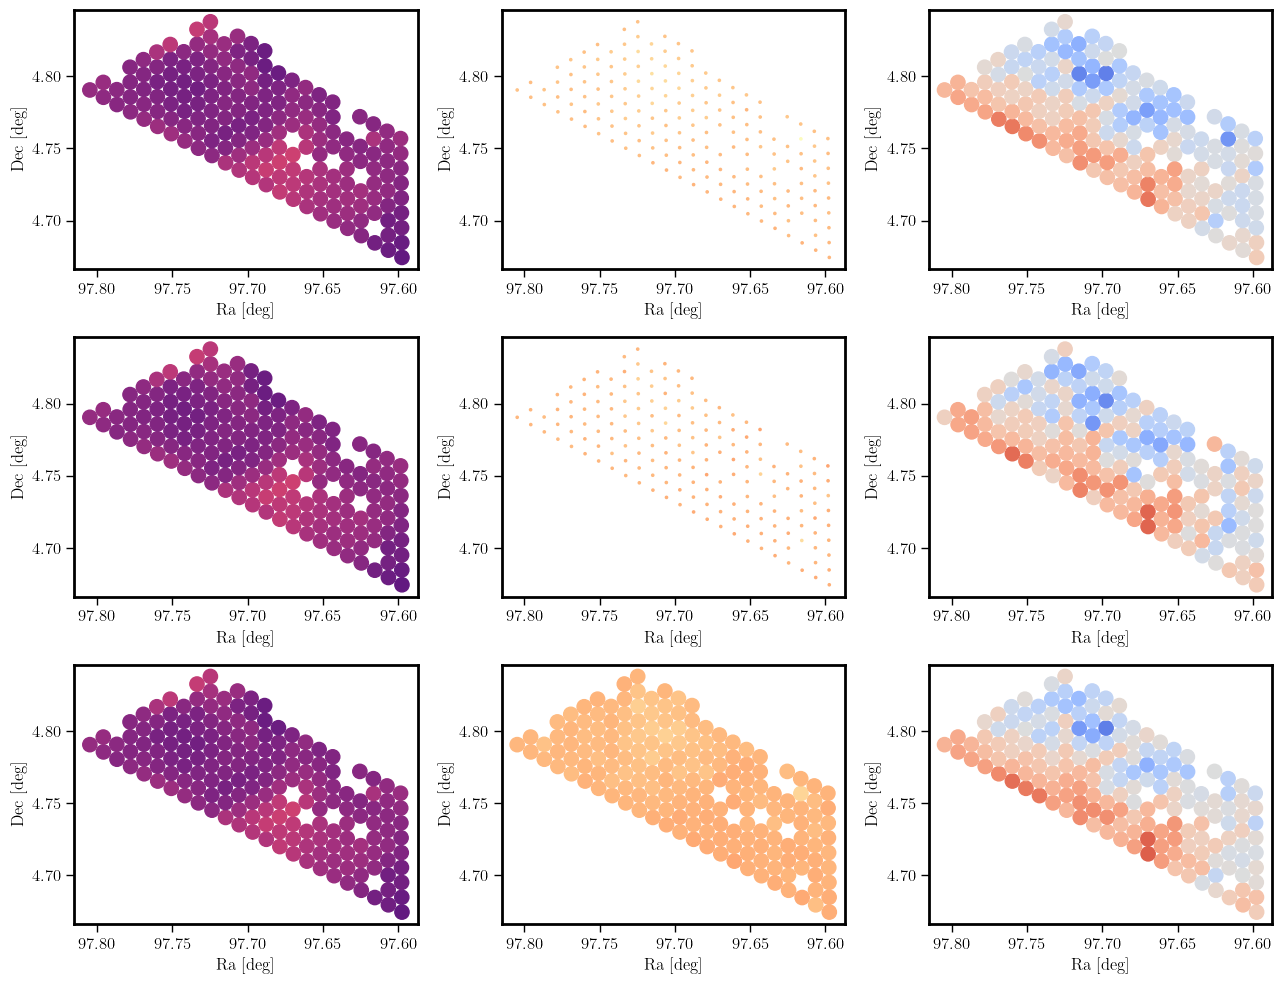

In [42]:
#tab_DAP['junk']=1.5*tab_DAP['flux_Halpha_6562.85']
%matplotlib inline
#tab_DAP = tab_DAP_nb_test
#tab_DAP = tab_DAP_cm_test

fig,axes = plt.subplots(3,3, figsize=(13,10))
#fig,axes = plt.subplots(2,3, figsize=(7,4))

#axes[0][0].text(97.8,5.15,'NP v1.0.0')
#axes[1][0].text(97.8,5.15,'PM v1.0.0')

fsize = 20
map_plot_DAP_ax(ax=axes[0][0],tab_DAP=tab_DAP,line='flux_Halpha_6562.85', \
                 vmin=-100, vmax=100000, title=None, filename='junk',\
             cmap='magma', fsize=fsize, figs_dir='figs',gamma=0.5,fig_type=None)

fsize = 10    
map_plot_DAP_ax(ax=axes[0][1],tab_DAP=tab_DAP,line='disp_Halpha_6562.85', \
                 vmin=0.2, vmax=0.75, title=None, filename='junk',\
             cmap='magma', fsize=fsize, figs_dir='figs',gamma=0.5,fig_type=None)

fsize = 10
map_plot_DAP_ax(ax=axes[0][2],tab_DAP = tab_DAP,line='vel_Halpha_6562.85', \
              vmin=-5, vmax=5, title=None, filename='junk',\
             cmap='coolwarm', fsize=fsize, figs_dir='figs',gamma=1,fig_type=None)

fsize = 10
map_plot_DAP_ax(ax=axes[1][0],tab_DAP=tab_DAP,line='flux_pe_6562.85', \
                 vmin=-100, vmax=100000, title=None, filename='junk',\
             cmap='magma', fsize=fsize, figs_dir='figs',gamma=0.5,fig_type=None)

fsize = 10
map_plot_DAP_ax(ax=axes[1][1],tab_DAP=tab_DAP,line='disp_pe_6562.85', \
                 vmin=0.2, vmax=0.75, title=None, filename='junk',\
             cmap='magma', fsize=fsize, figs_dir='figs',gamma=0.5,fig_type=None)
fsize = 10
map_plot_DAP_ax(ax=axes[1][2],tab_DAP = tab_DAP,line='vel_pe_6562.85', \
                 vmin=-5, vmax=5, title=None, filename='junk',\
             cmap='coolwarm', fsize=fsize, figs_dir='figs',gamma=1,fig_type=None)

fsize = 10
map_plot_DAP_ax(ax=axes[2][0],tab_DAP=tab_DAP,line='flux_pek_6562.85', \
                 vmin=-100, vmax=100000, title=None, filename='junk',\
             cmap='magma', fsize=fsize, figs_dir='figs',gamma=0.5,fig_type=None)

fsize = 10
map_plot_DAP_ax(ax=axes[2][1],tab_DAP=tab_DAP,line='disp_pek_6562.85', \
                 vmin=0.2, vmax=0.75, title=None, filename='junk',\
             cmap='magma', fsize=fsize, figs_dir='figs',gamma=0.5,fig_type=None)
fsize = 10
map_plot_DAP_ax(ax=axes[2][2],tab_DAP = tab_DAP,line='vel_pek_6562.85', \
                 vmin=-5, vmax=5, title=None, filename='junk',\
             cmap='coolwarm', fsize=fsize, figs_dir='figs',gamma=1,fig_type=None)



plt.tight_layout()


1.0025631113300992 1.0352298633321633 0.9659690426445325 vel: 0.836846346010923


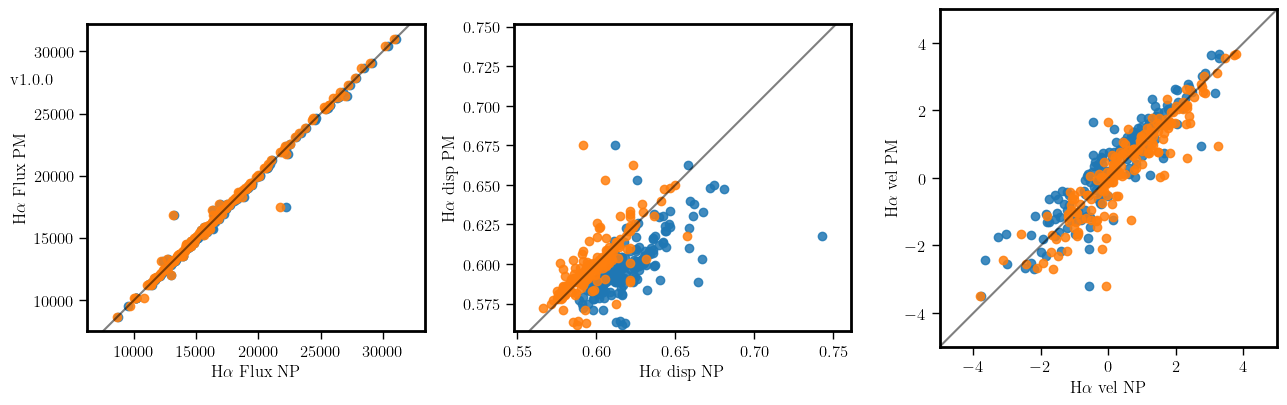

In [36]:
fig,axes = plt.subplots(1,3,figsize=(13,4.5))

#tab_DAP = tab_DAP_nb_test

mask_flux = tab_DAP['flux_Halpha_6562.85']>10000
rat_flux = np.median((tab_DAP['flux_Halpha_6562.85']/tab_DAP['flux_pe_6562.85'])[mask_flux])
rat_disp = np.median((tab_DAP['disp_Halpha_6562.85']/tab_DAP['disp_pe_6562.85'])[mask_flux])
rat_vel = np.median((tab_DAP['vel_Halpha_6562.85']/tab_DAP['vel_pe_6562.85'])[mask_flux])

print(rat_flux,rat_disp,1/rat_disp,'vel:',rat_vel)

ax = axes[0]
ax.scatter(tab_DAP['flux_Halpha_6562.85'],tab_DAP['flux_pe_6562.85'],alpha=0.85)
ax.scatter(tab_DAP['flux_pek_6562.85'],tab_DAP['flux_pe_6562.85'],alpha=0.85)
ax.set_xlabel(r'H$\alpha$ Flux NP')
ax.set_ylabel(r'H$\alpha$ Flux PM')
ax.set_aspect('equal', adjustable='box')
x_lim = ax.get_xlim()
ax.set_ylim(x_lim)
ax.plot(x_lim,x_lim,color='black',alpha=0.5)

ax.set_aspect('equal', 'box')
ax.text(0,x_lim[1]*0.85,'v1.0.0')

ax = axes[1]
ax.scatter(tab_DAP['disp_Halpha_6562.85'],tab_DAP['disp_pe_6562.85'],alpha=0.85)
ax.scatter(tab_DAP['disp_pek_6562.85'],tab_DAP['disp_pe_6562.85'],alpha=0.85)
ax.set_xlabel(r'H$\alpha$ disp NP')
ax.set_ylabel(r'H$\alpha$ disp PM')
ax.set_aspect('equal', adjustable='box')
x_lim = ax.get_xlim()
ax.set_ylim(x_lim)
ax.plot(x_lim,x_lim,color='black',alpha=0.5)
ax.set_aspect('equal', 'box')

ax = axes[2]
ax.scatter(tab_DAP['vel_Halpha_6562.85'],tab_DAP['vel_pe_6562.85'],alpha=0.85)
ax.scatter(tab_DAP['vel_pek_6562.85'],tab_DAP['vel_pe_6562.85'],alpha=0.85)
ax.set_xlabel(r'H$\alpha$ vel NP')
ax.set_ylabel(r'H$\alpha$ vel PM')
ax.set_aspect('equal', adjustable='box')

ax.set_xlim(-5,5)
x_lim = ax.get_xlim()
ax.set_ylim(x_lim)
ax.plot(x_lim,x_lim,color='black',alpha=0.5)
ax.set_aspect('equal', 'box')

plt.tight_layout()




